# Importations

In [51]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import functions
from functions import *
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, accuracy_score, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import shap
import random

# Données

## Target

In [4]:
data_set = application_train_test(num_rows = None, nan_as_category = False)

In [25]:
df_bar = pd.DataFrame()
df = data_set[data_set['TARGET'].notna()]
df_bar['TARGET'] = df['TARGET'].unique()
df_bar['count'] = df_bar['TARGET']
df_bar['count'] = df_bar['count'].apply(lambda x: len(df[df['TARGET']==x]))
df_bar

TARGET   count
0     1.0   24825
1     0.0  282682

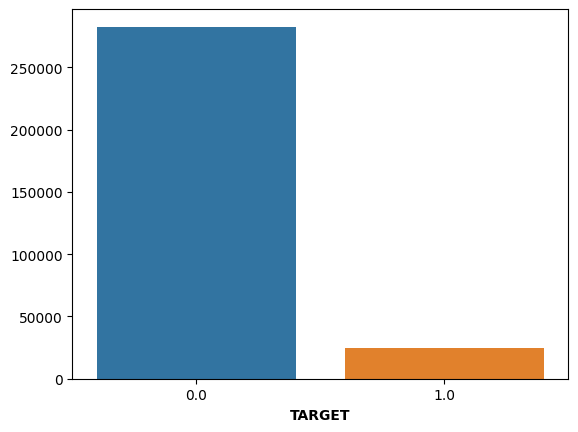

In [26]:
fig, ax = plt.subplots()
sns.barplot(ax=ax, data=df_bar, x='TARGET', y='count')
ax.set_xlabel('TARGET', weight='bold')
ax.set_ylabel('');

In [27]:
len(df.loc[df['TARGET']==1])/len(df)*100

8.07298695639449

In [7]:
float_columns = [col for col in df.columns if df[col].dtype == 'float']
int_column = [col for col in df.columns if df[col].dtype == 'int']

## Split train/test and missing datas

In [56]:
df_10000 = pd.read_csv('data_transformed.csv').iloc[:, 2:]
df_10000

SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  \
0          100002     1.0                   0            0             0   
1          100003     0.0                   0            1             0   
2          100004     0.0                   1            0             1   
3          100006     0.0                   0            1             0   
4          100007     0.0                   0            0             0   
...           ...     ...                 ...          ...           ...   
19995      172551     NaN                   0            1             0   
19996      172556     NaN                   0            0             1   
19997      172562     NaN                   0            1             0   
19998      172570     NaN                   0            0             0   
19999      172574     NaN                   0            1             0   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0                    0             0          202500.0    406597.5   
1                    1             0          270000.0   1293502.5   
2                    0             0           67500.0    135000.0   
3                    0             0          135000.0    312682.5   
4                    0             0          121500.0    513000.0   
...                ...           ...               ...         ...   
19995                0             0          135000.0    454500.0   
19996                1             1          180000.0    500490.0   
19997                0             0          202500.0    523152.0   
19998                0             1          382500.0    967500.0   
19999                1             1          112500.0    539100.0   

       AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0          24700.5         351000.0                    0.018801       -9461   
1          35698.5        1129500.0                    0.003541      -16765   
2           6750.0         135000.0                    0.010032      -19046   
3          29686.5         297000.0                    0.008019      -19005   
4          21865.5         513000.0                    0.028663      -19932   
...            ...              ...                         ...         ...   
19995      29173.5         454500.0                    0.028663      -18338   
19996      52555.5         450000.0                    0.046220      -15040   
19997      37336.5         463500.0                    0.032561      -17225   
19998      31338.0         967500.0                    0.072508      -14852   
19999      22837.5         450000.0                    0.010276      -11056   

       DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
0             -637.0            -3648.0            -2120          NaN   
1            -1188.0            -1186.0             -291          NaN   
2             -225.0            -4260.0            -2531         26.0   
3            -3039.0            -9833.0            -2437          NaN   
4            -3038.0            -4311.0            -3458          NaN   
...              ...                ...              ...          ...   
19995       -11264.0           -11220.0            -1892          NaN   
19996        -2125.0            -8982.0            -4474         18.0   
19997         -114.0            -1397.0             -771          NaN   
19998         -839.0            -3520.0            -1753          NaN   
19999         -142.0            -5187.0            -3709          NaN   

       FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  \
0               1               1                0                 1   
1               1               1                0                 1   
2               1               1                1                 1   
3               1               1                0                 1   
4               1               1                0                 

In [67]:
def split(df):
    feats = [f for f in df.columns if f not in ['SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    df1 = df[feats]
    X = df1[df1['TARGET'].notnull()].drop('TARGET', axis=1)
    y = df1[df1['TARGET'].notnull()]['TARGET']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    X_train = X_train.reset_index().drop('index', axis=1)
    X_test = X_test.reset_index().drop('index', axis=1)
    y_train = y_train.reset_index().drop('index', axis=1).squeeze()
    y_test = y_test.reset_index().drop('index', axis=1).squeeze()
    return X_train, X_test, y_train, y_test

In [45]:
def imputer(X_train, X_test):
    feats = [f for f in X_train.columns]
    imp = SimpleImputer(strategy='median')
    imp.fit(X_train)
    X_train_full = imp.transform(X_train)
    X_test_full = imp.transform(X_test)
    X_train_full = pd.DataFrame(columns=feats, data=X_train_full)
    X_test_full = pd.DataFrame(columns=feats, data=X_test_full)
    
    return X_train_full, X_test_full

## Imbalanced data

In [28]:
# Illustration graphique de smote et RandomUnderSampler

In [44]:
df_10000 = phase1()

Train samples: 10000, test samples: 10000
Bureau df shape: (2011, 108)
Process bureau and bureau_balance - done in 1s
Previous applications df shape: (9734, 242)
Process previous_applications - done in 1s
Pos-cash balance df shape: (9494, 15)
Process POS-CASH balance - done in 0s
Installments payments df shape: (8893, 26)
Process installments payments - done in 1s
Credit card balance df shape: (9520, 131)
Process credit card balance - done in 1s
data avant remplissage shape : (20000, 779)
data final shape : (20000, 257)


In [45]:
df_bar = pd.DataFrame()
df1 = df_10000[df['TARGET'].notna()]
df_bar['TARGET'] = df1['TARGET'].unique()
df_bar['count'] = df_bar['TARGET']
df_bar['count'] = df_bar['count'].apply(lambda x: len(df1[df1['TARGET']==x]))
df_bar

TARGET  count
0     1.0    775
1     0.0   9225

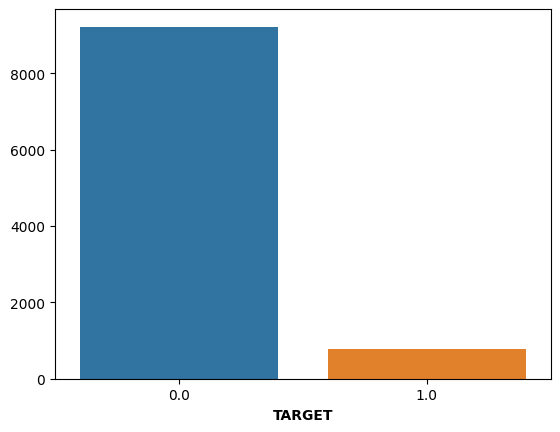

In [46]:
fig, ax = plt.subplots()
sns.barplot(ax=ax, data=df_bar, x='TARGET', y='count')
ax.set_xlabel('TARGET', weight='bold')
ax.set_ylabel('');

In [47]:
from imblearn.over_sampling import SMOTE, KMeansSMOTE, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
over = SMOTE(random_state=42, sampling_strategy=0.6, k_neighbors=3)
under = RandomUnderSampler(random_state=42, sampling_strategy=0.9)

In [48]:
feats = [f for f in df1.columns if f not in ['SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index', 'TARGET']]
X_train = df1[feats]
imp = SimpleImputer(strategy='median')
imp.fit(X_train)
X_train_full = imp.transform(X_train)
X_train_full = pd.DataFrame(columns=feats, data=X_train_full)

In [49]:
X_train_over, y_train_over = over.fit_resample(X_train_full, df1['TARGET'])
X_train_under, y_train_under = under.fit_resample(X_train_over, y_train_over)
x_over = ((y_train_over).value_counts()).to_frame()
x_under = (y_train_under.value_counts()).to_frame()

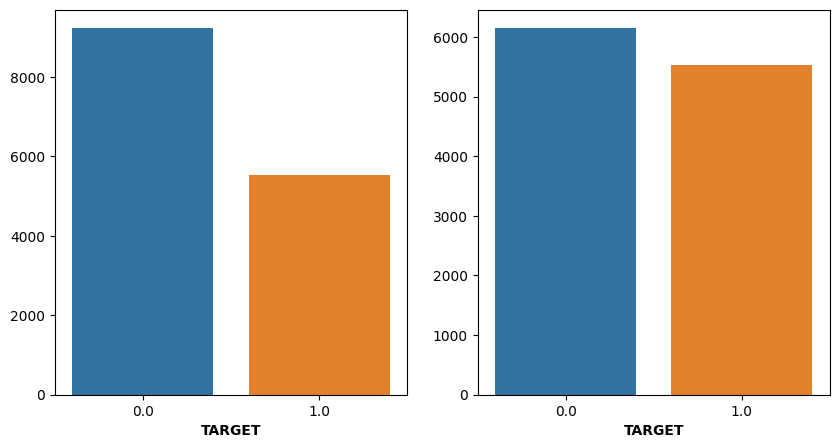

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.barplot(ax=ax[0], data=x_over, x=x_over.index, y='TARGET')
sns.barplot(ax=ax[1], data=x_under, x=x_under.index, y='TARGET')
ax[0].set_xlabel('TARGET', weight='bold')
ax[0].set_ylabel('')
ax[1].set_xlabel('TARGET', weight='bold')
ax[1].set_ylabel('');

# Base line : Logistic regression

## Functions
### display_importances

In [74]:
# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    best_features = best_features[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False).reset_index()
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values('importance', ascending=False), color='blue', saturation=0.2)
    plt.title('Features Importance(avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')

### score_function

In [75]:
def score_function(y, y_pred):
    cm = confusion_matrix(y, y_pred)
    return len(y)/(10*cm[1][0] + cm[0][1])
from sklearn.metrics import make_scorer
custom_score = make_scorer(score_function, greater_is_better=True, needs_proba=False)

### score_df

In [76]:
def score_df(results_train, results_valid, results_test):
    df = pd.DataFrame(columns = ['Validation', 'Train', 'Test'], index = ['Accuracy', 'Cost', 'F1_score', 'Precision', 'Profit', 'Recall', 'roc_auc'])
    
    df['Train'] = results_train
    df['Validation'] = results_valid
    df['Test'] = results_test
    return(df)

## roc_auc - Threshold decision function moved

In [77]:
import pickle

def Log_reg(df, num_folds, stratified = False):
    
    X_train, X_test, y_train, y_test  = split(df)
    
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=42)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=42)
   
    features = [f for f in df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    feature_importance_df = pd.DataFrame()
    result = []
    result_validation_set = pd.DataFrame(index=['Accuracy', 'Cost', 'F1_score', 'Precision', 'Profit', 'Recall', 'roc_auc'])
    
    fig, ax = plt.subplots(2, num_folds, figsize=(num_folds*5, 10))
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train[features], y_train)):
        train_x, train_y = X_train[features].iloc[train_idx], y_train.iloc[train_idx]
        valid_x, valid_y = X_train[features].iloc[valid_idx], y_train.iloc[valid_idx]
        
        imp = SimpleImputer(strategy='median')
        scl = MinMaxScaler()
        regressor = LogisticRegression(max_iter=2000, C=0.01) 
        steps = [('imp', imp), ('scl', scl), ('model', regressor)]
        pipe = Pipeline(steps)
        pipe.fit(train_x, train_y)
    
         # Calcul des scores roc_auc pour valid et test
        valid_predict = pipe.predict_proba(valid_x)
        valid_predict_proba = [pred[1] for pred in valid_predict]
        valid_predict_proba_df = pd.DataFrame(valid_predict_proba)
        
        param = np.linspace(0.01, 0.2, 20)
        cost = []
        
        for i in param: 
            valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>i else 0)
            cm_valid = confusion_matrix(valid_y, valid_predict_class)
            cost += [(10*cm_valid[1][0] + cm_valid[0][1])/len(valid_y)*100]
        sns.lineplot(ax=ax[0][n_fold], x=param, y=cost)
        ax[0][n_fold].set_title('Cost train = f(threshold)', weight='bold')
    
        # Construction des matrices de confusion avec le meilleur threshold
        best_param = param[cost.index(min(cost))]
        print(f"Threshold optimum: {best_param}")
        result += [best_param]
        valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>best_param else 0)
        cm_valid = confusion_matrix(valid_y, valid_predict_class)
        confusion_valid = ConfusionMatrixDisplay(cm_valid)
        confusion_valid.plot(ax=ax[1][n_fold])
        confusion_valid.ax_.set_title('Validation set: confusion matrix', weight='bold')
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = features
        fold_importance_df["importance"] = pipe['model'].coef_[0]
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        feature_importance_df["importance"] = feature_importance_df["importance"].apply(lambda x: abs(x))
        
        results_valid = [accuracy_score(valid_y, valid_predict_class),
                    (10*cm_valid[1][0] + cm_valid[0][1])/len(valid_x)*100,
                    f1_score(valid_y, valid_predict_class),
                    precision_score(valid_y, valid_predict_class),
                    (cm_valid[0][0]-(10*cm_valid[1][0] ))/len(valid_x)*100,
                    recall_score(valid_y, valid_predict_class),
                    roc_auc_score(valid_y, valid_predict_proba)] 
        result_validation_set['n_fold'] = results_valid
    result_validation = result_validation_set.mean(axis=1)
        
    best_threshold = np.array(result).mean()
    print(f"Threshold optimum - Mean: {best_threshold}")

    imp = SimpleImputer(strategy='median')
    scl = MinMaxScaler()
    regressor = LogisticRegression(max_iter=2000, C=0.01) 
    steps = [('imp', imp), ('scl', scl), ('model', regressor)]
    pipe = Pipeline(steps)
    pipe.fit(X_train, y_train)
    filename = 'saved_Log_reg_model.joblib'
    joblib.dump(pipe, filename)

    
    train_predict = pipe.predict_proba(X_train)
    train_predict_proba = [pred[1] for pred in train_predict]
    train_predict_proba_df = pd.DataFrame(train_predict_proba)
    train_predict_class = train_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    test_predict = pipe.predict_proba(X_test)
    test_predict_proba = [pred[1] for pred in test_predict]
    test_predict_proba_df = pd.DataFrame(test_predict_proba)
    test_predict_class = test_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    
    cm_train = confusion_matrix(y_train, train_predict_class)
    confusion_train = ConfusionMatrixDisplay(cm_train)
    cm_test = confusion_matrix(y_test, test_predict_class)
    confusion_test = ConfusionMatrixDisplay(cm_test)
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    confusion_train.plot(ax=ax[0])
    confusion_train.ax_.set_title('Train: confusion matrix', weight='bold')
    confusion_test.plot(ax=ax[1])
    confusion_test.ax_.set_title('Test: confusion matrix', weight='bold')
    
    results_test = [accuracy_score(y_test, test_predict_class),
                    (10*cm_test[1][0] + cm_test[0][1])/len(X_test)*100,
                    f1_score(y_test, test_predict_class),
                    precision_score(y_test, test_predict_class),
                    (cm_test[0][0]-(10*cm_test[1][0] ))/len(X_test)*100,
                    recall_score(y_test, test_predict_class),
                    roc_auc_score(y_test, test_predict_proba)] 
    results_train = [accuracy_score(y_train, train_predict_class),
                    (10*cm_train[1][0] + cm_train[0][1])/len(X_train)*100,
                    f1_score(y_train, train_predict_class),
                    precision_score(y_train, train_predict_class),
                    (cm_train[0][0]-(10*cm_train[1][0] ))/len(X_train)*100,
                    recall_score(y_train, train_predict_class),
                    roc_auc_score(y_train, train_predict_proba)] 
    print(score_df(results_train, result_validation, results_test))
   
    display_importances(feature_importance_df)
  


In [80]:
def model1_Log_reg(df, num_folds=5, stratified = True):
    with timer("Run Logistic regression"):
        Log_reg(df, num_folds=5, stratified = True)

Threshold optimum: 0.09
Threshold optimum: 0.09999999999999999
Threshold optimum: 0.09999999999999999
Threshold optimum: 0.09999999999999999
Threshold optimum: 0.09
Threshold optimum - Mean: 0.096
           Validation      Train       Test
Accuracy     0.733125   0.776000   0.764500
Cost        57.625000  53.562500  54.600000
F1_score     0.244248   0.276836   0.267496
Precision    0.156463   0.184607   0.176230
Profit      34.625000  38.687500  37.650000
Recall       0.556452   0.553226   0.554839
roc_auc      0.715961   0.742171   0.750779
Run Logistic regression - done in 5s


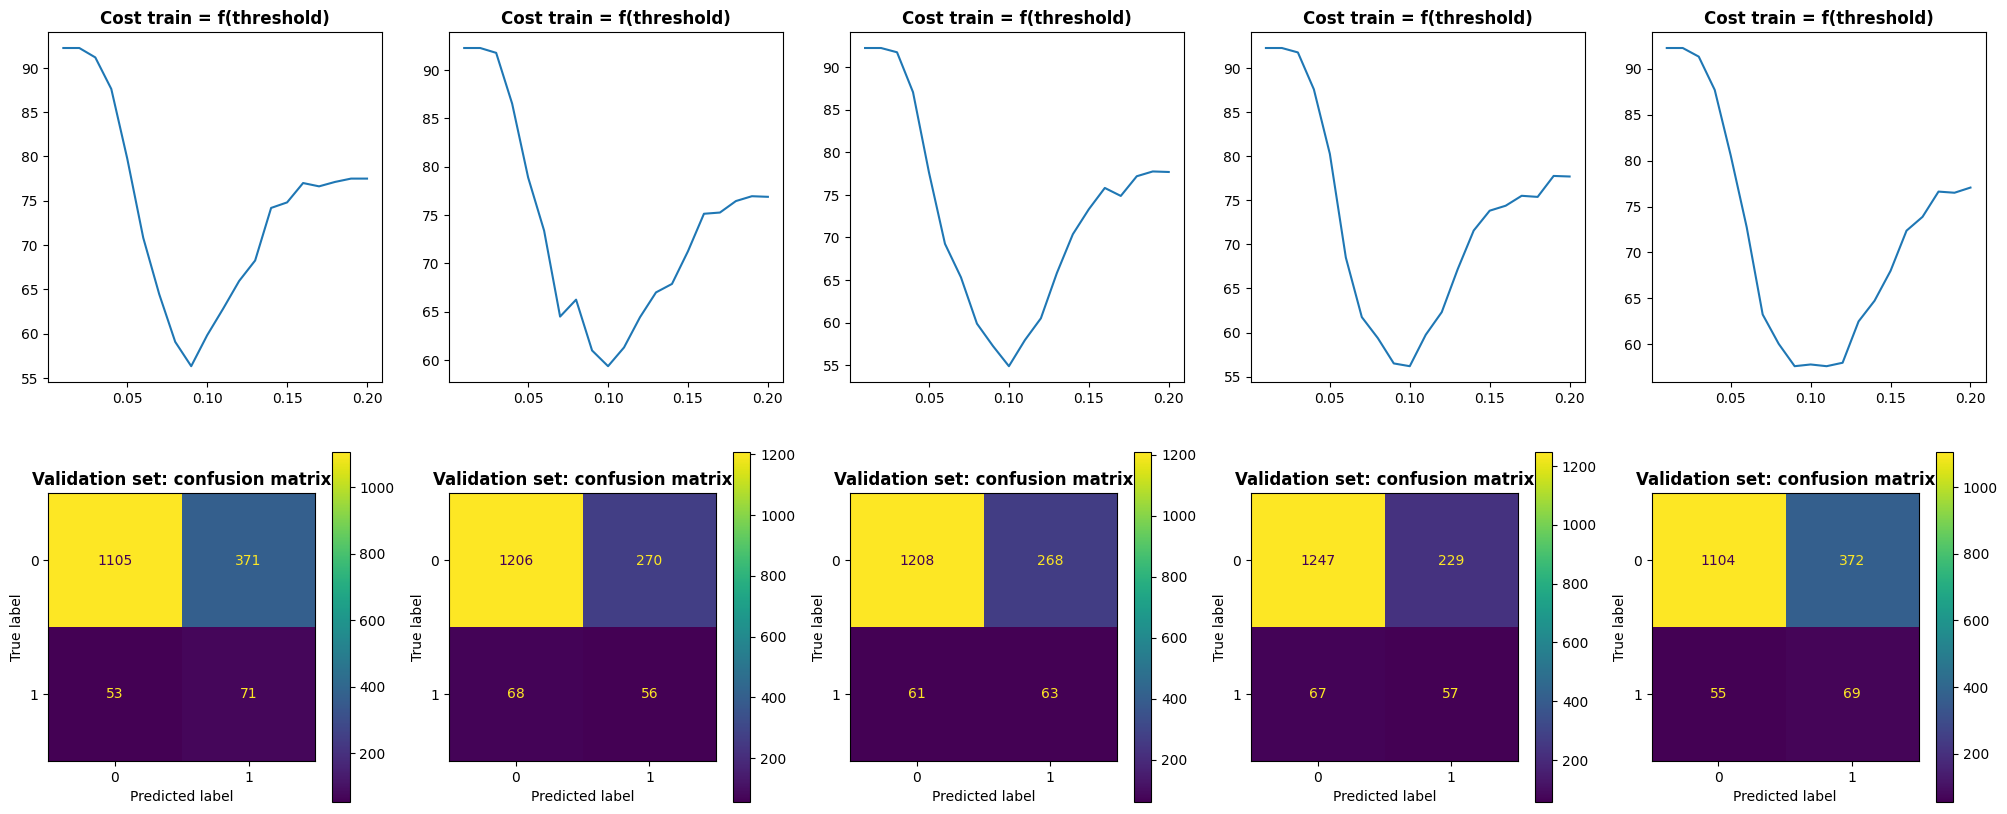

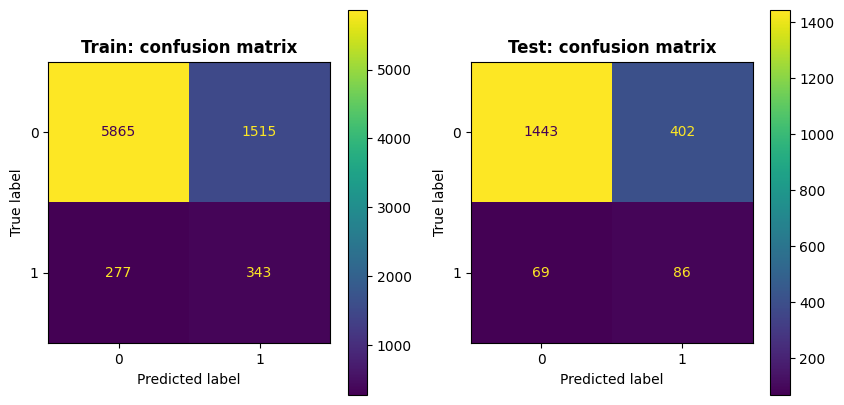

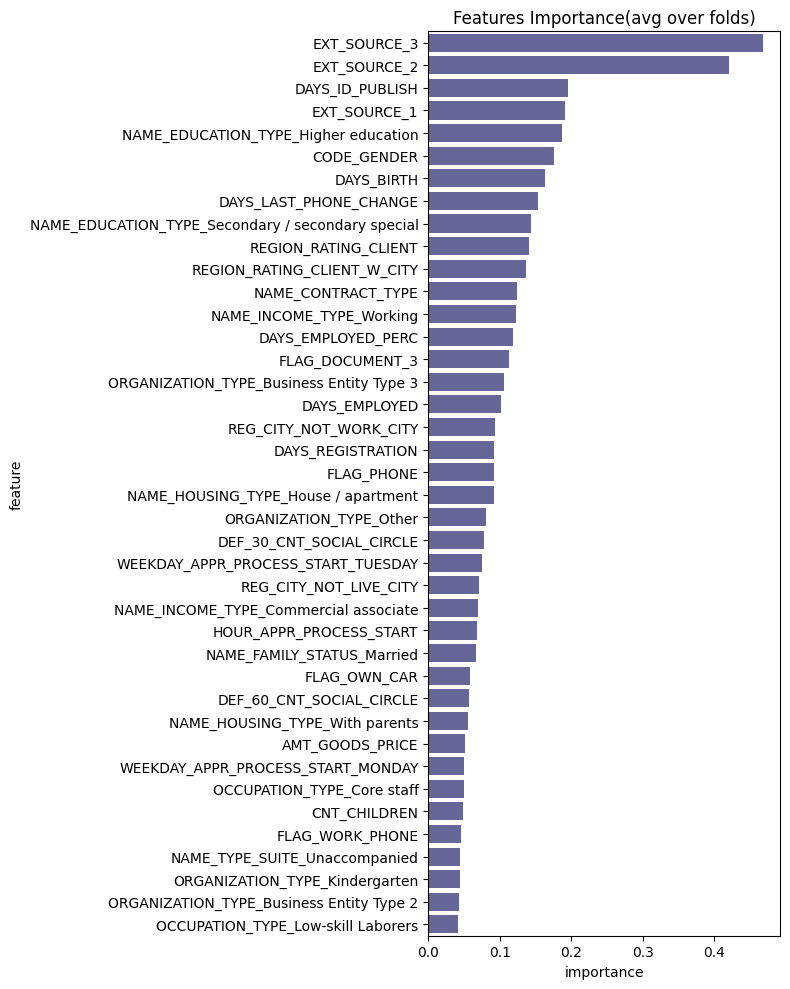

In [81]:
model1_Log_reg(df_10000)

In [88]:
saved_Log_reg_model = joblib.load('saved_Log_reg_model.joblib')

In [124]:
X_train, X_test, y_train, y_test = split(df_10000)

In [125]:
class WaterfallData():
    def __init__ (self, shap_test, col, expected_value, data):
        self.values = shap_test[col].values
        self.base_values = expected_value
        self.data = data
        self.feature_names = shap_test.index
        self.display_data = shap_test.index

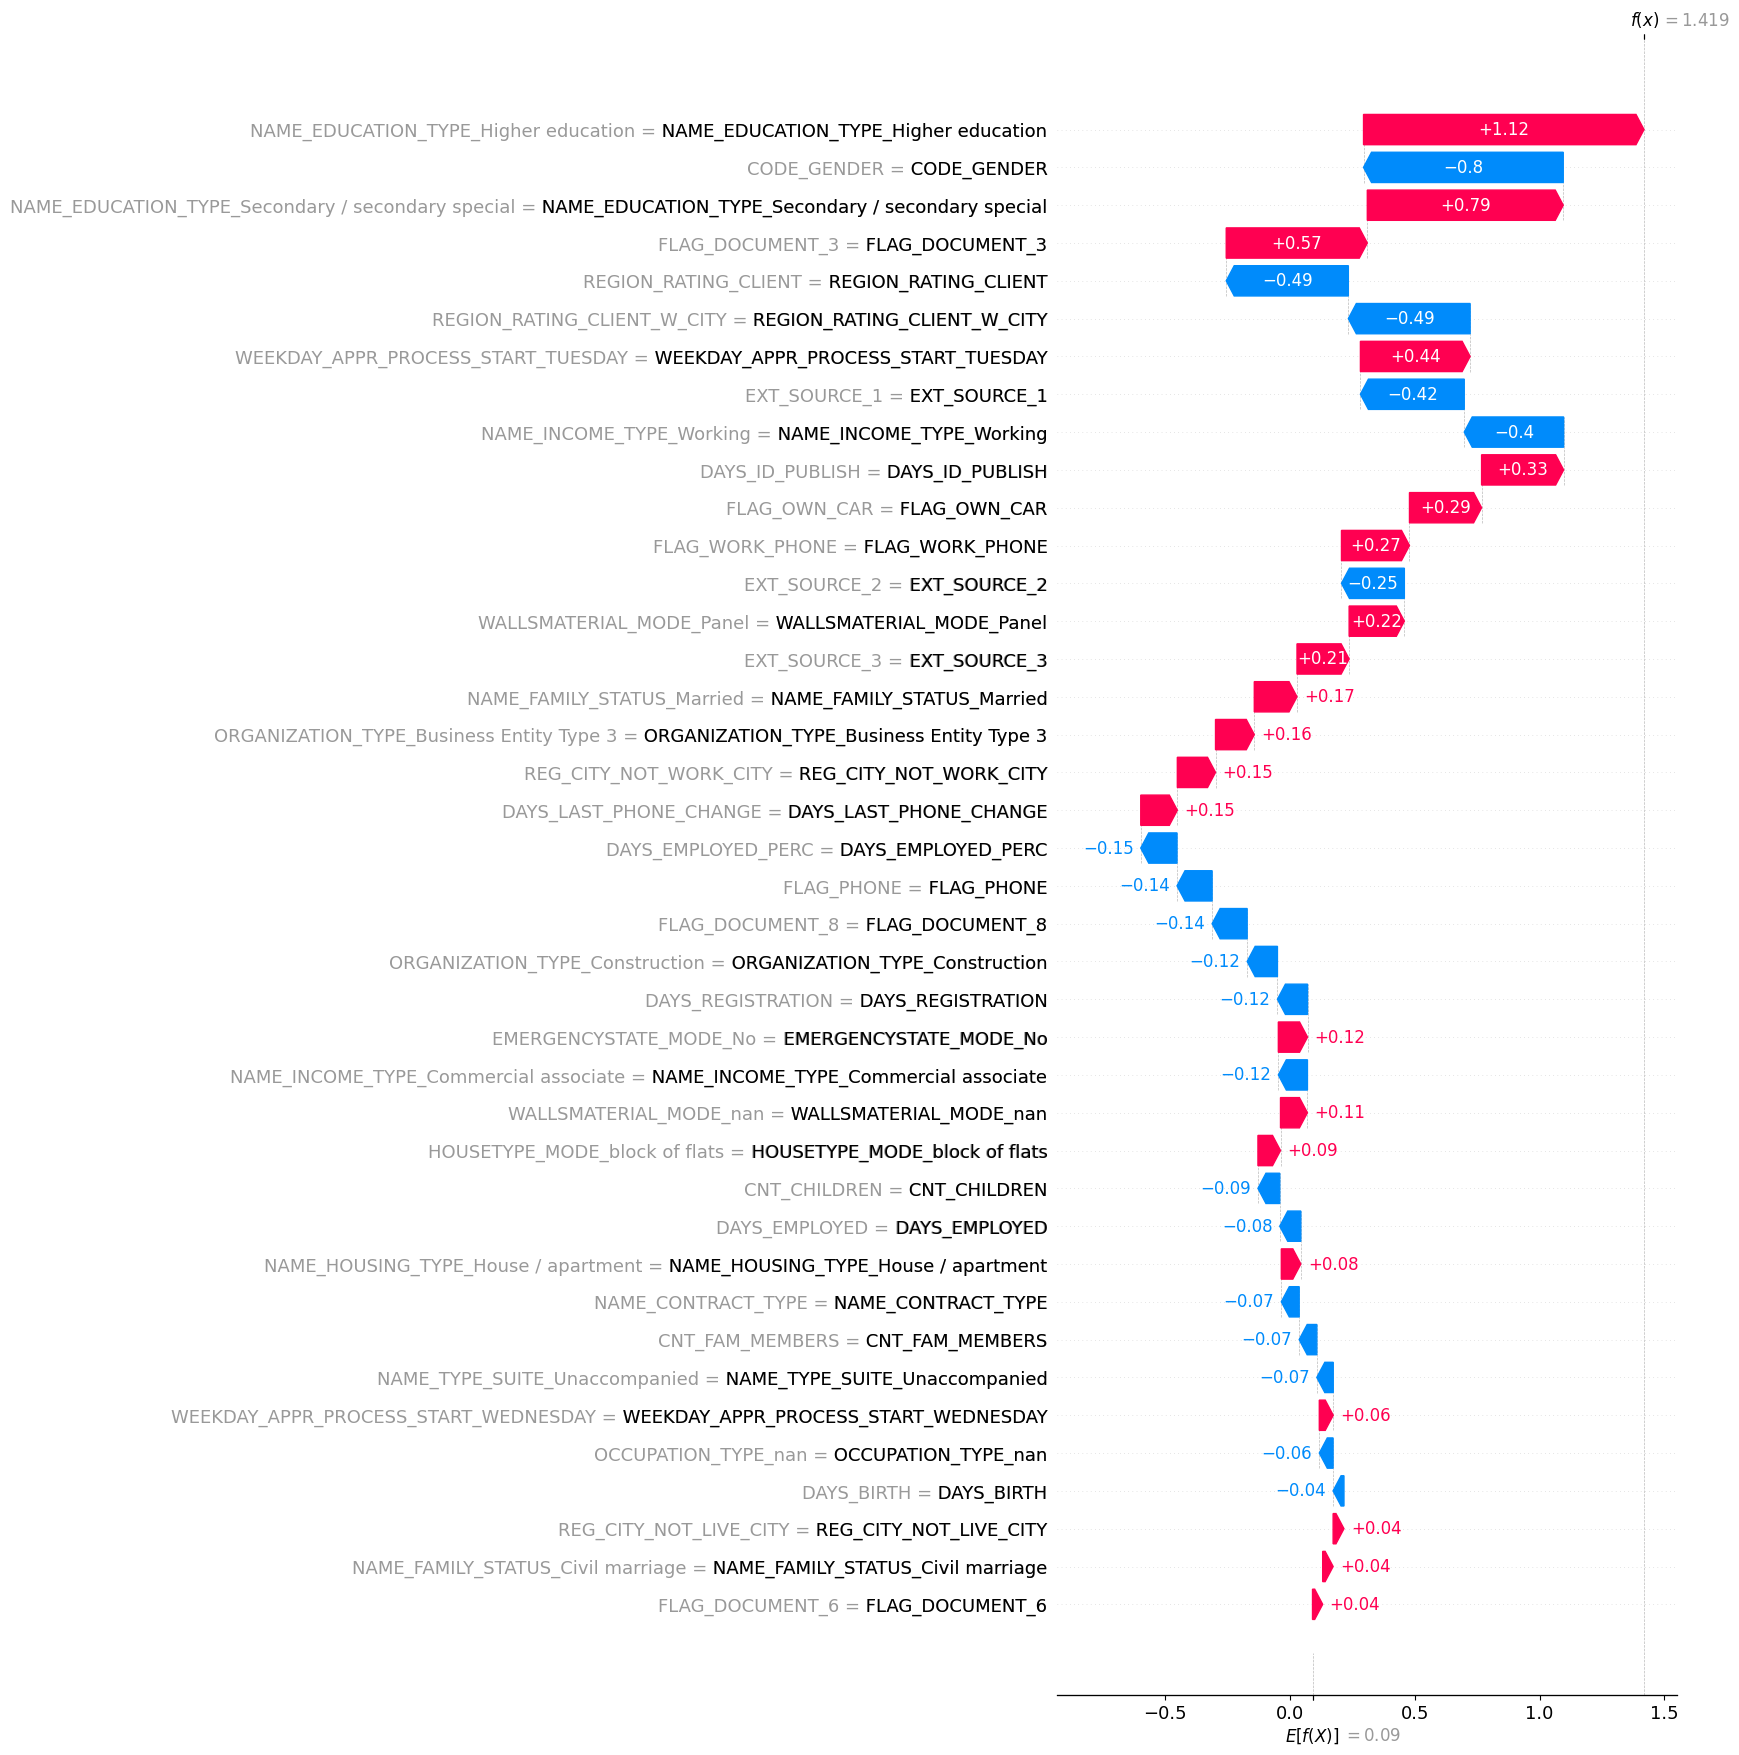

In [132]:
# Plot valeur de shapley pour l'individu i
X_train1 = saved_Log_reg_model['imp'].transform(X_train)
X_train2 = saved_Log_reg_model['scl'].transform(X_train1)
X_train_transformed = pd.DataFrame(columns=X_train.columns, data=X_train2)
sample = shap.utils.sample(X_train_transformed, nsamples=100)
explainer = shap.KernelExplainer(saved_Log_reg_model['model'].predict_proba, sample)
X_test1 = saved_Log_reg_model['imp'].transform(X_test)
X_test2 = saved_Log_reg_model['scl'].transform(X_test1)
X_test_transformed = pd.DataFrame(columns=X_train.columns, data=X_test2)
i=16
test_example = X_test_transformed.iloc[i,:]
shap_values = explainer.shap_values(test_example)
features_importantes = pd.DataFrame(index= X_train.columns, columns=['shap'], data=100*shap_values[0])
features_importantes['abs'] = features_importantes['shap'].apply(lambda x: abs(x))
features_importantes = features_importantes.sort_values('abs', ascending=False).iloc[:40]
expected_value =  (y_train)[sample.index].mean()
shap.plots.waterfall(WaterfallData(features_importantes, 'shap', expected_value, test_example), max_display=40)
    

## Idem - weight : balanced

In [ ]:
# equilibrage des classes grâce à l'hyperparamètre class_weight='balanced'

In [141]:
import joblib
def Log_reg_balanced(df, num_folds, stratified = False):
    
    X_train, X_test, y_train, y_test  = split(df)
    
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=42)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=42)
   
    features = [f for f in X_train.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    feature_importance_df = pd.DataFrame()
    result = []
    result_validation_set = pd.DataFrame()
    
    fig, ax = plt.subplots(2, num_folds, figsize=(num_folds*5, 10))
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train[features], y_train)):
        train_x, train_y = X_train[features].iloc[train_idx], y_train.iloc[train_idx]
        valid_x, valid_y = X_train[features].iloc[valid_idx], y_train.iloc[valid_idx]
        
        imp = SimpleImputer(strategy='median')
        scl = MinMaxScaler()
        regressor = LogisticRegression(max_iter=2000, C=0.01, class_weight='balanced') 
        steps = [('imp', imp), ('scl', scl), ('model', regressor)]
        pipe = Pipeline(steps)
        pipe.fit(train_x, train_y)
    
         # Calcul des scores roc_auc pour valid et test
        valid_predict = pipe.predict_proba(valid_x)
        valid_predict_proba = [pred[1] for pred in valid_predict]
        valid_predict_proba_df = pd.DataFrame(valid_predict_proba)
        
        param = np.linspace(0.4, 0.7, 20)
        cost = []
        
        for i in param: 
            valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>i else 0)
            cm_valid = confusion_matrix(valid_y, valid_predict_class)
            cost += [(10*cm_valid[1][0] + cm_valid[0][1])/len(valid_y)*100]
        sns.lineplot(ax=ax[0][n_fold], x=param, y=cost)
        ax[0][n_fold].set_title('Cost train = f(threshold)', weight='bold')
    
        # Construction des matrices de confusion avec le meilleur threshold
        best_param = param[cost.index(min(cost))]
        print(f"Threshold optimum: {best_param}")
        result += [best_param]
        valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>best_param else 0)
        cm_valid = confusion_matrix(valid_y, valid_predict_class)
        confusion_valid = ConfusionMatrixDisplay(cm_valid)
        confusion_valid.plot(ax=ax[1][n_fold])
        confusion_valid.ax_.set_title('Validation set: confusion matrix', weight='bold')
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = features
        fold_importance_df["importance"] = pipe['model'].coef_[0]
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        feature_importance_df["importance"] = feature_importance_df["importance"].apply(lambda x: abs(x))
        
        results_valid = [accuracy_score(valid_y, valid_predict_class),
                    (10*cm_valid[1][0] + cm_valid[0][1])/len(valid_x)*100,
                    f1_score(valid_y, valid_predict_class),
                    precision_score(valid_y, valid_predict_class),
                    (cm_valid[0][0]-(10*cm_valid[1][0] ))/len(valid_x)*100,
                    recall_score(valid_y, valid_predict_class),
                    roc_auc_score(valid_y, valid_predict_proba)] 
        result_validation_set[n_fold] = results_valid  
    result_validation = list(result_validation_set.mean(axis=1))  
    
    best_threshold = np.array(result).mean()
    print(f"Threshold optimum - Mean: {best_threshold}")
    
    imp = SimpleImputer(strategy='median')
    scl = MinMaxScaler()
    regressor = LogisticRegression(max_iter=2000, C=0.01, class_weight='balanced') 
    steps = [('imp', imp), ('scl', scl), ('model', regressor)]
    pipe = Pipeline(steps)
    pipe.fit(X_train, y_train)
    filename = 'Log_reg_balanced_model.joblib'
    joblib.dump(pipe, filename)
    
    train_predict = pipe.predict_proba(X_train)
    train_predict_proba = [pred[1] for pred in train_predict]
    train_predict_proba_df = pd.DataFrame(train_predict_proba)
    train_predict_class = train_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    test_predict = pipe.predict_proba(X_test)
    test_predict_proba = [pred[1] for pred in test_predict]
    test_predict_proba_df = pd.DataFrame(test_predict_proba)
    test_predict_class = test_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    
    cm_train = confusion_matrix(y_train, train_predict_class)
    confusion_train = ConfusionMatrixDisplay(cm_train)
    cm_test = confusion_matrix(y_test, test_predict_class)
    confusion_test = ConfusionMatrixDisplay(cm_test)
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    confusion_train.plot(ax=ax[0])
    confusion_train.ax_.set_title('Train: confusion matrix', weight='bold')
    confusion_test.plot(ax=ax[1])
    confusion_test.ax_.set_title('Test: confusion matrix', weight='bold')
    
    results_test = [accuracy_score(y_test, test_predict_class),
                    (10*cm_test[1][0] + cm_test[0][1])/len(X_test)*100,
                    f1_score(y_test, test_predict_class),
                    precision_score(y_test, test_predict_class),
                    (cm_test[0][0]-(10*cm_test[1][0] ))/len(X_test)*100,
                    recall_score(y_test, test_predict_class),
                    roc_auc_score(y_test, test_predict_proba)] 
    results_train = [accuracy_score(y_train, train_predict_class),
                    (10*cm_train[1][0] + cm_train[0][1])/len(X_train)*100,
                    f1_score(y_train, train_predict_class),
                    precision_score(y_train, train_predict_class),
                    (cm_train[0][0]-(10*cm_train[1][0] ))/len(X_train)*100,
                    recall_score(y_train, train_predict_class),
                    roc_auc_score(y_train, train_predict_proba)] 
    print(score_df(results_train, result_validation, results_test))
   
    display_importances(feature_importance_df) 

In [142]:
def model2_Log_reg(df, num_folds=5, stratified = True):
    with timer("Run Logistic regression balanced"):
        Log_reg_balanced(df, num_folds=5, stratified=True)    

Threshold optimum: 0.4789473684210526
Threshold optimum: 0.5421052631578948
Threshold optimum: 0.5578947368421052
Threshold optimum: 0.49473684210526314
Threshold optimum: 0.5578947368421052
Threshold optimum - Mean: 0.5263157894736842
           Validation      Train       Test
Accuracy     0.739750   0.749000   0.729500
Cost        54.825000  51.312500  52.250000
F1_score     0.262068   0.278217   0.267930
Precision    0.171038   0.179001   0.169521
Profit      37.425000  40.937500  40.000000
Recall       0.587097   0.624194   0.638710
roc_auc      0.731700   0.768306   0.762895
Run Logistic regression balanced - done in 4s


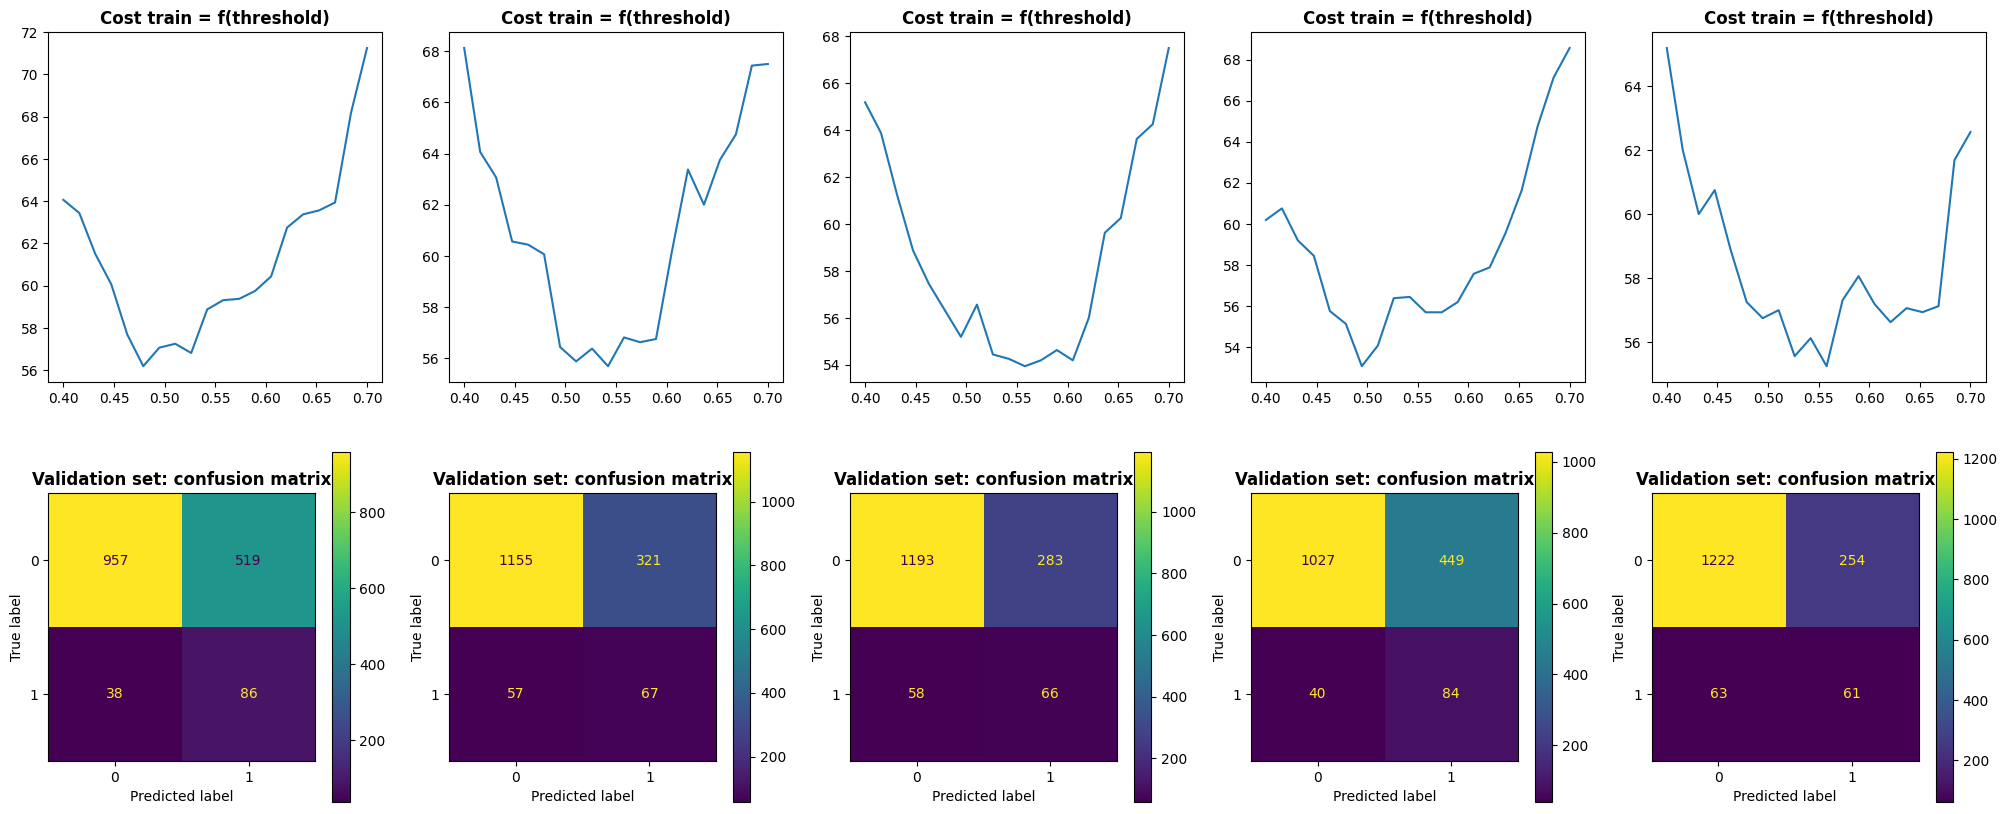

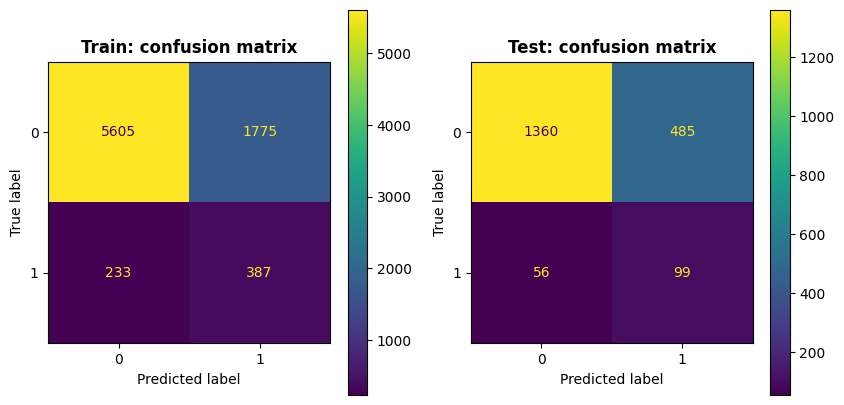

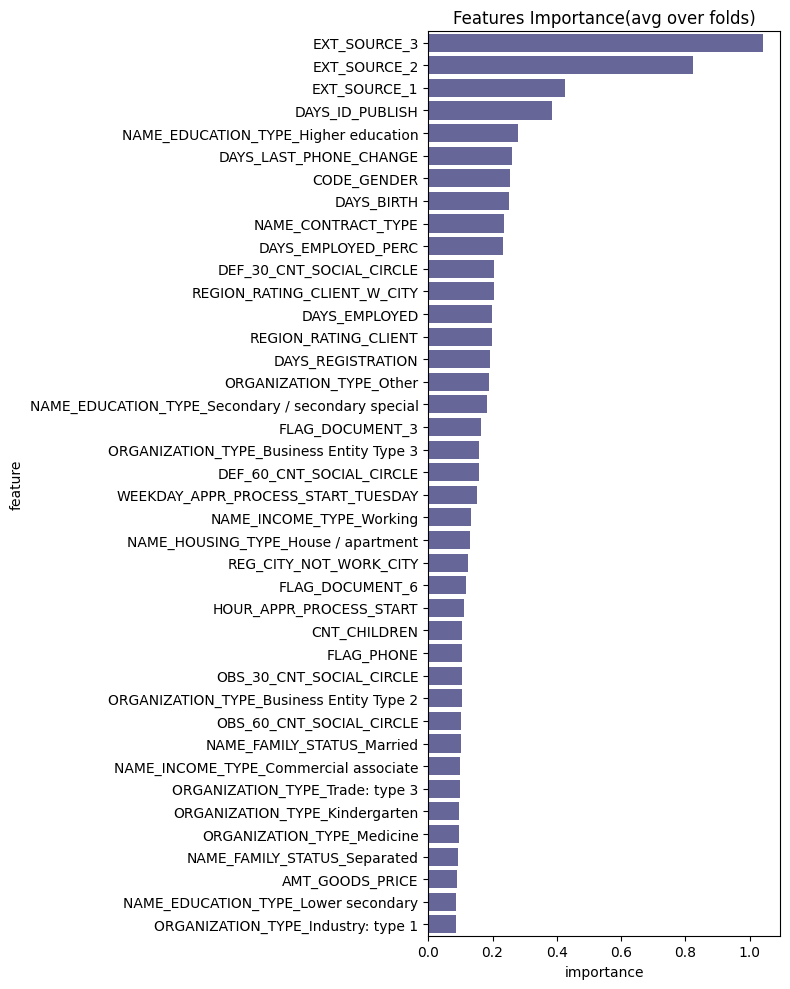

In [143]:
model2_Log_reg(df_10000)

In [140]:
saved_Log_reg_balanced_model = joblib.load('Log_reg_balanced_model.joblib')

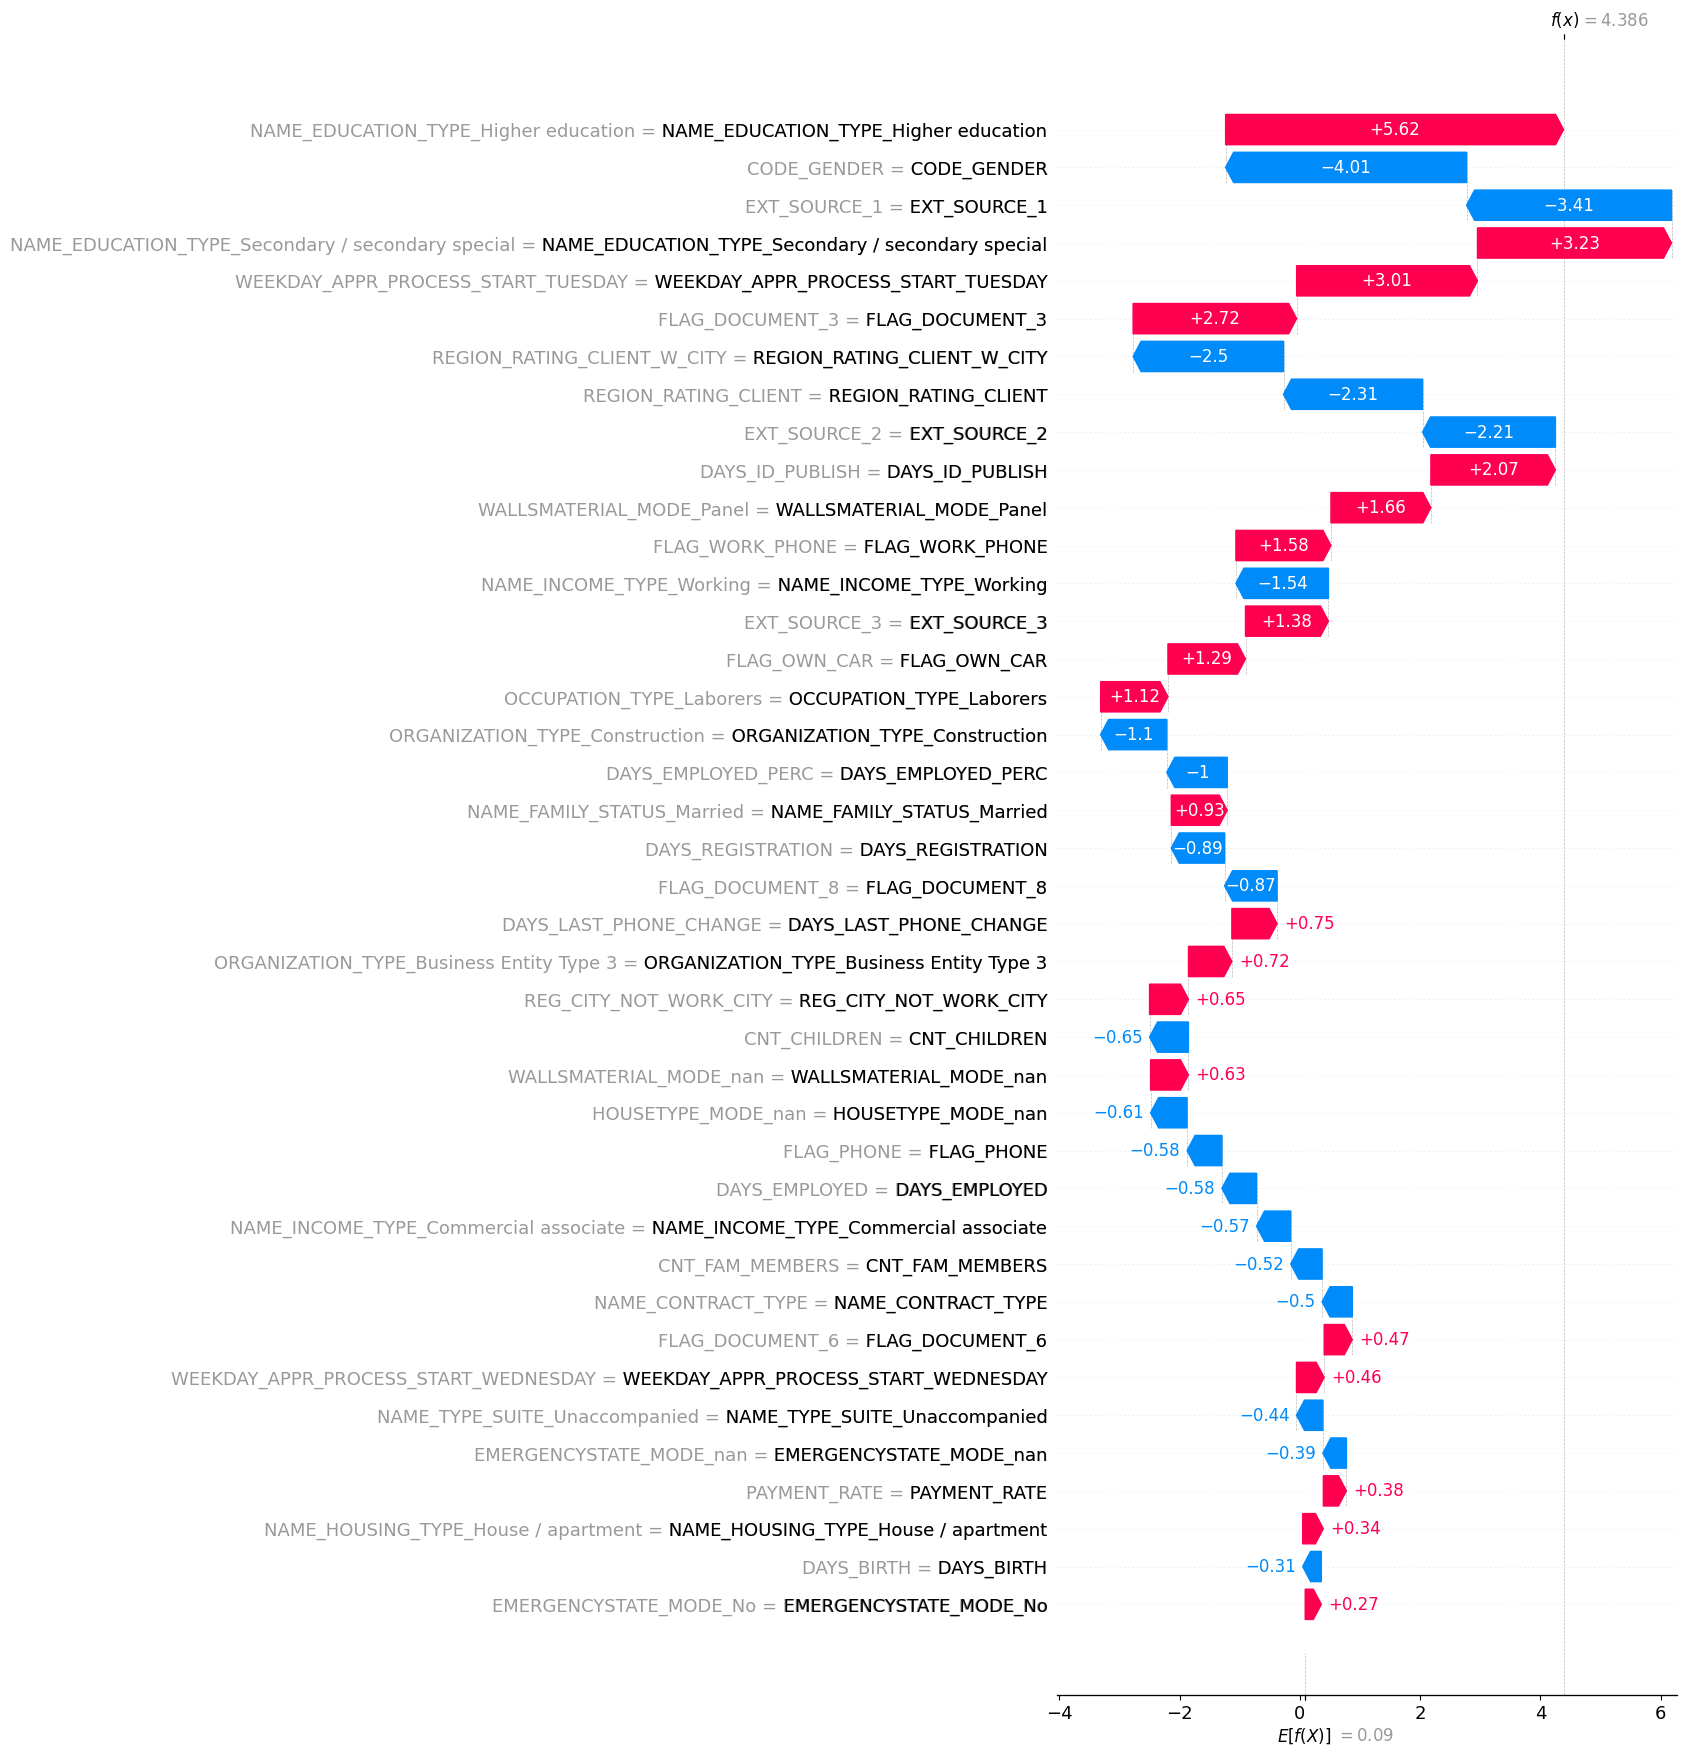

In [189]:
# Plot valeur de shapley pour l'individu i
X_train1 = saved_Log_reg_balanced_model['imp'].transform(X_train)
X_train2 = saved_Log_reg_balanced_model['scl'].transform(X_train1)
X_train_transformed = pd.DataFrame(columns=X_train.columns, data=X_train2)
sample = shap.utils.sample(X_train_transformed, nsamples=100)
explainer = shap.KernelExplainer(saved_Log_reg_balanced_model['model'].predict_proba, sample)
X_test1 = saved_Log_reg_balanced_model['imp'].transform(X_test)
X_test2 = saved_Log_reg_balanced_model['scl'].transform(X_test1)
X_test_transformed = pd.DataFrame(columns=X_train.columns, data=X_test2)
i=16
test_example = X_test_transformed.iloc[i,:]
shap_values = explainer.shap_values(test_example)
features_importantes = pd.DataFrame(index= X_train.columns, columns=['shap'], data=100*shap_values[0])
features_importantes['abs'] = features_importantes['shap'].apply(lambda x: abs(x))
features_importantes = features_importantes.sort_values('abs', ascending=False).iloc[:40]
expected_value =  (y_train)[sample.index].mean()
shap.plots.waterfall(WaterfallData(features_importantes, 'shap', expected_value, test_example), max_display=40)

## Idem - Balanced with smote 

In [145]:
from imblearn.over_sampling import SMOTE, KMeansSMOTE, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [146]:
def Log_reg_smote(df, num_folds, stratified = False):
    from imblearn.pipeline import Pipeline
    
    X_train, X_test, y_train, y_test  = split(df)
    
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=42)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=42)
   
    features = [f for f in X_train.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    feature_importance_df = pd.DataFrame()
    result = []
    result_validation_set = pd.DataFrame()
    
    fig, ax = plt.subplots(2, num_folds, figsize=(num_folds*5, 10))
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train[features], y_train)):
        train_x, train_y = X_train[features].iloc[train_idx], y_train.iloc[train_idx]
        valid_x, valid_y = X_train[features].iloc[valid_idx], y_train.iloc[valid_idx]
        
        imp = SimpleImputer(strategy='median')
        scl = MinMaxScaler()
        over = SMOTE(random_state=42, sampling_strategy=0.4, k_neighbors=3)
        under = RandomUnderSampler(random_state=42, sampling_strategy=0.9)
        regressor = LogisticRegression(max_iter=2000) 
        steps = [('imp', imp), ('scl', scl), ('over', over), ('under', under), ('model', regressor)]
        pipe = Pipeline(steps)
        pipe.fit(train_x, train_y)
    
       # Calcul des scores roc_auc pour valid et test
        valid_predict = pipe.predict_proba(valid_x)
        valid_predict_proba = [pred[1] for pred in valid_predict]
        valid_predict_proba_df = pd.DataFrame(valid_predict_proba)
        
        param = np.linspace(0.4, 0.7, 20)
        cost = []
        
        for i in param: 
            valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>i else 0)
            cm_valid = confusion_matrix(valid_y, valid_predict_class)
            cost += [(10*cm_valid[1][0] + cm_valid[0][1])/len(valid_y)*100]
        sns.lineplot(ax=ax[0][n_fold], x=param, y=cost)
        ax[0][n_fold].set_title('Cost train = f(threshold)', weight='bold')
    
        # Construction des matrices de confusion avec le meilleur threshold
        best_param = param[cost.index(min(cost))]
        print(f"Threshold optimum: {best_param}")
        result += [best_param]
        valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>best_param else 0)
        cm_valid = confusion_matrix(valid_y, valid_predict_class)
        confusion_valid = ConfusionMatrixDisplay(cm_valid)
        confusion_valid.plot(ax=ax[1][n_fold])
        confusion_valid.ax_.set_title('Validation set: confusion matrix', weight='bold')
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = features
        fold_importance_df["importance"] = pipe['model'].coef_[0]
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        feature_importance_df["importance"] = feature_importance_df["importance"].apply(lambda x: abs(x))
        
        results_valid = [accuracy_score(valid_y, valid_predict_class),
                    (10*cm_valid[1][0] + cm_valid[0][1])/len(valid_x)*100,
                    f1_score(valid_y, valid_predict_class),
                    precision_score(valid_y, valid_predict_class),
                    (cm_valid[0][0]-(10*cm_valid[1][0] ))/len(valid_x)*100,
                    recall_score(valid_y, valid_predict_class),
                    roc_auc_score(valid_y, valid_predict_proba)] 
        result_validation_set['n_fold'] = results_valid
    result_validation = list(result_validation_set.mean(axis=1))
        
    best_threshold = np.array(result).mean()
    print(f"Threshold optimum - Mean: {best_threshold}")
    
    imp = SimpleImputer(strategy='median')
    scl = MinMaxScaler()
    over = SMOTE(random_state=42, sampling_strategy=0.4, k_neighbors=3)
    under = RandomUnderSampler(random_state=42, sampling_strategy=0.6)
    regressor = LogisticRegression(max_iter=2000) 
    steps = [('imp', imp), ('scl', scl), ('over', over), ('under', under), ('model', regressor)]
    pipe = Pipeline(steps)
    pipe.fit(X_train, y_train)
    filename = 'Log_reg_smote_model.joblib'
    joblib.dump(pipe, filename)
    
    train_predict = pipe.predict_proba(X_train)
    train_predict_proba = [pred[1] for pred in train_predict]
    train_predict_proba_df = pd.DataFrame(train_predict_proba)
    train_predict_class = train_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    test_predict = pipe.predict_proba(X_test)
    test_predict_proba = [pred[1] for pred in test_predict]
    test_predict_proba_df = pd.DataFrame(test_predict_proba)
    test_predict_class = test_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    
    cm_train = confusion_matrix(y_train, train_predict_class)
    confusion_train = ConfusionMatrixDisplay(cm_train)
    cm_test = confusion_matrix(y_test, test_predict_class)
    confusion_test = ConfusionMatrixDisplay(cm_test)
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    confusion_train.plot(ax=ax[0])
    confusion_train.ax_.set_title('Train: confusion matrix', weight='bold')
    confusion_test.plot(ax=ax[1])
    confusion_test.ax_.set_title('Test: confusion matrix', weight='bold')
    
    results_test = [accuracy_score(y_test, test_predict_class),
                    (10*cm_test[1][0] + cm_test[0][1])/len(X_test)*100,
                    f1_score(y_test, test_predict_class),
                    precision_score(y_test, test_predict_class),
                    (cm_test[0][0]-(10*cm_test[1][0] ))/len(X_test)*100,
                    recall_score(y_test, test_predict_class),
                    roc_auc_score(y_test, test_predict_proba)] 
    results_train = [accuracy_score(y_train, train_predict_class),
                    (10*cm_train[1][0] + cm_train[0][1])/len(X_train)*100,
                    f1_score(y_train, train_predict_class),
                    precision_score(y_train, train_predict_class),
                    (cm_train[0][0]-(10*cm_train[1][0] ))/len(X_train)*100,
                    recall_score(y_train, train_predict_class),
                    roc_auc_score(y_train, train_predict_proba)] 
    print(score_df(results_train, result_validation, results_test))
   
    display_importances(feature_importance_df) 

In [149]:
def model3_Log_reg(df, num_folds=5, stratified = True):
    with timer("Run Logistic regression smote"):
        Log_reg_smote(df, num_folds=5, stratified = True)

Threshold optimum: 0.43157894736842106
Threshold optimum: 0.5263157894736842
Threshold optimum: 0.5736842105263158
Threshold optimum: 0.5263157894736842
Threshold optimum: 0.6368421052631579
Threshold optimum - Mean: 0.5389473684210526
           Validation      Train       Test
Accuracy     0.830625   0.843750   0.811500
Cost        56.875000  51.287500  66.100000
F1_score     0.281167   0.326509   0.209644
Precision    0.209486   0.245146   0.155280
Profit      35.375000  40.962500  26.150000
Recall       0.427419   0.488710   0.322581
roc_auc      0.728150   0.785186   0.702775
Run Logistic regression smote - done in 9s


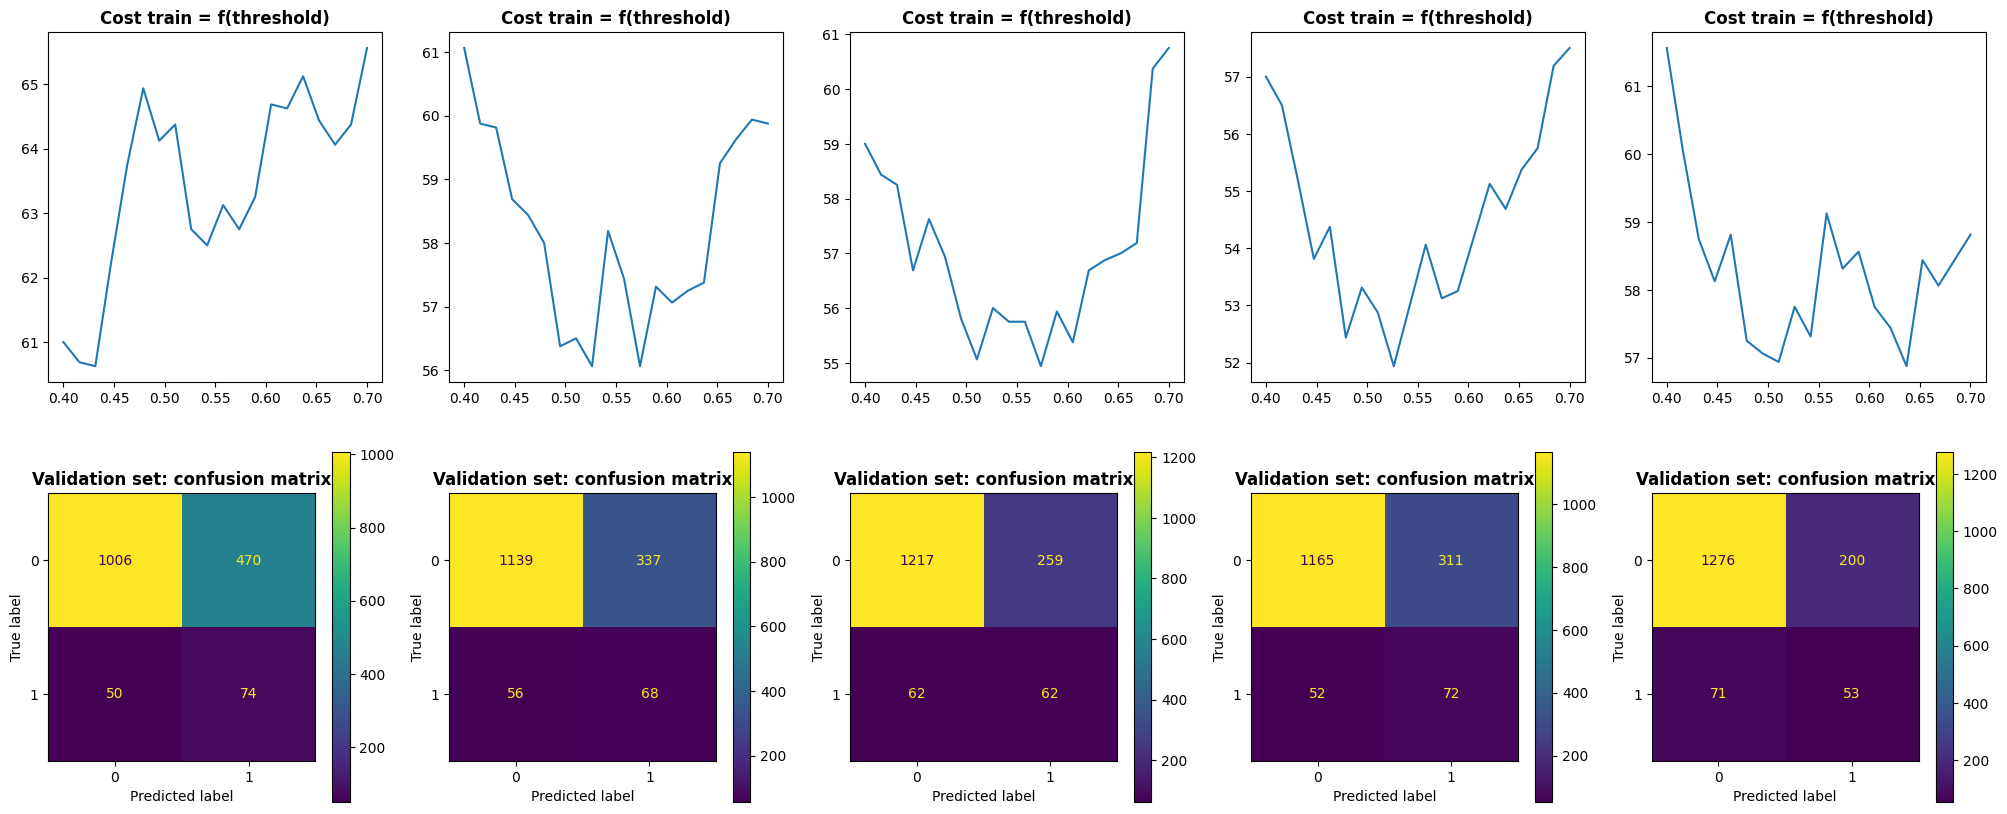

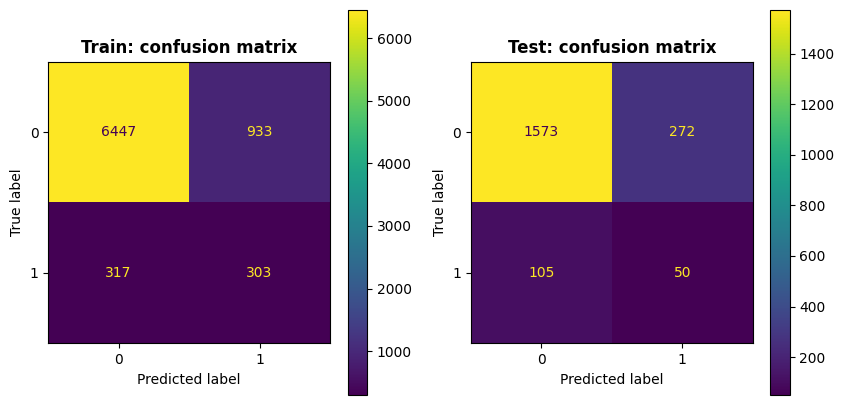

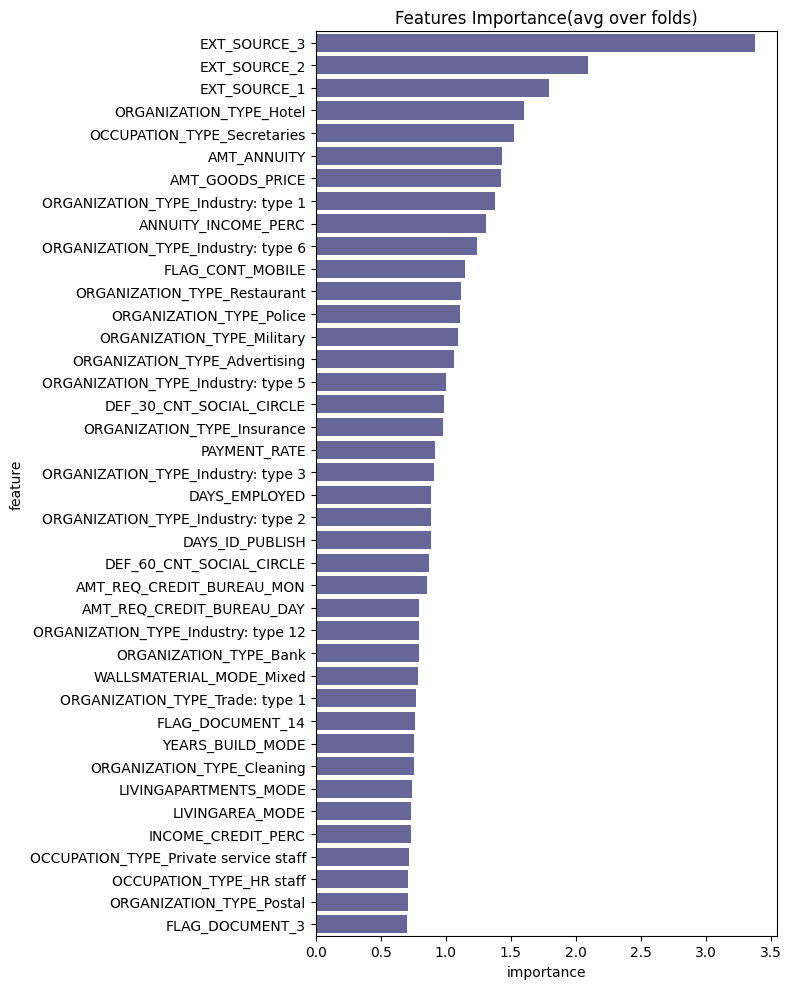

In [150]:
model3_Log_reg(df_10000)

In [151]:
saved_Log_reg_smote_model = joblib.load('Log_reg_smote_model.joblib')

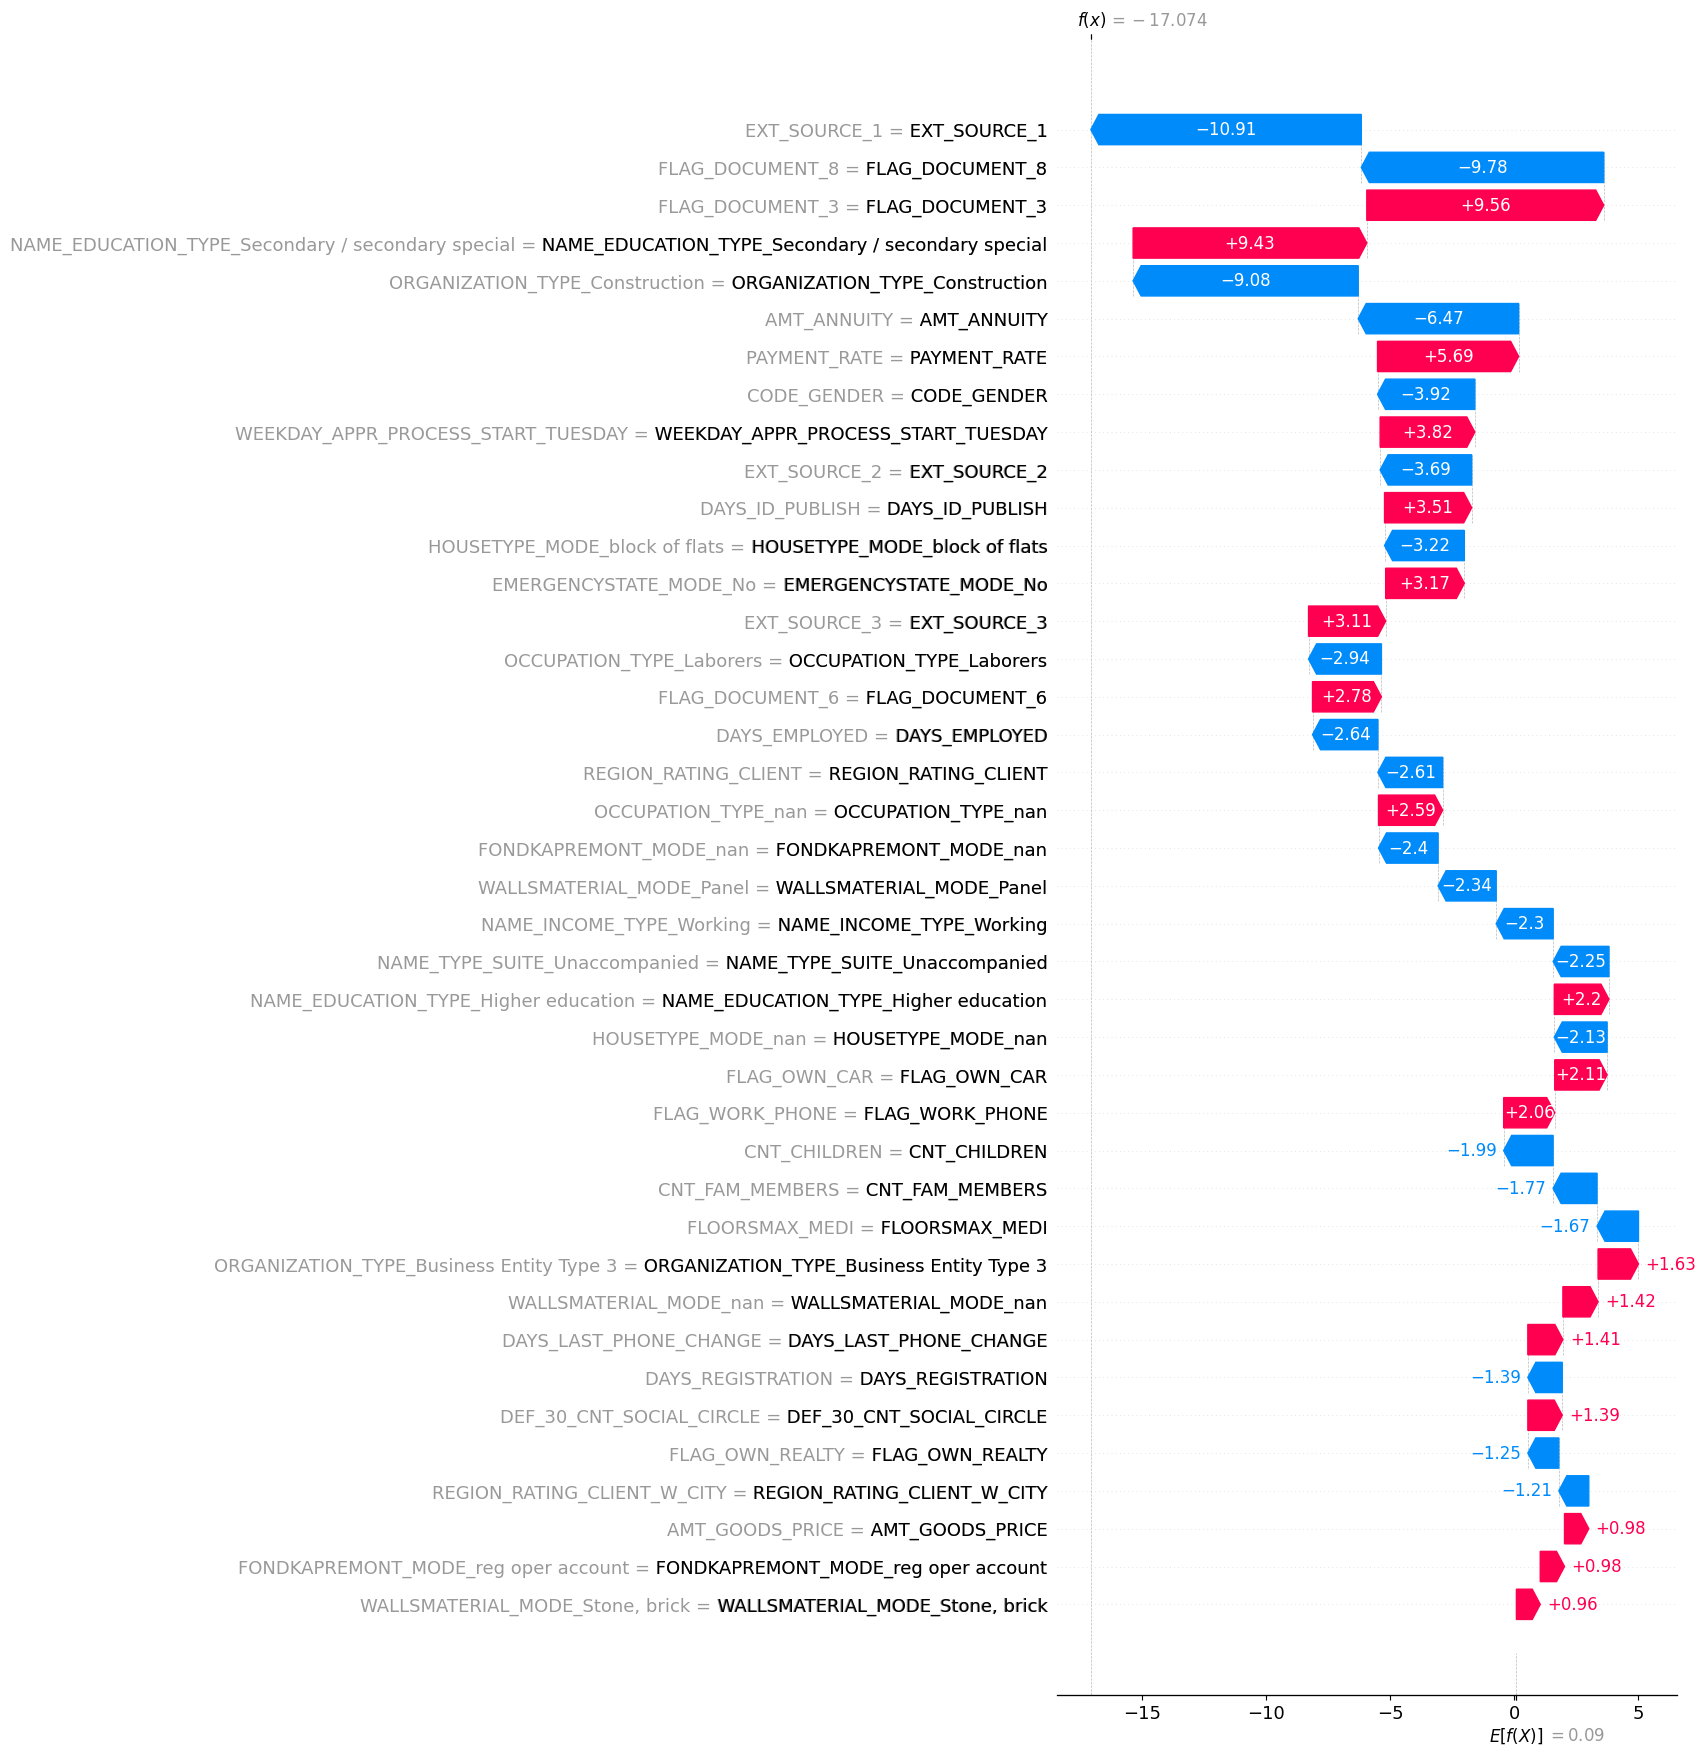

In [190]:
# Plot valeur de shapley pour l'individu i
X_train1 = saved_Log_reg_smote_model['imp'].transform(X_train)
X_train2 = saved_Log_reg_smote_model['scl'].transform(X_train1)
X_train_transformed = pd.DataFrame(columns=X_train.columns, data=X_train2)
sample = shap.utils.sample(X_train_transformed, nsamples=100)
explainer = shap.KernelExplainer(saved_Log_reg_smote_model['model'].predict_proba, sample)
X_test1 = saved_Log_reg_smote_model['imp'].transform(X_test)
X_test2 = saved_Log_reg_smote_model['scl'].transform(X_test1)
X_test_transformed = pd.DataFrame(columns=X_train.columns, data=X_test2)
i=16
test_example = X_test_transformed.iloc[i,:]
shap_values = explainer.shap_values(test_example)
features_importantes = pd.DataFrame(index= X_train.columns, columns=['shap'], data=100*shap_values[0])
features_importantes['abs'] = features_importantes['shap'].apply(lambda x: abs(x))
features_importantes = features_importantes.sort_values('abs', ascending=False).iloc[:40]
expected_value =  (y_train)[sample.index].mean()
shap.plots.waterfall(WaterfallData(features_importantes, 'shap', expected_value, test_example), max_display=40)

# Model téléchargé
## lightgbm - Balanced

In [153]:
def lightgbm(df, num_folds, stratified = False):
    
    X_train, X_test, y_train, y_test  = split(df)
    
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=42)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=42)
   
    features = [f for f in X_train.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    feature_importance_df = pd.DataFrame()
    result = []
    result_validation_set = pd.DataFrame()
    
    fig, ax = plt.subplots(2, num_folds, figsize=(num_folds*5, 10))
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train[features], y_train)):
        train_x, train_y = X_train[features].iloc[train_idx], y_train.iloc[train_idx]
        valid_x, valid_y = X_train[features].iloc[valid_idx], y_train.iloc[valid_idx]
        
        imp = SimpleImputer(strategy='median')
        scl = MinMaxScaler()
        regressor = LGBMClassifier(
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            verbose=-1, 
            class_weight='balanced')
        steps = [('imp', imp), ('scl', scl), ('model', regressor)]
        pipe = Pipeline(steps)
        pipe.fit(train_x, train_y)
        
    # Calcul des scores roc_auc pour valid et test
        valid_predict = pipe.predict_proba(valid_x)
        valid_predict_proba = [pred[1] for pred in valid_predict]
        valid_predict_proba_df = pd.DataFrame(valid_predict_proba)
        
        param = np.linspace(0.05, 0.6, 20)
        cost = []
        
        for i in param: 
            valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>i else 0)
            cm_valid = confusion_matrix(valid_y, valid_predict_class)
            cost += [(10*cm_valid[1][0] + cm_valid[0][1])/len(valid_y)*100]
        sns.lineplot(ax=ax[0][n_fold], x=param, y=cost)
        ax[0][n_fold].set_title('Cost train = f(threshold)', weight='bold')
    
        # Construction des matrices de confusion avec le meilleur threshold
        best_param = param[cost.index(min(cost))]
        print(f"Threshold optimum: {best_param}")
        result += [best_param]
        valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>best_param else 0)
        cm_valid = confusion_matrix(valid_y, valid_predict_class)
        confusion_valid = ConfusionMatrixDisplay(cm_valid)
        confusion_valid.plot(ax=ax[1][n_fold])
        confusion_valid.ax_.set_title('Validation set: confusion matrix', weight='bold')
       
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = features
        fold_importance_df["importance"] = pipe['model'].feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        feature_importance_df["importance"] = feature_importance_df["importance"].apply(lambda x: abs(x))
        
        results_valid = [accuracy_score(valid_y, valid_predict_class),
                    (10*cm_valid[1][0] + cm_valid[0][1])/len(valid_x)*100,
                    f1_score(valid_y, valid_predict_class),
                    precision_score(valid_y, valid_predict_class),
                    (cm_valid[0][0]-(10*cm_valid[1][0] ))/len(valid_x)*100,
                    recall_score(valid_y, valid_predict_class),
                    roc_auc_score(valid_y, valid_predict_proba)] 
        result_validation_set['n_fold'] = results_valid
    result_validation = list(result_validation_set.mean(axis=1))
        
    best_threshold = np.array(result).mean()
    print(f"Threshold optimum - Mean: {best_threshold}")

    imp = SimpleImputer(strategy='median')
    scl = MinMaxScaler()
    over = SMOTE(random_state=42, sampling_strategy=0.4, k_neighbors=3)
    under = RandomUnderSampler(random_state=42, sampling_strategy=0.6)
    regressor = LGBMClassifier(
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            verbose=-1,
        class_weight='balanced')
    steps = [('imp', imp), ('scl', scl), ('model', regressor)]
    pipe = Pipeline(steps)
    pipe.fit(X_train, y_train)
    filename = 'lightgbm_model.joblib'
    joblib.dump(pipe, filename)
    
    train_predict = pipe.predict_proba(X_train)
    train_predict_proba = [pred[1] for pred in train_predict]
    train_predict_proba_df = pd.DataFrame(train_predict_proba)
    train_predict_class = train_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    test_predict = pipe.predict_proba(X_test)
    test_predict_proba = [pred[1] for pred in test_predict]
    test_predict_proba_df = pd.DataFrame(test_predict_proba)
    test_predict_class = test_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    
    cm_train = confusion_matrix(y_train, train_predict_class)
    confusion_train = ConfusionMatrixDisplay(cm_train)
    cm_test = confusion_matrix(y_test, test_predict_class)
    confusion_test = ConfusionMatrixDisplay(cm_test)
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    confusion_train.plot(ax=ax[0])
    confusion_train.ax_.set_title('Train: confusion matrix', weight='bold')
    confusion_test.plot(ax=ax[1])
    confusion_test.ax_.set_title('Test: confusion matrix', weight='bold')
    
    results_test = [accuracy_score(y_test, test_predict_class),
                    (10*cm_test[1][0] + cm_test[0][1])/len(X_test)*100,
                    f1_score(y_test, test_predict_class),
                    precision_score(y_test, test_predict_class),
                    (cm_test[0][0]-(10*cm_test[1][0] ))/len(X_test)*100,
                    recall_score(y_test, test_predict_class),
                    roc_auc_score(y_test, test_predict_proba)] 
    results_train = [accuracy_score(y_train, train_predict_class),
                    (10*cm_train[1][0] + cm_train[0][1])/len(X_train)*100,
                    f1_score(y_train, train_predict_class),
                    precision_score(y_train, train_predict_class),
                    (cm_train[0][0]-(10*cm_train[1][0] ))/len(X_train)*100,
                    recall_score(y_train, train_predict_class),
                    roc_auc_score(y_train, train_predict_proba)] 
    print(score_df(results_train, result_validation, results_test))
   
    display_importances(feature_importance_df) 

In [158]:
def model4(df, num_folds=5, stratified = True):
    with timer("Run LightGBM balanced"):
        lightgbm(df, num_folds=5, stratified=True)

Threshold optimum: 0.13684210526315788
Threshold optimum: 0.07894736842105263
Threshold optimum: 0.16578947368421051
Threshold optimum: 0.16578947368421051
Threshold optimum: 0.13684210526315788
Threshold optimum - Mean: 0.13684210526315788
           Validation      Train       Test
Accuracy     0.793125   0.935125   0.796000
Cost        58.375000   6.487500  55.950000
F1_score     0.256180   0.704946   0.271429
Precision    0.177570   0.544337   0.187654
Profit      33.875000  85.762500  36.300000
Recall       0.459677   1.000000   0.490323
roc_auc      0.698417   1.000000   0.709163
Run LightGBM balanced - done in 139s


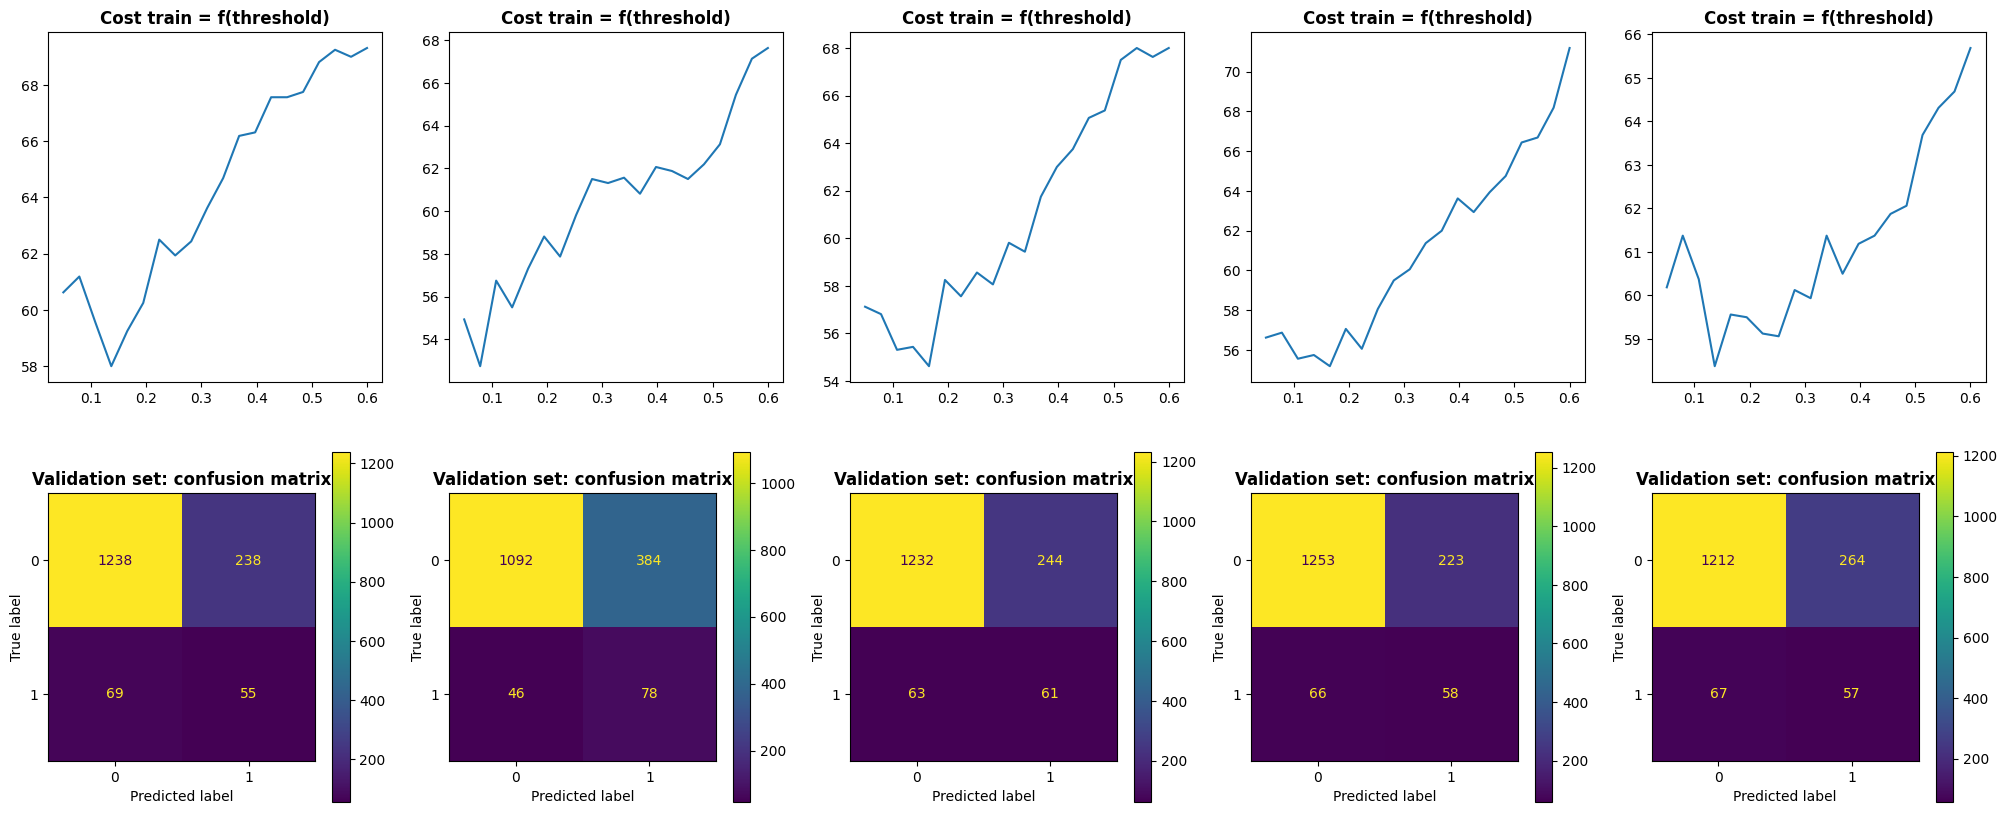

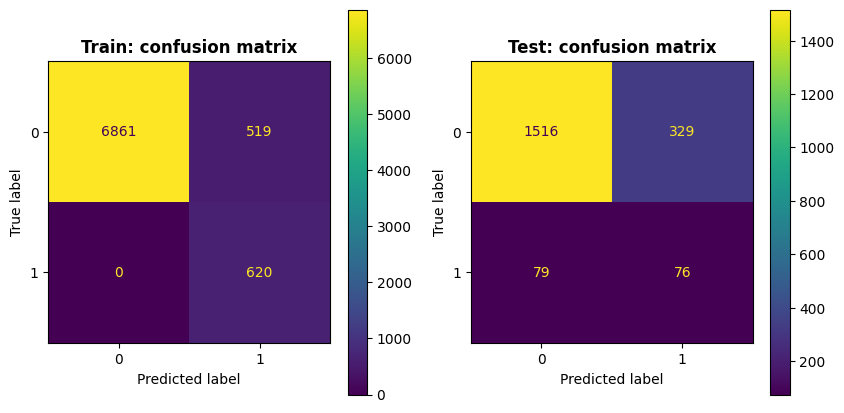

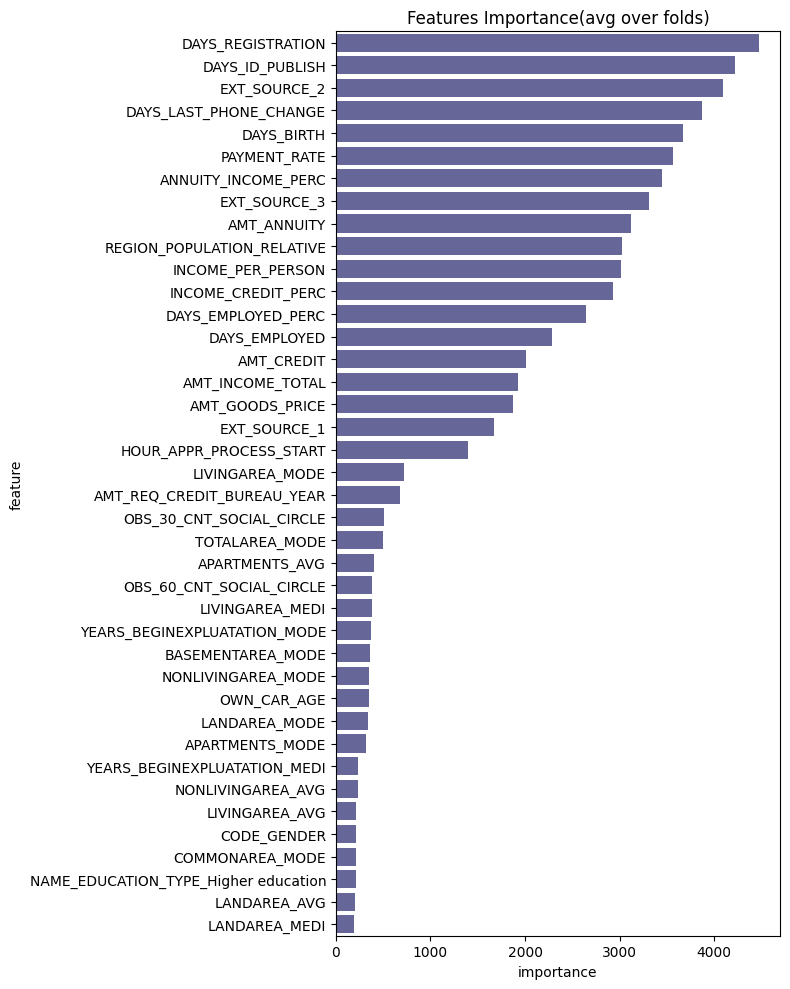

In [159]:
model4(df_10000)

## lightgbm with smote 

In [160]:
from imblearn.over_sampling import SMOTE, KMeansSMOTE, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

def lightgbm_smote(df, num_folds, stratified = False):
    
    X_train, X_test, y_train, y_test  = split(df)
    
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=42)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=42)
   
    features = [f for f in X_train.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    feature_importance_df = pd.DataFrame()
    result = []
    result_validation_set = pd.DataFrame()
    
    fig, ax = plt.subplots(2, num_folds, figsize=(num_folds*5, 10))
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train[features], y_train)):
        train_x, train_y = X_train[features].iloc[train_idx], y_train.iloc[train_idx]
        valid_x, valid_y = X_train[features].iloc[valid_idx], y_train.iloc[valid_idx]
        
        imp = SimpleImputer(strategy='median')
        scl = MinMaxScaler()
        over = SMOTE(random_state=42, sampling_strategy=0.6, k_neighbors=3)
        under = RandomUnderSampler(random_state=42, sampling_strategy=0.7)
        regressor = LGBMClassifier(
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=25,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=4,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            verbose=-1, )
        steps = [('imp', imp), ('scl', scl), ('over', over), ('under', under), ('model', regressor)]
        pipe = Pipeline(steps)
    
        pipe.fit(train_x, train_y)
    
    # Calcul des scores roc_auc pour valid et test
        valid_predict = pipe.predict_proba(valid_x)
        valid_predict_proba = [pred[1] for pred in valid_predict]
        valid_predict_proba_df = pd.DataFrame(valid_predict_proba)
        
        param = np.linspace(0.05, 0.6, 20)
        cost = []
        
        for i in param: 
            valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>i else 0)
            cm_valid = confusion_matrix(valid_y, valid_predict_class)
            cost += [(10*cm_valid[1][0] + cm_valid[0][1])/len(valid_y)*100]
        sns.lineplot(ax=ax[0][n_fold], x=param, y=cost)
        ax[0][n_fold].set_title('Cost train = f(threshold)', weight='bold')
    
        # Construction des matrices de confusion avec le meilleur threshold
        best_param = param[cost.index(min(cost))]
        print(f"Threshold optimum: {best_param}")
        result += [best_param]
        valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>best_param else 0)
        cm_valid = confusion_matrix(valid_y, valid_predict_class)
        confusion_valid = ConfusionMatrixDisplay(cm_valid)
        confusion_valid.plot(ax=ax[1][n_fold])
        confusion_valid.ax_.set_title('Validation set: confusion matrix', weight='bold')
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = features
        fold_importance_df["importance"] = pipe['model'].feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        feature_importance_df["importance"] = feature_importance_df["importance"].apply(lambda x: abs(x))
        
        results_valid = [accuracy_score(valid_y, valid_predict_class),
                    (10*cm_valid[1][0] + cm_valid[0][1])/len(valid_x)*100,
                    f1_score(valid_y, valid_predict_class),
                    precision_score(valid_y, valid_predict_class),
                    (cm_valid[0][0]-(10*cm_valid[1][0] ))/len(valid_x)*100,
                    recall_score(valid_y, valid_predict_class),
                    roc_auc_score(valid_y, valid_predict_proba)] 
        result_validation_set['n_fold'] = results_valid
    result_validation = list(result_validation_set.mean(axis=1))
        
    best_threshold = np.array(result).mean()
    print(f"Threshold optimum - Mean: {best_threshold}")

    imp = SimpleImputer(strategy='median')
    scl = MinMaxScaler()
    over = SMOTE(random_state=42, sampling_strategy=0.4, k_neighbors=3)
    under = RandomUnderSampler(random_state=42, sampling_strategy=0.6)
    regressor = regressor = LGBMClassifier(
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            verbose=-1, )
    steps = [('imp', imp), ('scl', scl), ('over', over), ('under', under), ('model', regressor)]
    pipe = Pipeline(steps)
    pipe.fit(X_train, y_train)
    
    train_predict = pipe.predict_proba(X_train)
    train_predict_proba = [pred[1] for pred in train_predict]
    train_predict_proba_df = pd.DataFrame(train_predict_proba)
    train_predict_class = train_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    test_predict = pipe.predict_proba(X_test)
    test_predict_proba = [pred[1] for pred in test_predict]
    test_predict_proba_df = pd.DataFrame(test_predict_proba)
    test_predict_class = test_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    
    cm_train = confusion_matrix(y_train, train_predict_class)
    confusion_train = ConfusionMatrixDisplay(cm_train)
    cm_test = confusion_matrix(y_test, test_predict_class)
    confusion_test = ConfusionMatrixDisplay(cm_test)
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    confusion_train.plot(ax=ax[0])
    confusion_train.ax_.set_title('Train: confusion matrix', weight='bold')
    confusion_test.plot(ax=ax[1])
    confusion_test.ax_.set_title('Test: confusion matrix', weight='bold')
    
    results_test = [accuracy_score(y_test, test_predict_class),
                    (10*cm_test[1][0] + cm_test[0][1])/len(X_test)*100,
                    f1_score(y_test, test_predict_class),
                    precision_score(y_test, test_predict_class),
                    (cm_test[0][0]-(10*cm_test[1][0] ))/len(X_test)*100,
                    recall_score(y_test, test_predict_class),
                    roc_auc_score(y_test, test_predict_proba)] 
    results_train = [accuracy_score(y_train, train_predict_class),
                    (10*cm_train[1][0] + cm_train[0][1])/len(X_train)*100,
                    f1_score(y_train, train_predict_class),
                    precision_score(y_train, train_predict_class),
                    (cm_train[0][0]-(10*cm_train[1][0] ))/len(X_train)*100,
                    recall_score(y_train, train_predict_class),
                    roc_auc_score(y_train, train_predict_proba)] 
    print(score_df(results_train, result_validation, results_test))
   
    display_importances(feature_importance_df) 

In [161]:
def model4_bis(df, num_folds=5, stratified = True):
    with timer("Run lightgbm with smote"):
        lightgbm_smote(df, num_folds=5, stratified=True)

Threshold optimum: 0.13684210526315788
Threshold optimum: 0.07894736842105263
Threshold optimum: 0.10789473684210527
Threshold optimum: 0.07894736842105263
Threshold optimum: 0.05
Threshold optimum - Mean: 0.09052631578947369
           Validation      Train       Test
Accuracy     0.691875   0.883375   0.759500
Cost        58.937500  11.662500  55.100000
F1_score     0.230889   0.570640   0.263400
Precision    0.143133   0.399227   0.172691
Profit      33.312500  80.587500  37.150000
Recall       0.596774   1.000000   0.554839
roc_auc      0.693756   0.997236   0.715049
Run lightgbm with smote - done in 140s


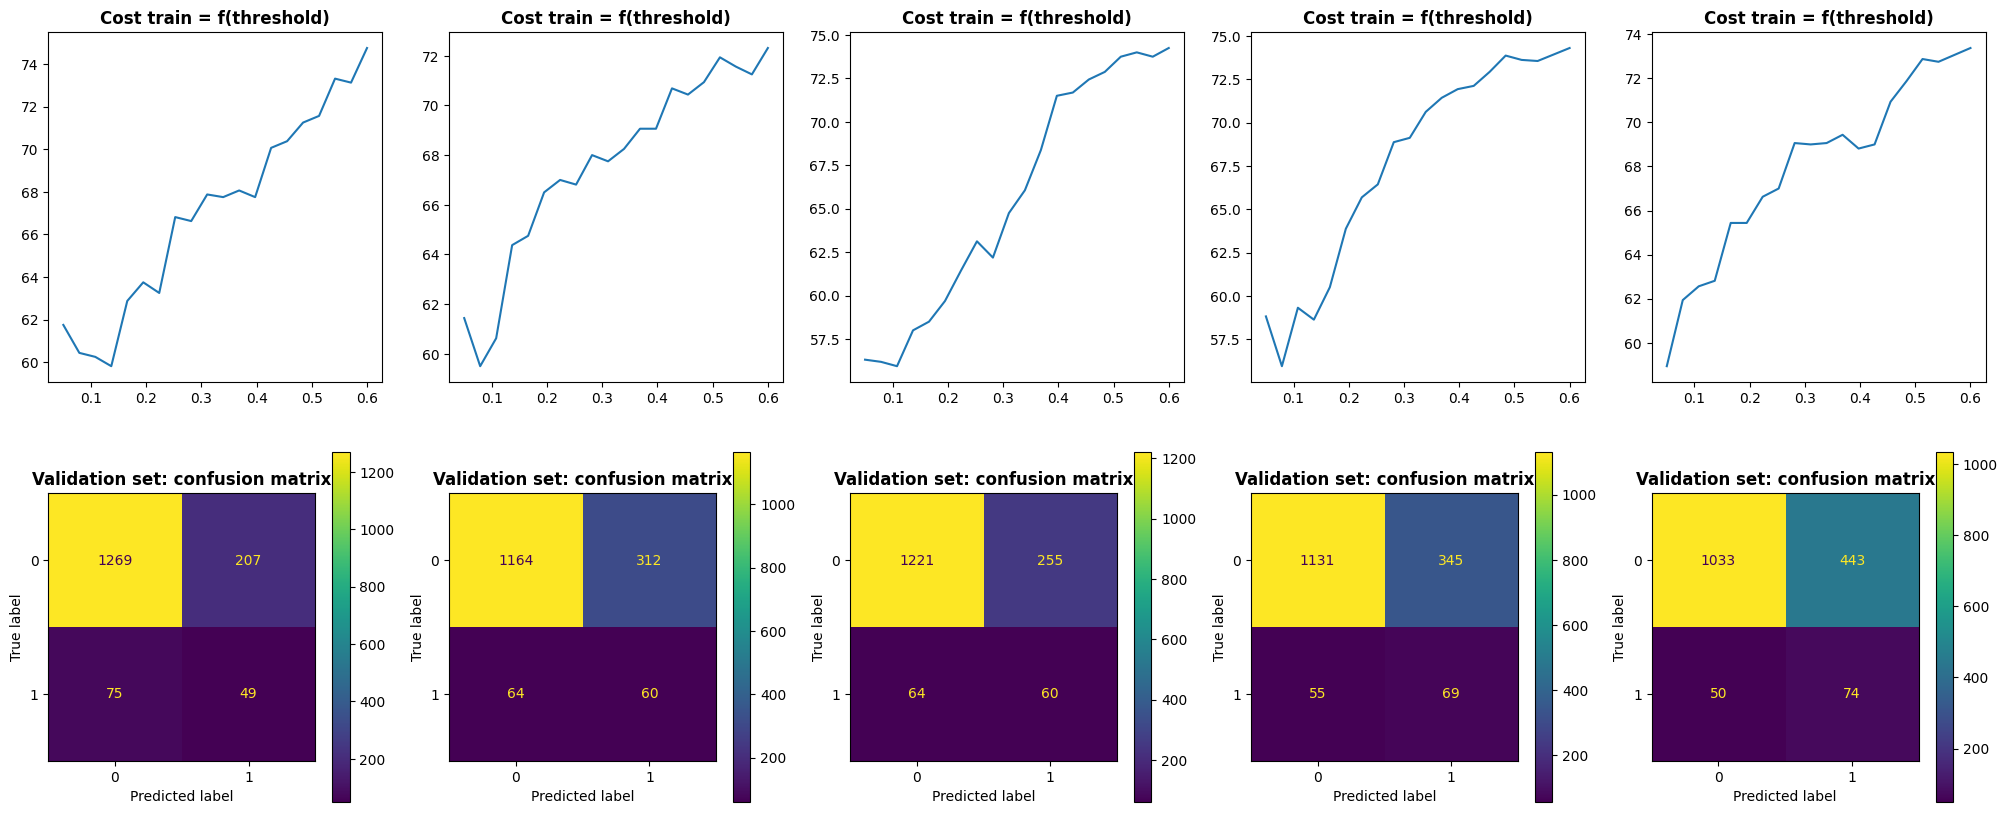

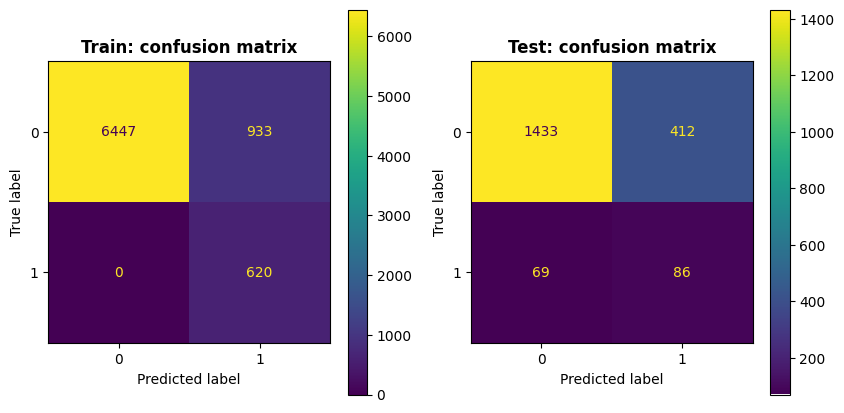

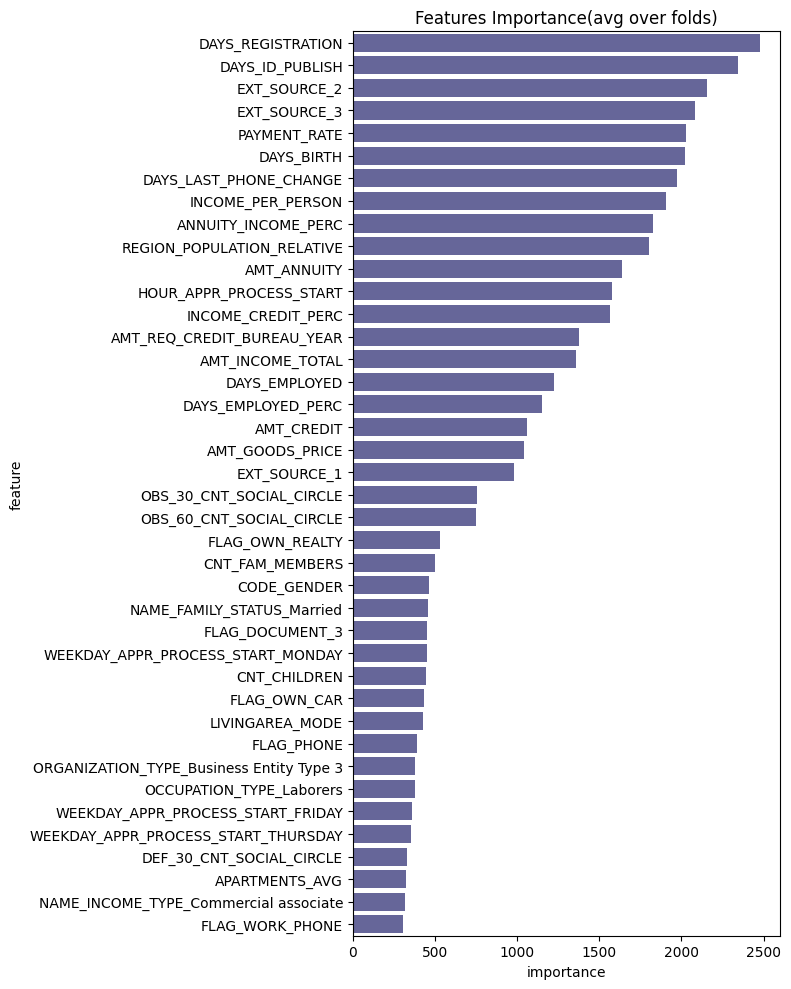

In [162]:
model4_bis(df_10000)

In [84]:
# Important overfitting

## lightgbm calibrated 

In [163]:
from sklearn.calibration import CalibratedClassifierCV
def lightgbm_calibrated(df, num_folds, stratified = False):
    
    X_train, X_test, y_train, y_test  = split(df)
    
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=42)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=42)
   
    features = [f for f in X_train.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    feature_importance_df = pd.DataFrame()
    result = []
    result_validation_set = pd.DataFrame()
    
    fig, ax = plt.subplots(2, num_folds, figsize=(num_folds*5, 10))
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train[features], y_train)):
        train_x, train_y = X_train[features].iloc[train_idx], y_train.iloc[train_idx]
        valid_x, valid_y = X_train[features].iloc[valid_idx], y_train.iloc[valid_idx]
        
        imp = SimpleImputer(strategy='median')
        scl = MinMaxScaler()
        regressor = LGBMClassifier(
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            verbose=-1, )
        regressor_calibrated = CalibratedClassifierCV(regressor, method='isotonic', cv=3)
        
        steps = [('imp', imp), ('scl', scl), ('model', regressor_calibrated)]
        pipe = Pipeline(steps)
    
        pipe.fit(train_x, train_y)
    
    # Calcul des scores roc_auc pour valid et test
        valid_predict = pipe.predict_proba(valid_x)
        valid_predict_proba = [pred[1] for pred in valid_predict]
        valid_predict_proba_df = pd.DataFrame(valid_predict_proba)
        
        param = np.linspace(0.05, 0.6, 20)
        cost = []
        
        for i in param: 
            valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>i else 0)
            cm_valid = confusion_matrix(valid_y, valid_predict_class)
            cost += [(10*cm_valid[1][0] + cm_valid[0][1])/len(valid_y)*100]
        sns.lineplot(ax=ax[0][n_fold], x=param, y=cost)
        ax[0][n_fold].set_title('Cost train = f(threshold)', weight='bold')
    
        # Construction des matrices de confusion avec le meilleur threshold
        best_param = param[cost.index(min(cost))]
        print(f"Threshold optimum: {best_param}")
        result += [best_param]
        valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>best_param else 0)
        cm_valid = confusion_matrix(valid_y, valid_predict_class)
        confusion_valid = ConfusionMatrixDisplay(cm_valid)
        confusion_valid.plot(ax=ax[1][n_fold])
        confusion_valid.ax_.set_title('Validation set: confusion matrix', weight='bold')
        
        results_valid = [accuracy_score(valid_y, valid_predict_class),
                    (10*cm_valid[1][0] + cm_valid[0][1])/len(valid_x)*100,
                    f1_score(valid_y, valid_predict_class),
                    precision_score(valid_y, valid_predict_class),
                    (cm_valid[0][0]-(10*cm_valid[1][0] ))/len(valid_x)*100,
                    recall_score(valid_y, valid_predict_class),
                    roc_auc_score(valid_y, valid_predict_proba)] 
        result_validation_set['n_fold'] = results_valid
    result_validation = list(result_validation_set.mean(axis=1))
        

    best_threshold = np.array(result).mean()
    print(f"Threshold optimum - Mean: {best_threshold}")

    imp = SimpleImputer(strategy='median')
    scl = MinMaxScaler()
    regressor = LGBMClassifier(
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            verbose=-1, )
    regressor_calibrated = CalibratedClassifierCV(regressor, method='isotonic', cv=3)
    steps = [('imp', imp), ('scl', scl), ('model', regressor_calibrated)]
    pipe = Pipeline(steps)
    
    pipe.fit(X_train, y_train)
    
    train_predict = pipe.predict_proba(X_train)
    train_predict_proba = [pred[1] for pred in train_predict]
    train_predict_proba_df = pd.DataFrame(train_predict_proba)
    train_predict_class = train_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    test_predict = pipe.predict_proba(X_test)
    test_predict_proba = [pred[1] for pred in test_predict]
    test_predict_proba_df = pd.DataFrame(test_predict_proba)
    test_predict_class = test_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    
    cm_train = confusion_matrix(y_train, train_predict_class)
    confusion_train = ConfusionMatrixDisplay(cm_train)
    cm_test = confusion_matrix(y_test, test_predict_class)
    confusion_test = ConfusionMatrixDisplay(cm_test)
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    confusion_train.plot(ax=ax[0])
    confusion_train.ax_.set_title('Train: confusion matrix', weight='bold')
    confusion_test.plot(ax=ax[1])
    confusion_test.ax_.set_title('Test: confusion matrix', weight='bold')
    
    results_test = [accuracy_score(y_test, test_predict_class),
                    (10*cm_test[1][0] + cm_test[0][1])/len(X_test)*100,
                    f1_score(y_test, test_predict_class),
                    precision_score(y_test, test_predict_class),
                    (cm_test[0][0]-(10*cm_test[1][0] ))/len(X_test)*100,
                    recall_score(y_test, test_predict_class),
                    roc_auc_score(y_test, test_predict_proba)] 
    results_train = [accuracy_score(y_train, train_predict_class),
                    (10*cm_train[1][0] + cm_train[0][1])/len(X_train)*100,
                    f1_score(y_train, train_predict_class),
                    precision_score(y_train, train_predict_class),
                    (cm_train[0][0]-(10*cm_train[1][0] ))/len(X_train)*100,
                    recall_score(y_train, train_predict_class),
                    roc_auc_score(y_train, train_predict_proba)] 
    print(score_df(results_train, result_validation,  results_test))
    

In [165]:
def model4_qua(df, num_folds=5, stratified = True):
    with timer("Run lightgbm_calibrated"):
        lightgbm_calibrated(df, num_folds=5, stratified=True)

Threshold optimum: 0.10789473684210527
Threshold optimum: 0.07894736842105263
Threshold optimum: 0.07894736842105263
Threshold optimum: 0.10789473684210527
Threshold optimum: 0.07894736842105263
Threshold optimum - Mean: 0.09052631578947368
           Validation      Train       Test
Accuracy     0.693750   0.816000   0.725000
Cost        57.062500  18.512500  54.050000
F1_score     0.239130   0.456827   0.258760
Precision    0.148077   0.296172   0.163543
Profit      35.187500  73.737500  38.200000
Recall       0.620968   0.998387   0.619355
roc_auc      0.704839   0.993953   0.720995
Run lightgbm_calibrated - done in 257s


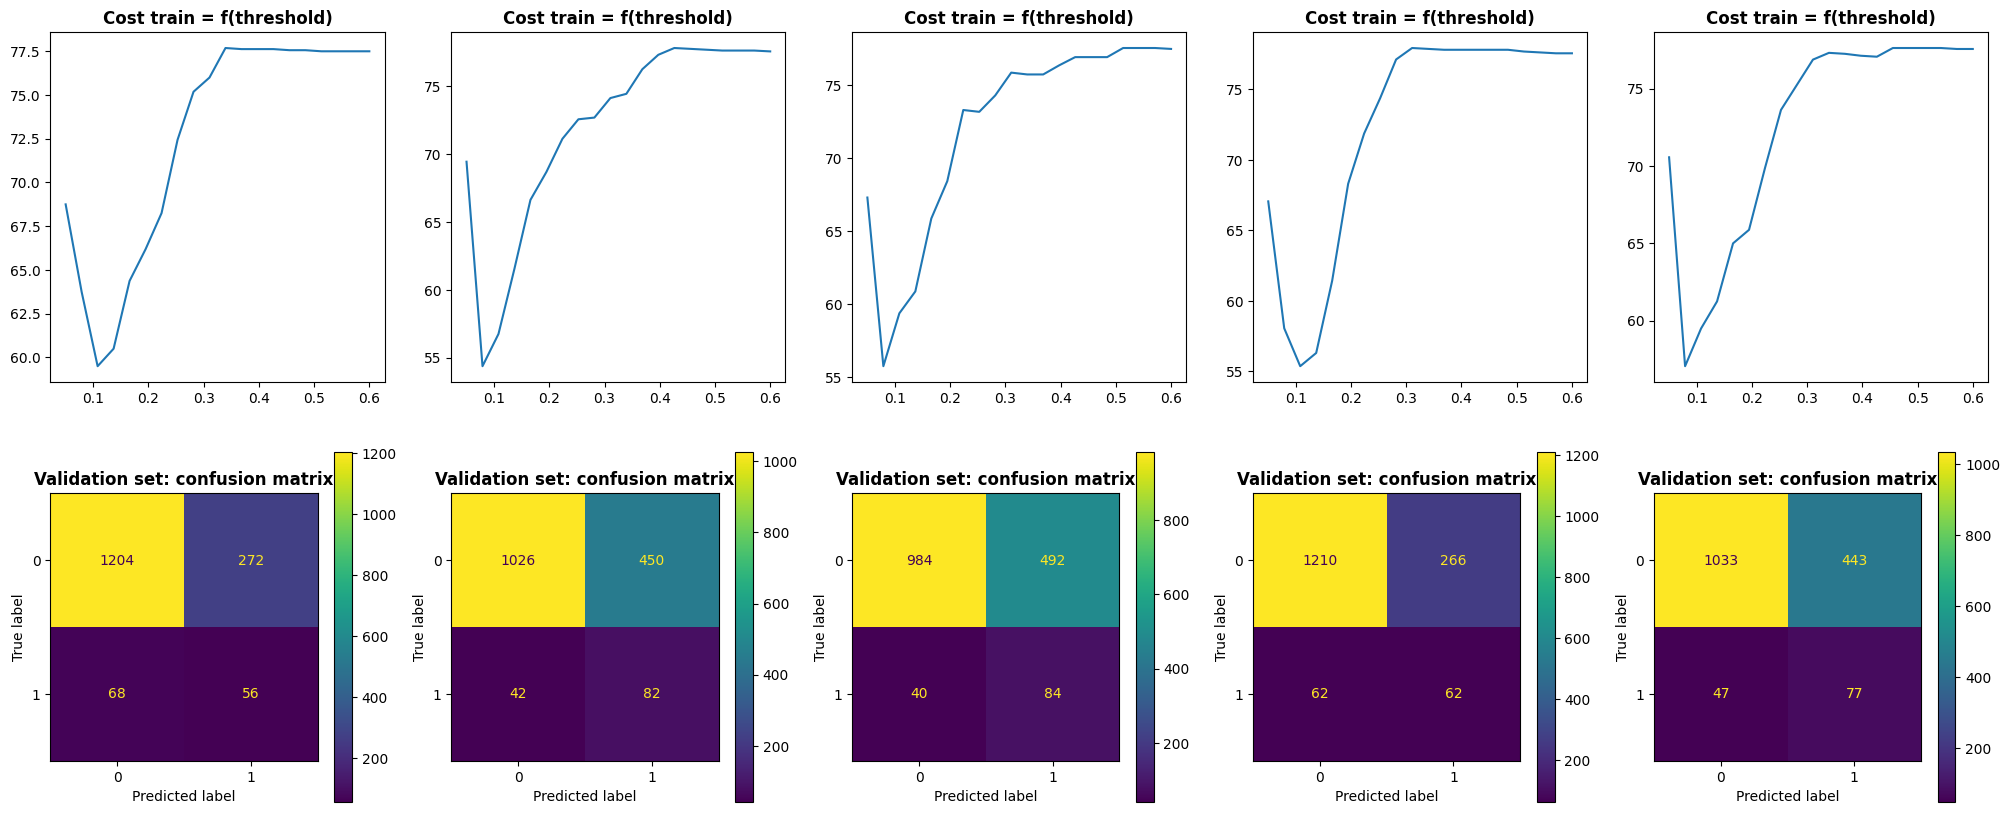

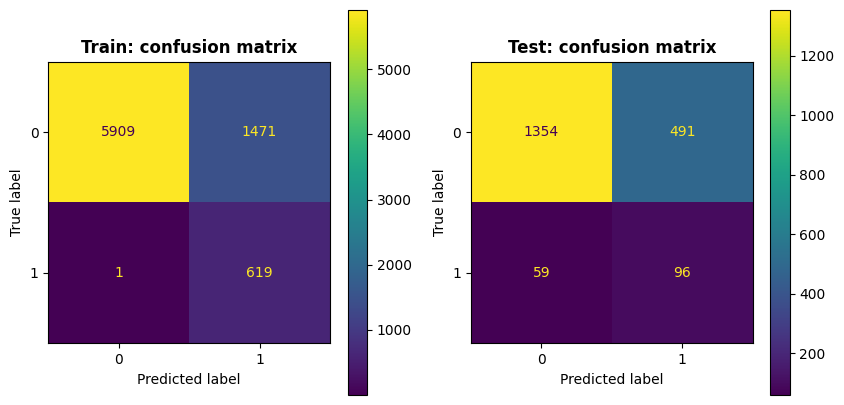

In [166]:
model4_qua(df_10000)

# SVM

In [173]:
def SVC_calibrated(df, num_folds, stratified = False):
    from sklearn.svm import SVC
    from sklearn.calibration import CalibratedClassifierCV
    
    X_train, X_test, y_train, y_test  = split(df)
    
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=42)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=42)
   
    features = [f for f in X_train.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    feature_importance_df = pd.DataFrame()
    result = []
    result_validation_set = pd.DataFrame()
    
    fig, ax = plt.subplots(2, num_folds, figsize=(num_folds*5, 10))
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train[features], y_train)):
        train_x, train_y = X_train[features].iloc[train_idx], y_train.iloc[train_idx]
        valid_x, valid_y = X_train[features].iloc[valid_idx], y_train.iloc[valid_idx]
        
        imp = SimpleImputer(strategy='median')
        scl = MinMaxScaler()
        regressor = SVC(kernel='linear', 
                    degree=2, 
                    gamma='scale',  
                    probability=False, 
                    tol=0.001,  
                    random_state=41)
        regressor_calibrated = CalibratedClassifierCV(regressor, method='isotonic', cv=3)
        steps = [('imp', imp), ('scl', scl), ('model', regressor_calibrated)]
        pipe = Pipeline(steps)
        pipe.fit(train_x, train_y)
    
        # Calcul des scores roc_auc pour valid et test
        valid_predict = pipe.predict_proba(valid_x)
        valid_predict_proba = [pred[1] for pred in valid_predict]
        valid_predict_proba_df = pd.DataFrame(valid_predict_proba)
        
        param = np.linspace(0.05, 0.6, 20)
        cost = []
        
        for i in param: 
            valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>i else 0)
            cm_valid = confusion_matrix(valid_y, valid_predict_class)
            cost += [(10*cm_valid[1][0] + cm_valid[0][1])/len(valid_y)*100]
        sns.lineplot(ax=ax[0][n_fold], x=param, y=cost)
        ax[0][n_fold].set_title('Cost train = f(threshold)', weight='bold')
    
        # Construction des matrices de confusion avec le meilleur threshold
        best_param = param[cost.index(min(cost))]
        print(f"Threshold optimum: {best_param}")
        result += [best_param]
        valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>best_param else 0)
        cm_valid = confusion_matrix(valid_y, valid_predict_class)
        confusion_valid = ConfusionMatrixDisplay(cm_valid)
        confusion_valid.plot(ax=ax[1][n_fold])
        confusion_valid.ax_.set_title('Validation set: confusion matrix', weight='bold')
        
        results_valid = [accuracy_score(valid_y, valid_predict_class),
                    (10*cm_valid[1][0] + cm_valid[0][1])/len(valid_x)*100,
                    f1_score(valid_y, valid_predict_class),
                    precision_score(valid_y, valid_predict_class),
                    (cm_valid[0][0]-(10*cm_valid[1][0] ))/len(valid_x)*100,
                    recall_score(valid_y, valid_predict_class),
                    roc_auc_score(valid_y, valid_predict_proba)] 
        result_validation_set['n_fold'] = results_valid
    result_validation = list(result_validation_set.mean(axis=1))
        

    best_threshold = np.array(result).mean()
    print(f"Threshold optimum - Mean: {best_threshold}")
    
    imp = SimpleImputer(strategy='median')
    scl = MinMaxScaler()
    regressor = SVC(kernel='linear', 
                    degree=2, 
                    gamma='scale',  
                    probability=False, 
                    tol=0.001,  
                    random_state=41)
    regressor_calibrated = CalibratedClassifierCV(regressor, method='isotonic', cv=3)
    steps = [('imp', imp), ('scl', scl), ('model', regressor_calibrated)]
    pipe = Pipeline(steps)
    pipe.fit(X_train, y_train)
    joblib.dump(pipe, 'saved_SVC_calibrated_model.joblib')
    
    train_predict = pipe.predict_proba(X_train)
    train_predict_proba = [pred[1] for pred in train_predict]
    train_predict_proba_df = pd.DataFrame(train_predict_proba)
    train_predict_class = train_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    test_predict = pipe.predict_proba(X_test)
    test_predict_proba = [pred[1] for pred in test_predict]
    test_predict_proba_df = pd.DataFrame(test_predict_proba)
    test_predict_class = test_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    
    cm_train = confusion_matrix(y_train, train_predict_class)
    confusion_train = ConfusionMatrixDisplay(cm_train)
    cm_test = confusion_matrix(y_test, test_predict_class)
    confusion_test = ConfusionMatrixDisplay(cm_test)
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    confusion_train.plot(ax=ax[0])
    confusion_train.ax_.set_title('Train: confusion matrix', weight='bold')
    confusion_test.plot(ax=ax[1])
    confusion_test.ax_.set_title('Test: confusion matrix', weight='bold')
    
    results_test = [accuracy_score(y_test, test_predict_class),
                    (10*cm_test[1][0] + cm_test[0][1])/len(X_test)*100,
                    f1_score(y_test, test_predict_class),
                    precision_score(y_test, test_predict_class),
                    (cm_test[0][0]-(10*cm_test[1][0] ))/len(X_test)*100,
                    recall_score(y_test, test_predict_class),
                    roc_auc_score(y_test, test_predict_proba)] 
    results_train = [accuracy_score(y_train, train_predict_class),
                    (10*cm_train[1][0] + cm_train[0][1])/len(X_train)*100,
                    f1_score(y_train, train_predict_class),
                    precision_score(y_train, train_predict_class),
                    (cm_train[0][0]-(10*cm_train[1][0] ))/len(X_train)*100,
                    recall_score(y_train, train_predict_class),
                    roc_auc_score(y_train, train_predict_proba)] 
    print(score_df(results_train, result_validation, results_test))    

In [174]:
def model9(df, num_folds=5, stratified = True):
    with timer("Run SVC_calibrated"):
        SVC_calibrated(df, num_folds=5, stratified=True)

Threshold optimum: 0.07894736842105263
Threshold optimum: 0.07894736842105263
Threshold optimum: 0.07894736842105263
Threshold optimum: 0.07894736842105263
Threshold optimum: 0.10789473684210527
Threshold optimum - Mean: 0.08473684210526315
           Validation      Train       Test
Accuracy     0.895625   0.696625   0.674500
Cost        72.875000  59.925000  69.450000
F1_score     0.134715   0.227316   0.183187
Precision    0.188406   0.141610   0.113707
Profit      19.375000  32.325000  22.800000
Recall       0.104839   0.575806   0.470968
roc_auc      0.606940   0.697318   0.595594
Run SVC_calibrated - done in 104s


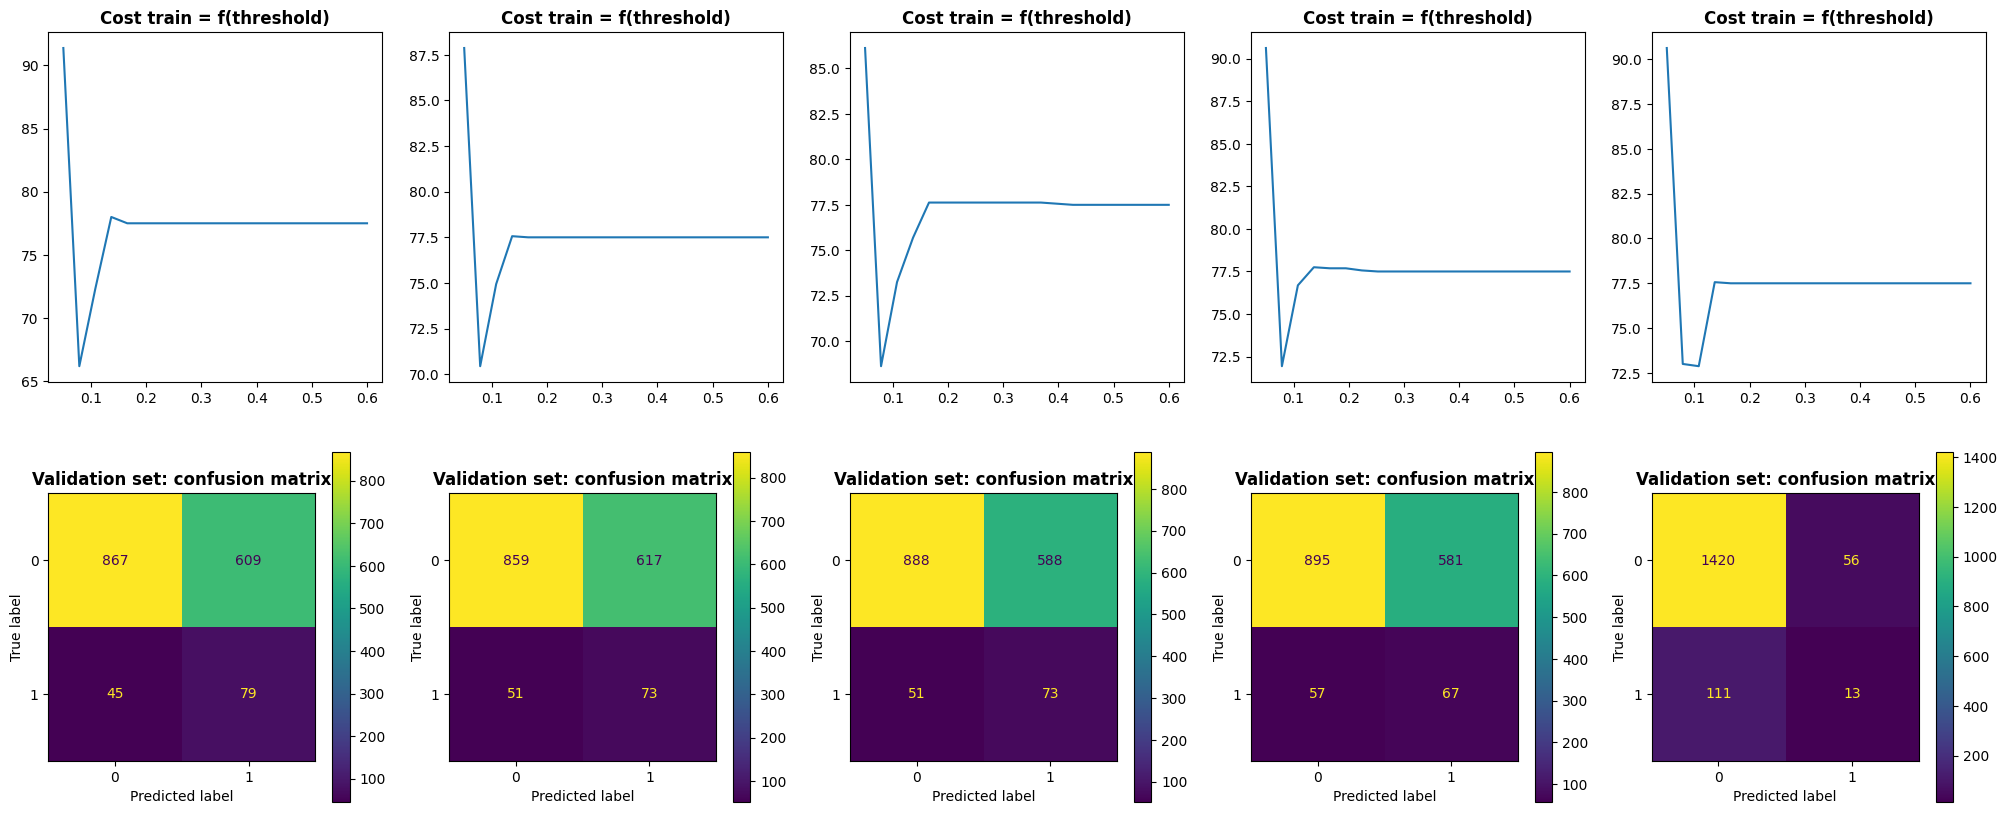

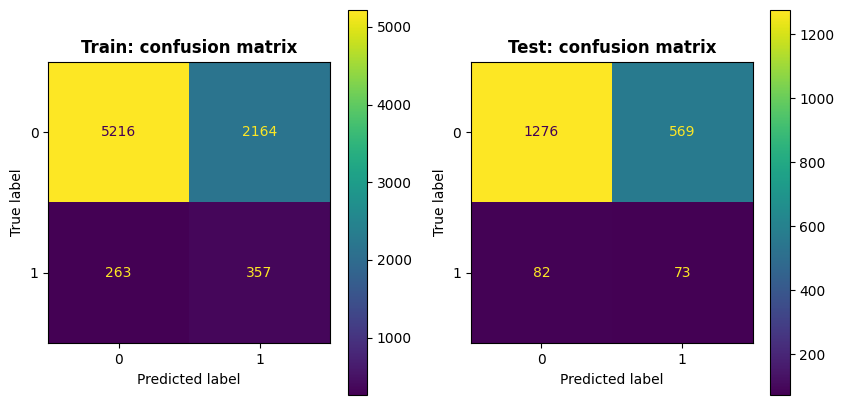

In [175]:
model9(df_10000)

In [176]:
import shap
import random
def SVC_rbf(df, num_folds, stratified = False):
    from sklearn.svm import SVC
    from sklearn.calibration import CalibratedClassifierCV
    
    X_train, X_test, y_train, y_test  = split(df)
    
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=42)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=42)
   
    features = [f for f in X_train.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    feature_importance_df = pd.DataFrame()
    result = []
    result_validation_set = pd.DataFrame()
    
    fig, ax = plt.subplots(2, num_folds, figsize=(num_folds*5, 10))
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train[features], y_train)):
        train_x, train_y = X_train[features].iloc[train_idx], y_train.iloc[train_idx]
        valid_x, valid_y = X_train[features].iloc[valid_idx], y_train.iloc[valid_idx]
        
        imp = SimpleImputer(strategy='median')
        scl = MinMaxScaler()
        regressor = SVC(kernel='rbf', 
                    degree=2, 
                    gamma='scale',  
                    probability=False, 
                    tol=0.001,  
                    random_state=41)
        regressor_calibrated = CalibratedClassifierCV(regressor, method='isotonic', cv=3)
        steps = [('imp', imp), ('scl', scl), ('model', regressor_calibrated)]
        pipe = Pipeline(steps)
        pipe.fit(train_x, train_y)
    
        # Calcul des scores roc_auc pour valid et test
        valid_predict = pipe.predict_proba(valid_x)
        valid_predict_proba = [pred[1] for pred in valid_predict]
        valid_predict_proba_df = pd.DataFrame(valid_predict_proba)
        
        param = np.linspace(0.05, 0.6, 20)
        cost = []
        
        for i in param: 
            valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>i else 0)
            cm_valid = confusion_matrix(valid_y, valid_predict_class)
            cost += [(10*cm_valid[1][0] + cm_valid[0][1])/len(valid_y)*100]
        sns.lineplot(ax=ax[0][n_fold], x=param, y=cost)
        ax[0][n_fold].set_title('Cost train = f(threshold)', weight='bold')
    
        # Construction des matrices de confusion avec le meilleur threshold
        best_param = param[cost.index(min(cost))]
        print(f"Threshold optimum: {best_param}")
        result += [best_param]
        valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>best_param else 0)
        cm_valid = confusion_matrix(valid_y, valid_predict_class)
        confusion_valid = ConfusionMatrixDisplay(cm_valid)
        confusion_valid.plot(ax=ax[1][n_fold])
        confusion_valid.ax_.set_title('Validation set: confusion matrix', weight='bold')
        
        results_valid = [accuracy_score(valid_y, valid_predict_class),
                    (10*cm_valid[1][0] + cm_valid[0][1])/len(valid_x)*100,
                    f1_score(valid_y, valid_predict_class),
                    precision_score(valid_y, valid_predict_class),
                    (cm_valid[0][0]-(10*cm_valid[1][0] ))/len(valid_x)*100,
                    recall_score(valid_y, valid_predict_class),
                    roc_auc_score(valid_y, valid_predict_proba)] 
        result_validation_set['n_fold'] = results_valid
    result_validation = list(result_validation_set.mean(axis=1))
        

    best_threshold = np.array(result).mean()
    print(f"Threshold optimum - Mean: {best_threshold}")
    
    imp = SimpleImputer(strategy='median')
    scl = MinMaxScaler()
    regressor = SVC(kernel='rbf', 
                    degree=2, 
                    gamma='scale',  
                    probability=False, 
                    tol=0.001,  
                    random_state=41)
    regressor_calibrated = CalibratedClassifierCV(regressor, method='isotonic', cv=3)
    steps = [('imp', imp), ('scl', scl), ('model', regressor_calibrated)]
    pipe = Pipeline(steps)
    pipe.fit(X_train, y_train)
    joblib.dump(pipe, 'SVC_rbf_model.joblib')
    
    train_predict = pipe.predict_proba(X_train)
    train_predict_proba = [pred[1] for pred in train_predict]
    train_predict_proba_df = pd.DataFrame(train_predict_proba)
    train_predict_class = train_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    test_predict = pipe.predict_proba(X_test)
    test_predict_proba = [pred[1] for pred in test_predict]
    test_predict_proba_df = pd.DataFrame(test_predict_proba)
    test_predict_class = test_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    
    cm_train = confusion_matrix(y_train, train_predict_class)
    confusion_train = ConfusionMatrixDisplay(cm_train)
    cm_test = confusion_matrix(y_test, test_predict_class)
    confusion_test = ConfusionMatrixDisplay(cm_test)
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    confusion_train.plot(ax=ax[0])
    confusion_train.ax_.set_title('Train: confusion matrix', weight='bold')
    confusion_test.plot(ax=ax[1])
    confusion_test.ax_.set_title('Test: confusion matrix', weight='bold')
    
    results_test = [accuracy_score(y_test, test_predict_class),
                    (10*cm_test[1][0] + cm_test[0][1])/len(X_test)*100,
                    f1_score(y_test, test_predict_class),
                    precision_score(y_test, test_predict_class),
                    (cm_test[0][0]-(10*cm_test[1][0] ))/len(X_test)*100,
                    recall_score(y_test, test_predict_class),
                    roc_auc_score(y_test, test_predict_proba)] 
    results_train = [accuracy_score(y_train, train_predict_class),
                    (10*cm_train[1][0] + cm_train[0][1])/len(X_train)*100,
                    f1_score(y_train, train_predict_class),
                    precision_score(y_train, train_predict_class),
                    (cm_train[0][0]-(10*cm_train[1][0] ))/len(X_train)*100,
                    recall_score(y_train, train_predict_class),
                    roc_auc_score(y_train, train_predict_proba)] 
    print(score_df(results_train, result_validation, results_test))
    

In [177]:
def model_SVC_rbf(df, num_folds=5, stratified = True):
    with timer("Run SVC_rbf"):
        SVC_rbf(df, num_folds=5, stratified=True)

Threshold optimum: 0.07894736842105263
Threshold optimum: 0.10789473684210527
Threshold optimum: 0.07894736842105263
Threshold optimum: 0.07894736842105263
Threshold optimum: 0.07894736842105263
Threshold optimum - Mean: 0.08473684210526315
           Validation      Train       Test
Accuracy     0.620625   0.813750   0.680500
Cost        59.312500  21.212500  58.950000
F1_score     0.220796   0.444858   0.229192
Precision    0.131298   0.289244   0.140950
Profit      32.937500  71.037500  33.300000
Recall       0.693548   0.962903   0.612903
roc_auc      0.712169   0.974911   0.666883
Run SVC_rbf - done in 99s


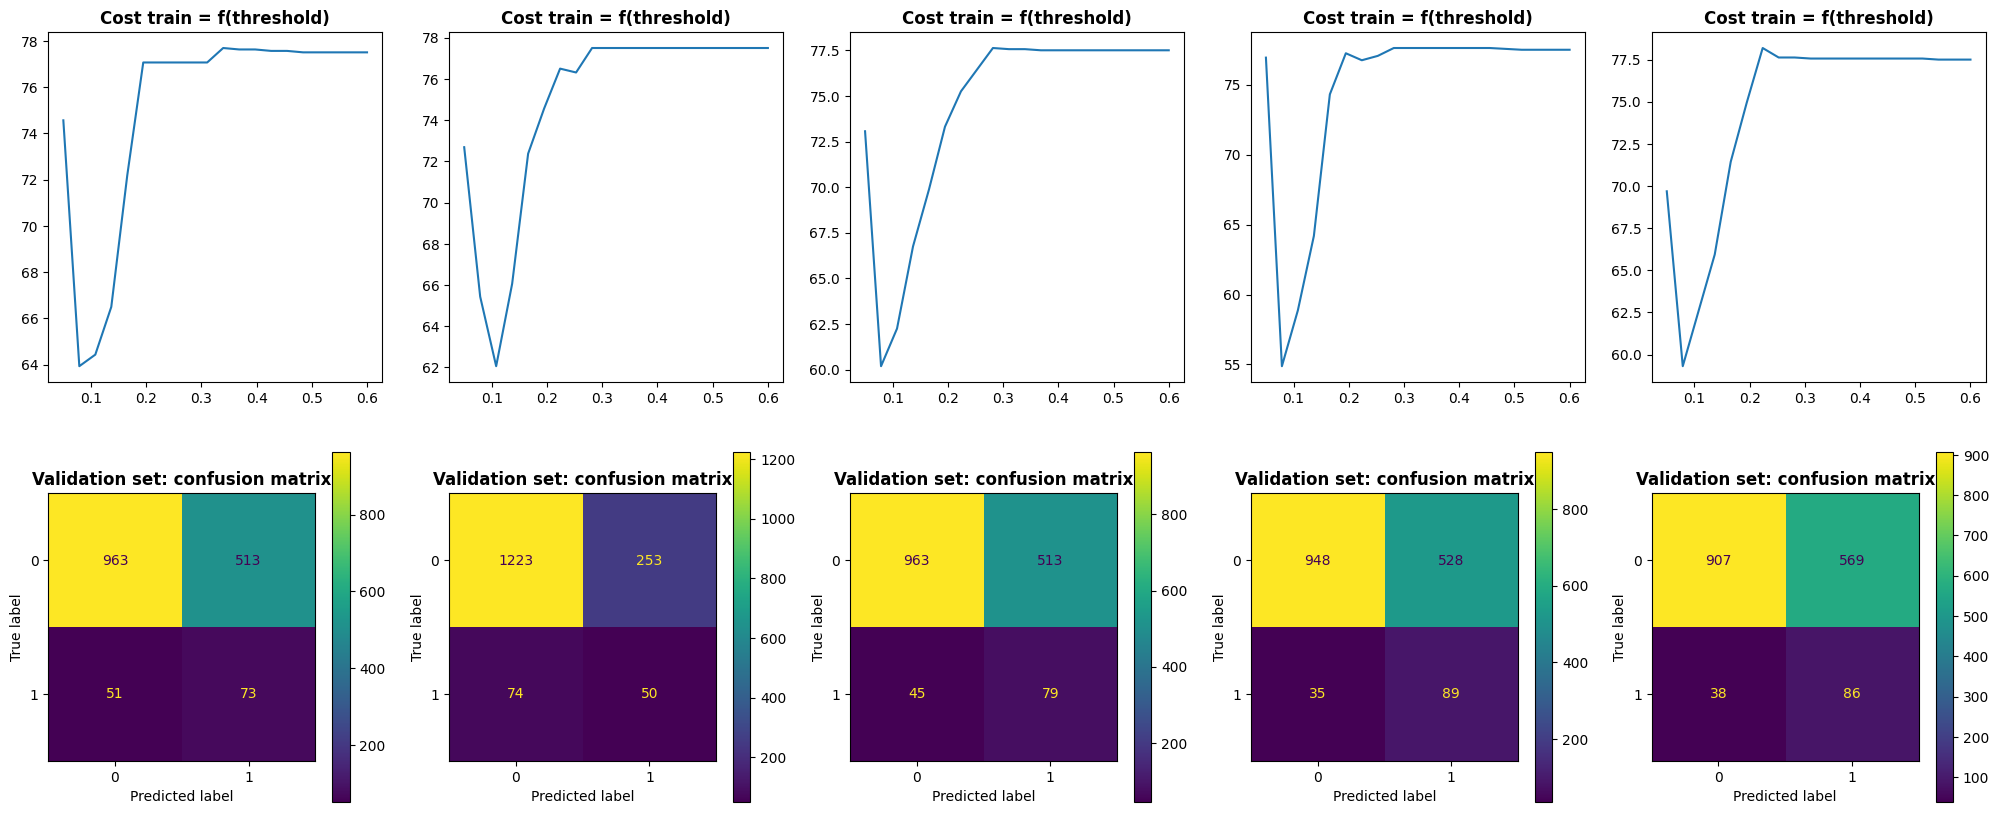

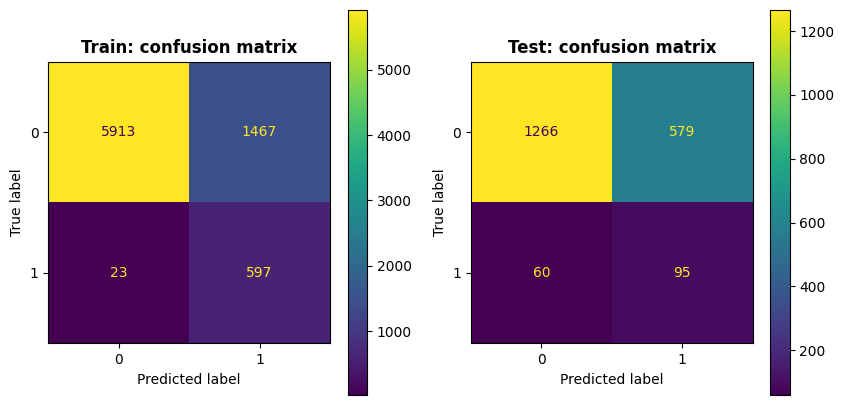

In [178]:
model_SVC_rbf(df_10000)

# Tree
## Decision Tree

In [179]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.tree import DecisionTreeClassifier

def Decision_Tree(df, num_folds, stratified = False):
    
    X_train, X_test, y_train, y_test  = split(df)
    
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=42)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=42)
   
    features = [f for f in X_train.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    feature_importance_df = pd.DataFrame()
    result = []
    result_validation_set = pd.DataFrame()
    
    fig, ax = plt.subplots(2, num_folds, figsize=(num_folds*5, 10))
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train[features], y_train)):
        train_x, train_y = X_train[features].iloc[train_idx], y_train.iloc[train_idx]
        valid_x, valid_y = X_train[features].iloc[valid_idx], y_train.iloc[valid_idx]
        
        imp = SimpleImputer(strategy='median')
        scl = MinMaxScaler()
        regressor = DecisionTreeClassifier(criterion='gini', 
                                       splitter='best', 
                                       max_depth=4, 
                                       min_samples_split=2, 
                                       min_samples_leaf=4, 
                                       min_weight_fraction_leaf=0.0, 
                                       max_features=None, 
                                       random_state=42, 
                                       max_leaf_nodes=None, 
                                       min_impurity_decrease=0.0, 
                                           class_weight='balanced')
            
        steps = [('imp', imp), ('scl', scl), ('model', regressor)]
        pipe = Pipeline(steps)
        pipe.fit(train_x, train_y)
        
    # Calcul des scores roc_auc pour valid et test
        valid_predict = pipe.predict_proba(valid_x)
        valid_predict_proba = [pred[1] for pred in valid_predict]
        valid_predict_proba_df = pd.DataFrame(valid_predict_proba)
        
        param = np.linspace(0.2, 0.7, 20)
        cost = []
        for i in param: 
            valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>i else 0)
            cm_valid = confusion_matrix(valid_y, valid_predict_class)
            cost += [(10*cm_valid[1][0] + cm_valid[0][1])/len(valid_y)*100]
        sns.lineplot(ax=ax[0][n_fold], x=param, y=cost)
        ax[0][n_fold].set_title('Cost train = f(threshold)', weight='bold')
    
        # Construction des matrices de confusion avec le meilleur threshold
        best_param = param[cost.index(min(cost))]
        print(f"Threshold optimum: {best_param}")
        result += [best_param]
        valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>best_param else 0)
        cm_valid = confusion_matrix(valid_y, valid_predict_class)
        confusion_valid = ConfusionMatrixDisplay(cm_valid)
        confusion_valid.plot(ax=ax[1][n_fold])
        confusion_valid.ax_.set_title('Validation set: confusion matrix', weight='bold')
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = features
        fold_importance_df["importance"] = pipe['model'].feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        feature_importance_df["importance"] = feature_importance_df["importance"].apply(lambda x: abs(x))
        results_valid = [accuracy_score(valid_y, valid_predict_class),
                    (10*cm_valid[1][0] + cm_valid[0][1])/len(valid_x)*100,
                    f1_score(valid_y, valid_predict_class),
                    precision_score(valid_y, valid_predict_class),
                    (cm_valid[0][0]-(10*cm_valid[1][0] ))/len(valid_x)*100,
                    recall_score(valid_y, valid_predict_class),
                    roc_auc_score(valid_y, valid_predict_proba)] 
        result_validation_set['n_fold'] = results_valid
    result_validation = list(result_validation_set.mean(axis=1))
        
        
    best_threshold = np.array(result).mean()
    print(f"Threshold optimum - Mean: {best_threshold}")
    
    imp = SimpleImputer(strategy='median')
    scl = MinMaxScaler()
    regressor = DecisionTreeClassifier(criterion='gini', 
                                       splitter='best', 
                                       max_depth=40, 
                                       min_samples_split=2, 
                                       min_samples_leaf=4, 
                                       min_weight_fraction_leaf=0.0, 
                                       max_features=None, 
                                       random_state=42, 
                                       max_leaf_nodes=None, 
                                       min_impurity_decrease=0.0, 
                                           class_weight='balanced')
    steps = [('imp', imp), ('scl', scl), ('model', regressor)]
    pipe = Pipeline(steps)
    pipe.fit(X_train, y_train)
    joblib.dump(pipe, 'Decision_Tree_model.joblib')
    
    train_predict = pipe.predict_proba(X_train)
    train_predict_proba = [pred[1] for pred in train_predict]
    train_predict_proba_df = pd.DataFrame(train_predict_proba)
    train_predict_class = train_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    test_predict = pipe.predict_proba(X_test)
    test_predict_proba = [pred[1] for pred in test_predict]
    test_predict_proba_df = pd.DataFrame(test_predict_proba)
    test_predict_class = test_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    
    cm_train = confusion_matrix(y_train, train_predict_class)
    confusion_train = ConfusionMatrixDisplay(cm_train)
    cm_test = confusion_matrix(y_test, test_predict_class)
    confusion_test = ConfusionMatrixDisplay(cm_test)
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    confusion_train.plot(ax=ax[0])
    confusion_train.ax_.set_title('Train: confusion matrix', weight='bold')
    confusion_test.plot(ax=ax[1])
    confusion_test.ax_.set_title('Test: confusion matrix', weight='bold')
    
    results_test = [accuracy_score(y_test, test_predict_class),
                    (10*cm_test[1][0] + cm_test[0][1])/len(X_test)*100,
                    f1_score(y_test, test_predict_class),
                    precision_score(y_test, test_predict_class),
                    (cm_test[0][0]-(10*cm_test[1][0] ))/len(X_test)*100,
                    recall_score(y_test, test_predict_class),
                    roc_auc_score(y_test, test_predict_proba)] 
    results_train = [accuracy_score(y_train, train_predict_class),
                    (10*cm_train[1][0] + cm_train[0][1])/len(X_train)*100,
                    f1_score(y_train, train_predict_class),
                    precision_score(y_train, train_predict_class),
                    (cm_train[0][0]-(10*cm_train[1][0] ))/len(X_train)*100,
                    recall_score(y_train, train_predict_class),
                    roc_auc_score(y_train, train_predict_proba)] 
    print(score_df(results_train, result_validation, results_test))
   
    display_importances(feature_importance_df) 
    
    

In [182]:
def model_decision_tree_balanced(df, num_folds=5, stratified = True):
    with timer("Run Decision Tree"):
        Decision_Tree(df, num_folds=5, stratified=True)

Threshold optimum: 0.5947368421052632
Threshold optimum: 0.5947368421052632
Threshold optimum: 0.4631578947368421
Threshold optimum: 0.5421052631578946
Threshold optimum: 0.5947368421052632
Threshold optimum - Mean: 0.5578947368421053
           Validation      Train       Test
Accuracy     0.743750   0.942625   0.816000
Cost        56.562500   5.737500  69.700000
F1_score     0.251825   0.729841   0.182222
Precision    0.162736   0.574606   0.138983
Profit      35.687500  86.512500  22.550000
Recall       0.556452   1.000000   0.264516
roc_auc      0.681137   0.991732   0.566168
Run Decision Tree - done in 5s


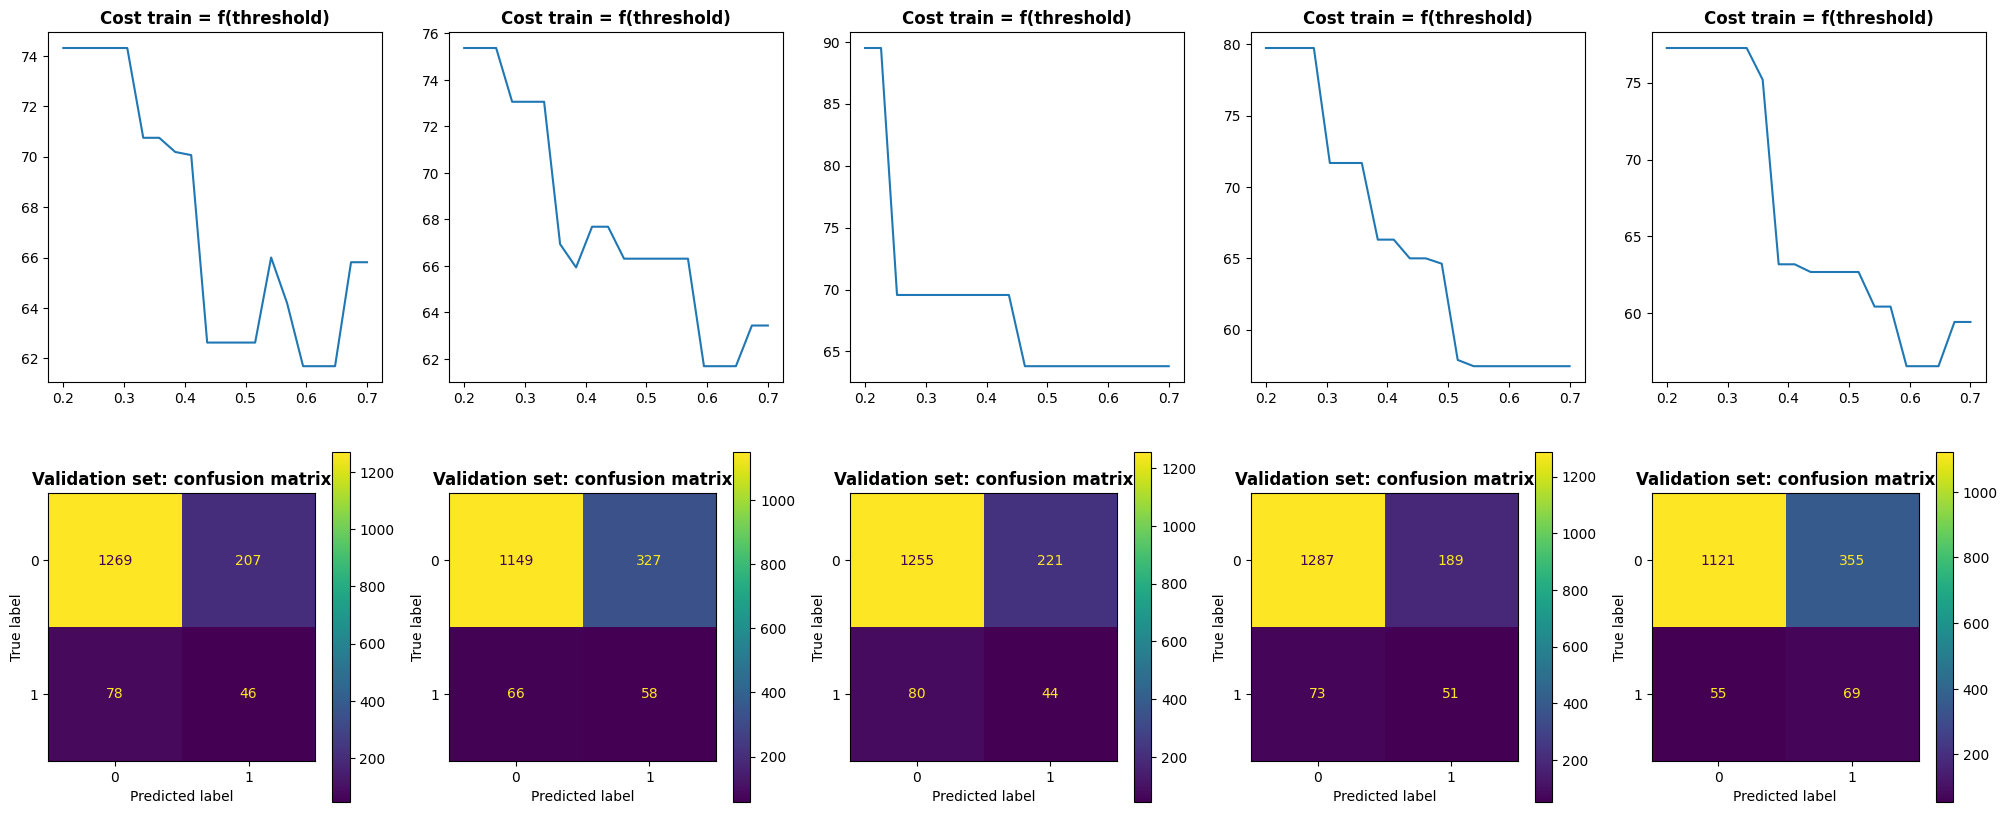

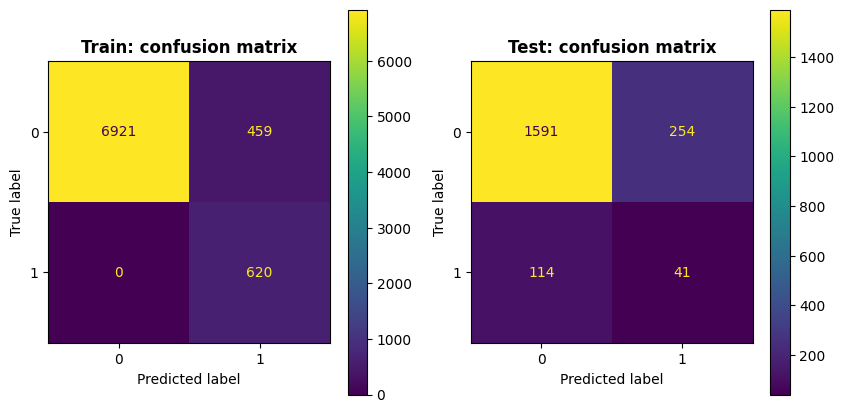

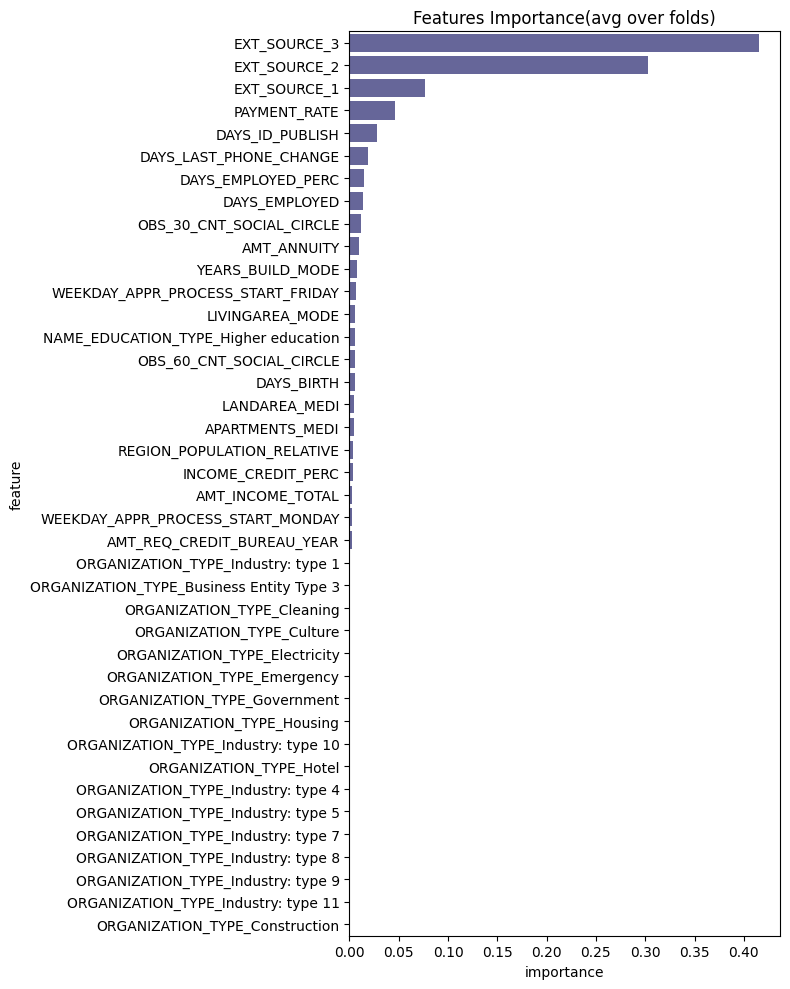

In [183]:
model_decision_tree_balanced(df_10000)

In [184]:
saved_Decision_Tree_model = joblib.load('Decision_Tree_model.joblib')

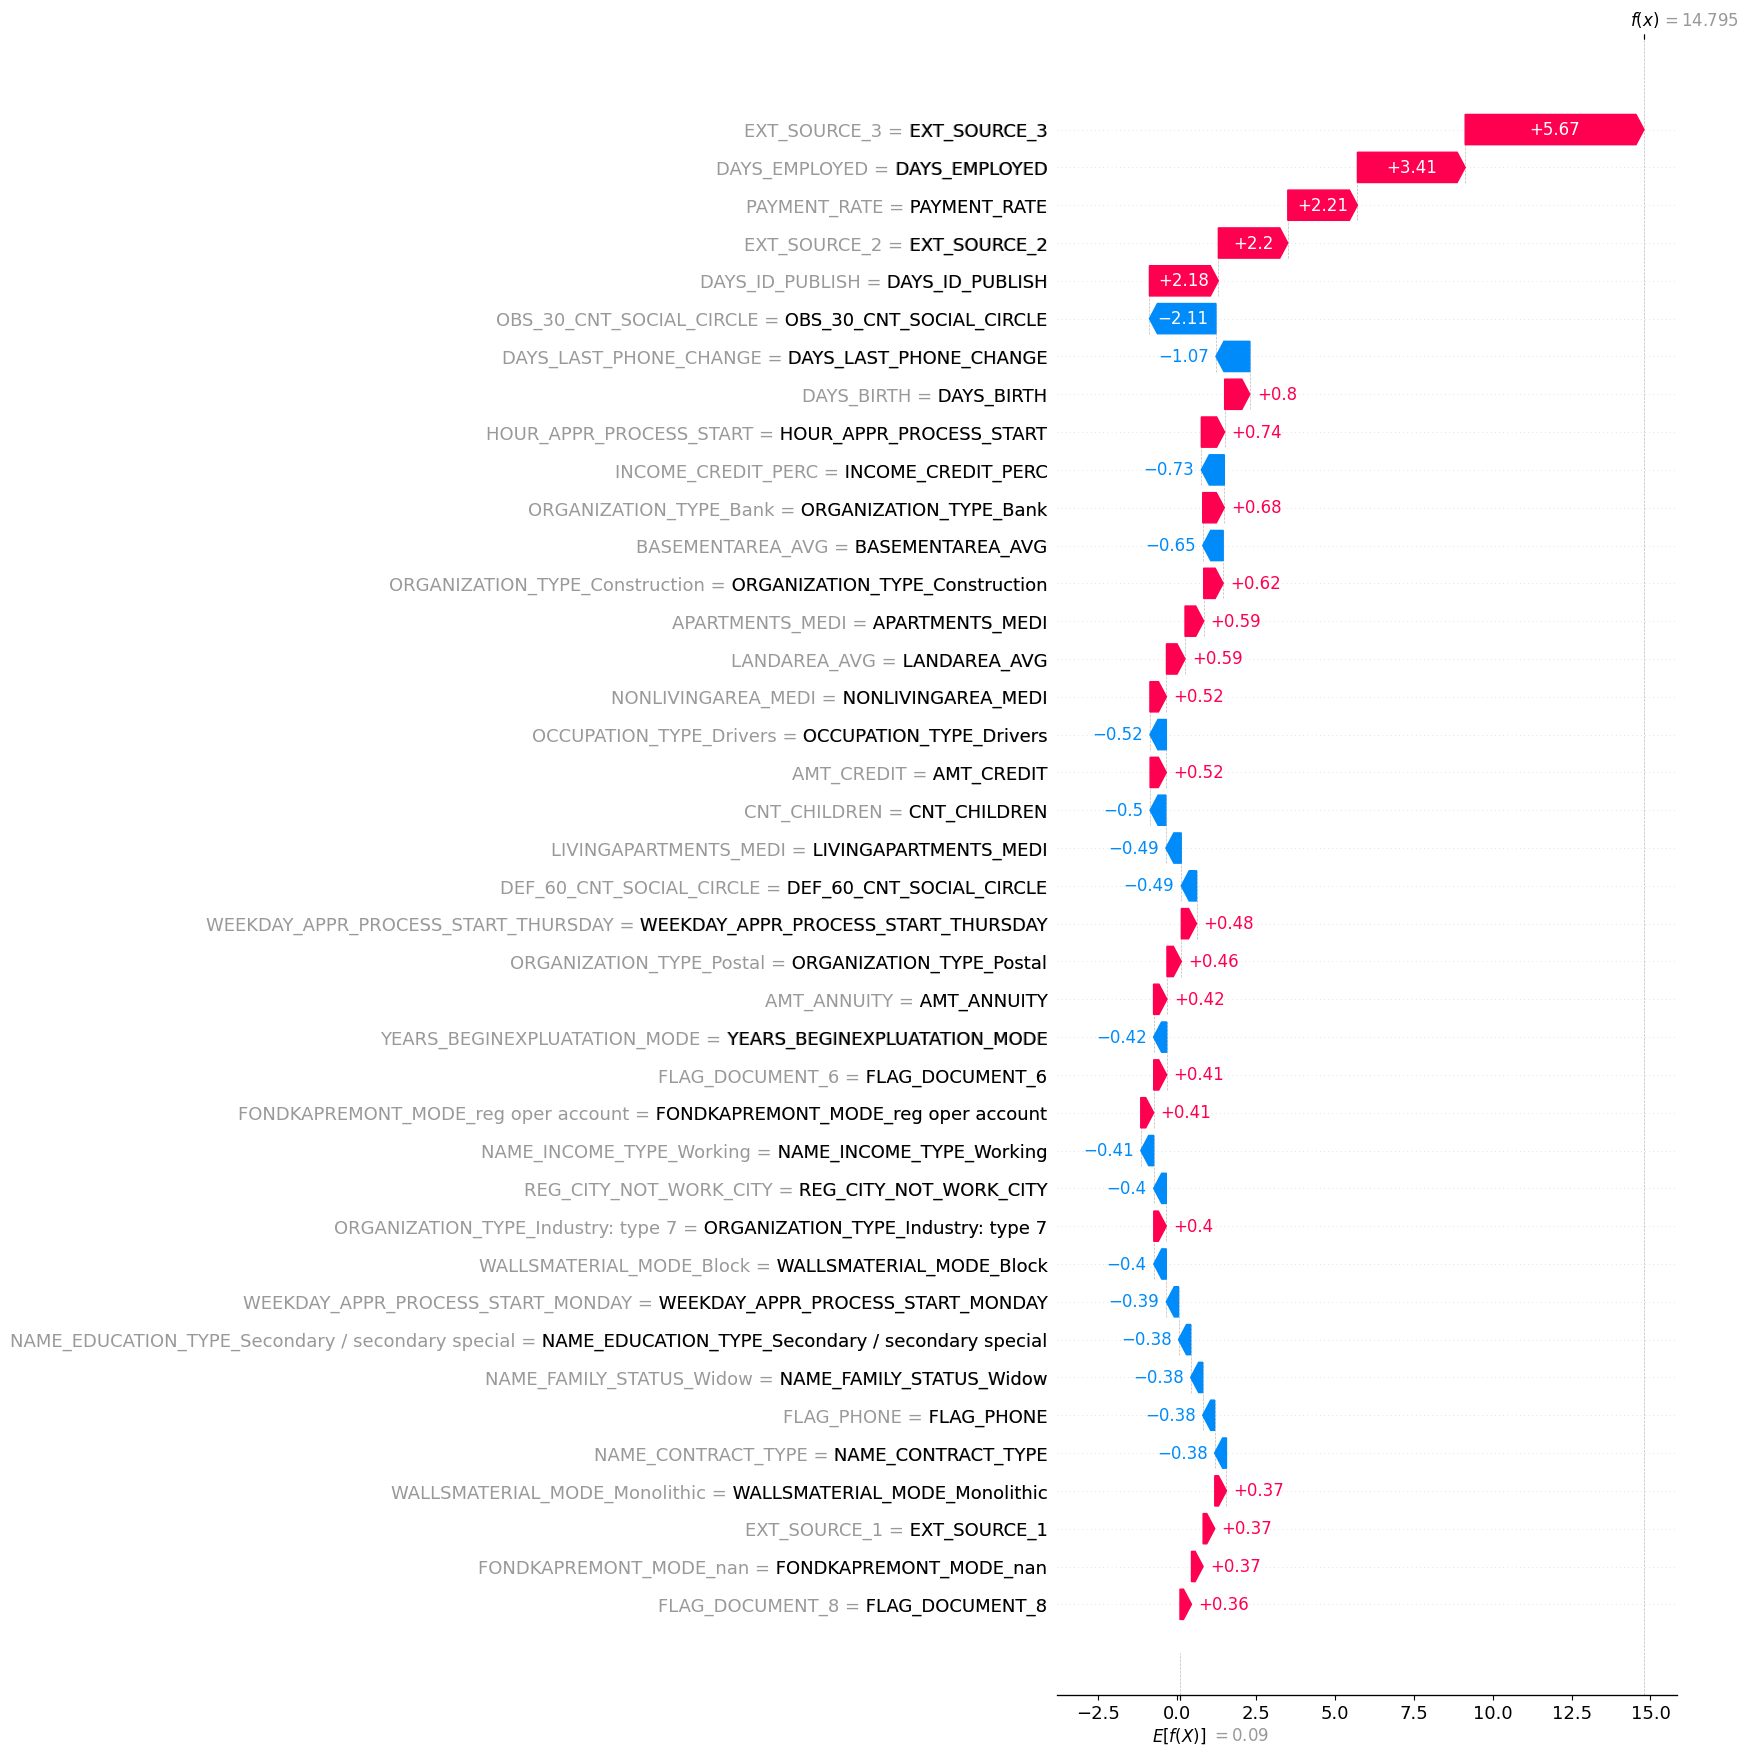

In [187]:
# Plot valeur de shapley pour l'individu i
X_train1 = saved_Decision_Tree_model['imp'].transform(X_train)
X_train2 = saved_Decision_Tree_model['scl'].transform(X_train1)
X_train_transformed = pd.DataFrame(columns=X_train.columns, data=X_train2)
sample = shap.utils.sample(X_train_transformed, nsamples=100)
explainer = shap.KernelExplainer(saved_Decision_Tree_model['model'].predict_proba, sample)
X_test1 = saved_Decision_Tree_model['imp'].transform(X_test)
X_test2 = saved_Decision_Tree_model['scl'].transform(X_test1)
X_test_transformed = pd.DataFrame(columns=X_train.columns, data=X_test2)
i=19
test_example = X_test_transformed.iloc[i,:]
shap_values = explainer.shap_values(test_example)
features_importantes = pd.DataFrame(index= X_train.columns, columns=['shap'], data=100*shap_values[0])
features_importantes['abs'] = features_importantes['shap'].apply(lambda x: abs(x))
features_importantes = features_importantes.sort_values('abs', ascending=False).iloc[:40]
expected_value =  (y_train)[sample.index].mean()
shap.plots.waterfall(WaterfallData(features_importantes, 'shap', expected_value, test_example), max_display=40)  

## Decision tree calibrated

In [191]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.tree import DecisionTreeClassifier

def Decision_Tree_calibrated(df, num_folds, stratified = False):
    
    X_train, X_test, y_train, y_test  = split(df)
    
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=42)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=42)
   
    features = [f for f in X_train.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    feature_importance_df = pd.DataFrame()
    result = []
    result_validation_set = pd.DataFrame()
    
    fig, ax = plt.subplots(2, num_folds, figsize=(num_folds*5, 10))
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train[features], y_train)):
        train_x, train_y = X_train[features].iloc[train_idx], y_train.iloc[train_idx]
        valid_x, valid_y = X_train[features].iloc[valid_idx], y_train.iloc[valid_idx]
        
        imp = SimpleImputer(strategy='median')
        scl = MinMaxScaler()
        regressor = DecisionTreeClassifier(criterion='gini', 
                                       splitter='best', 
                                       max_depth=5, 
                                       min_samples_split=2, 
                                       min_samples_leaf=4, 
                                       min_weight_fraction_leaf=0.0, 
                                       max_features=None, 
                                       random_state=42, 
                                       max_leaf_nodes=None, 
                                       min_impurity_decrease=0.0, 
                                       class_weight=None, )
        regressor_calibrated = CalibratedClassifierCV(regressor, method='isotonic', cv=3)
    
        steps = [('imp', imp), ('scl', scl), ('model', regressor_calibrated)]
        pipe = Pipeline(steps)
    
        pipe.fit(train_x, train_y)
    
    # Calcul des scores roc_auc pour valid et test
        valid_predict = pipe.predict_proba(valid_x)
        valid_predict_proba = [pred[1] for pred in valid_predict]
        valid_predict_proba_df = pd.DataFrame(valid_predict_proba)
        
        param = np.linspace(0.05, 0.6, 20)
        cost = []
        
        for i in param: 
            valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>i else 0)
            cm_valid = confusion_matrix(valid_y, valid_predict_class)
            cost += [(10*cm_valid[1][0] + cm_valid[0][1])/len(valid_y)*100]
        sns.lineplot(ax=ax[0][n_fold], x=param, y=cost)
        ax[0][n_fold].set_title('Cost train = f(threshold)', weight='bold')
    
        # Construction des matrices de confusion avec le meilleur threshold
        best_param = param[cost.index(min(cost))]
        print(f"Threshold optimum: {best_param}")
        result += [best_param]
        valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>best_param else 0)
        cm_valid = confusion_matrix(valid_y, valid_predict_class)
        confusion_valid = ConfusionMatrixDisplay(cm_valid)
        confusion_valid.plot(ax=ax[1][n_fold])
        confusion_valid.ax_.set_title('Validation set: confusion matrix', weight='bold')
        
        results_valid = [accuracy_score(valid_y, valid_predict_class),
                    (10*cm_valid[1][0] + cm_valid[0][1])/len(valid_x)*100,
                    f1_score(valid_y, valid_predict_class),
                    precision_score(valid_y, valid_predict_class),
                    (cm_valid[0][0]-(10*cm_valid[1][0] ))/len(valid_x)*100,
                    recall_score(valid_y, valid_predict_class),
                    roc_auc_score(valid_y, valid_predict_proba)] 
        result_validation_set['n_fold'] = results_valid
    result_validation = list(result_validation_set.mean(axis=1))
        
    best_threshold = np.array(result).mean()
    print(f"Threshold optimum - Mean: {best_threshold}")
    
    imp = SimpleImputer(strategy='median')
    scl = MinMaxScaler()
    regressor = DecisionTreeClassifier(criterion='gini', 
                                       splitter='best', 
                                       max_depth=5, 
                                       min_samples_split=2, 
                                       min_samples_leaf=4, 
                                       min_weight_fraction_leaf=0.0, 
                                       max_features=None, 
                                       random_state=42, 
                                       max_leaf_nodes=None, 
                                       min_impurity_decrease=0.0, 
                                       class_weight=None, )
    
    regressor_calibrated = CalibratedClassifierCV(regressor, method='isotonic', cv=3)
    steps = [('imp', imp), ('scl', scl), ('model', regressor_calibrated)]
    pipe = Pipeline(steps)
    
    pipe.fit(X_train, y_train)
    
    train_predict = pipe.predict_proba(X_train)
    train_predict_proba = [pred[1] for pred in train_predict]
    train_predict_proba_df = pd.DataFrame(train_predict_proba)
    train_predict_class = train_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    test_predict = pipe.predict_proba(X_test)
    test_predict_proba = [pred[1] for pred in test_predict]
    test_predict_proba_df = pd.DataFrame(test_predict_proba)
    test_predict_class = test_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    
    cm_train = confusion_matrix(y_train, train_predict_class)
    confusion_train = ConfusionMatrixDisplay(cm_train)
    cm_test = confusion_matrix(y_test, test_predict_class)
    confusion_test = ConfusionMatrixDisplay(cm_test)
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    confusion_train.plot(ax=ax[0])
    confusion_train.ax_.set_title('Train: confusion matrix', weight='bold')
    confusion_test.plot(ax=ax[1])
    confusion_test.ax_.set_title('Test: confusion matrix', weight='bold')
    
    results_test = [accuracy_score(y_test, test_predict_class),
                    (10*cm_test[1][0] + cm_test[0][1])/len(X_test)*100,
                    f1_score(y_test, test_predict_class),
                    precision_score(y_test, test_predict_class),
                    (cm_test[0][0]-(10*cm_test[1][0] ))/len(X_test)*100,
                    recall_score(y_test, test_predict_class),
                    roc_auc_score(y_test, test_predict_proba)] 
    results_train = [accuracy_score(y_train, train_predict_class),
                    (10*cm_train[1][0] + cm_train[0][1])/len(X_train)*100,
                    f1_score(y_train, train_predict_class),
                    precision_score(y_train, train_predict_class),
                    (cm_train[0][0]-(10*cm_train[1][0] ))/len(X_train)*100,
                    recall_score(y_train, train_predict_class),
                    roc_auc_score(y_train, train_predict_proba)] 
    print(score_df(results_train, result_validation, results_test))
   

In [192]:
def model_decision_tree_calibrated(df, num_folds=5, stratified = True):
    with timer("Run Decision_Tree_calibrated"):
        Decision_Tree_calibrated(df, num_folds, stratified)

Threshold optimum: 0.07894736842105263
Threshold optimum: 0.10789473684210527
Threshold optimum: 0.10789473684210527
Threshold optimum: 0.10789473684210527
Threshold optimum: 0.10789473684210527
Threshold optimum - Mean: 0.10210526315789474
           Validation      Train       Test
Accuracy     0.825000   0.823250   0.786500
Cost        53.500000  47.600000  55.550000
F1_score     0.300000   0.333648   0.270085
Precision    0.217391   0.235686   0.183721
Profit      38.750000  44.650000  36.700000
Recall       0.483871   0.570968   0.509677
roc_auc      0.725145   0.768457   0.714104
Run Decision_Tree_calibrated - done in 6s


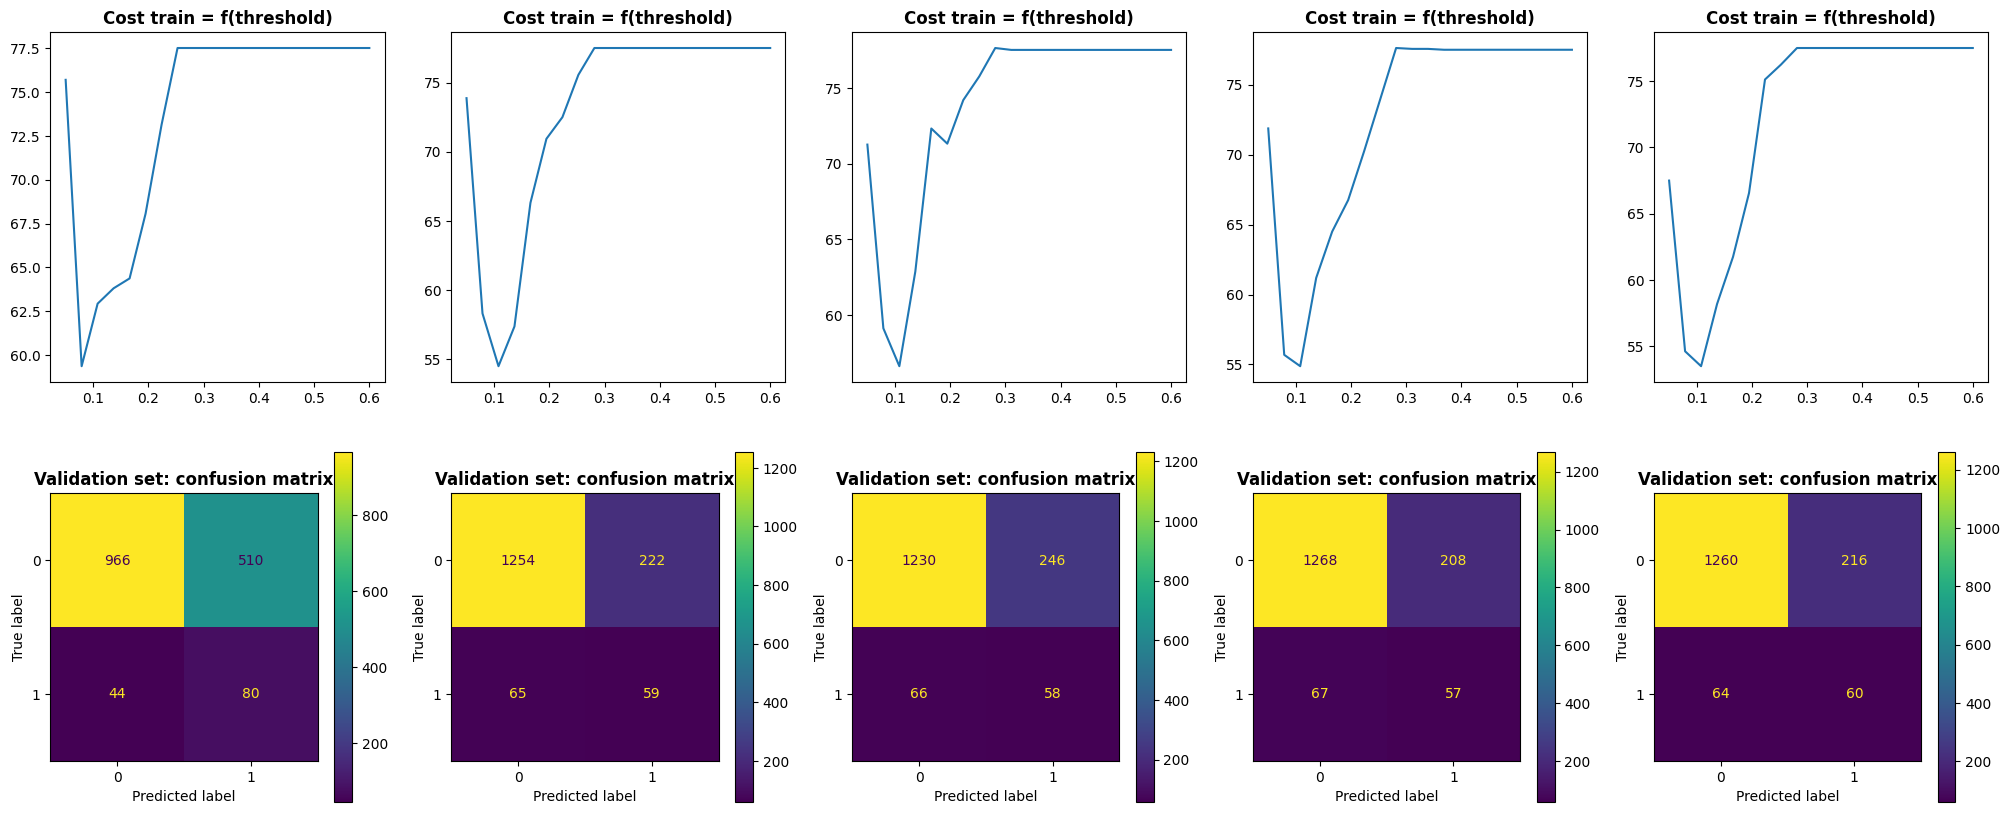

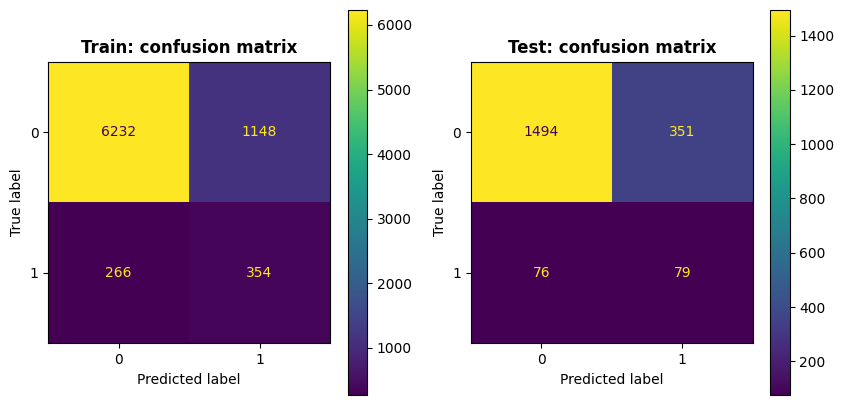

In [193]:
model_decision_tree_calibrated(df_10000)

In [683]:
saved_Decision_Tree_calibrated = joblib.load('Decision_Tree_calibrated_model.joblib')

In [716]:
saved_Decision_Tree_calibrated['model'].calibrated_classifiers_[0]

# Random forest

## Model

In [194]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE, KMeansSMOTE, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from sklearn.calibration import CalibratedClassifierCV
from sklearn.tree import DecisionTreeClassifier

def Random_Forest(df, num_folds, stratified = False):
    
    X_train, X_test, y_train, y_test  = split(df)
    
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=42)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=42)
   
    features = [f for f in X_train.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    feature_importance_df = pd.DataFrame()
    result = []
    result_validation_set = pd.DataFrame()
    
    fig, ax = plt.subplots(2, num_folds, figsize=(num_folds*5, 10))
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train[features], y_train)):
        train_x, train_y = X_train[features].iloc[train_idx], y_train.iloc[train_idx]
        valid_x, valid_y = X_train[features].iloc[valid_idx], y_train.iloc[valid_idx]
        
        imp = SimpleImputer(strategy='median')
        scl = MinMaxScaler()
        regressor = RandomForestClassifier(n_estimators=100,
                                       criterion='gini', 
                                       max_depth=16, 
                                       min_samples_split=5, 
                                       min_samples_leaf=3, 
                                       min_weight_fraction_leaf=0.0, 
                                       max_features='sqrt', 
                                       max_leaf_nodes=None, 
                                       min_impurity_decrease=0.0, 
                                       bootstrap=True, 
                                       oob_score=False, 
                                       n_jobs=None, 
                                       random_state=42, 
                                       verbose=0, 
                                       warm_start=False, 
                                       class_weight=None, 
                                       max_samples=299,
                                      ccp_alpha=0.001761)
    
        steps = [('imp', imp), ('scl', scl), ('model', regressor)]
        pipe = Pipeline(steps)
        pipe.fit(train_x, train_y)
        
    # Calcul des scores roc_auc pour valid et test
        valid_predict = pipe.predict_proba(valid_x)
        valid_predict_proba = [pred[1] for pred in valid_predict]
        valid_predict_proba_df = pd.DataFrame(valid_predict_proba)
        
        param = np.linspace(0.02, 0.2, 20)
        cost = []
        for i in param: 
            valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>i else 0)
            cm_valid = confusion_matrix(valid_y, valid_predict_class)
            cost += [(10*cm_valid[1][0] + cm_valid[0][1])/len(valid_y)*100]
        sns.lineplot(ax=ax[0][n_fold], x=param, y=cost)
        ax[0][n_fold].set_title('Cost train = f(threshold)', weight='bold')
    
        # Construction des matrices de confusion avec le meilleur threshold
        best_param = param[cost.index(min(cost))]
        print(f"Threshold optimum: {best_param}")
        result += [best_param]
        valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>best_param else 0)
        cm_valid = confusion_matrix(valid_y, valid_predict_class)
        confusion_valid = ConfusionMatrixDisplay(cm_valid)
        confusion_valid.plot(ax=ax[1][n_fold])
        confusion_valid.ax_.set_title('Validation set: confusion matrix', weight='bold')
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = features
        fold_importance_df["importance"] = pipe['model'].feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        feature_importance_df["importance"] = feature_importance_df["importance"].apply(lambda x: abs(x))
        
        results_valid = [accuracy_score(valid_y, valid_predict_class),
                    (10*cm_valid[1][0] + cm_valid[0][1])/len(valid_x)*100,
                    f1_score(valid_y, valid_predict_class),
                    precision_score(valid_y, valid_predict_class),
                    (cm_valid[0][0]-(10*cm_valid[1][0] ))/len(valid_x)*100,
                    recall_score(valid_y, valid_predict_class),
                    roc_auc_score(valid_y, valid_predict_proba)] 
        result_validation_set['n_fold'] = results_valid
    result_validation = list(result_validation_set.mean(axis=1))
        
    best_threshold = np.array(result).mean()
    print(f"Threshold optimum - Mean: {best_threshold}")
    
    imp = SimpleImputer(strategy='median')
    scl = MinMaxScaler()
    regressor = RandomForestClassifier(n_estimators=100,
                                       criterion='gini', 
                                       max_depth=16, 
                                       min_samples_split=5, 
                                       min_samples_leaf=3, 
                                       min_weight_fraction_leaf=0.0, 
                                       max_features='sqrt', 
                                       max_leaf_nodes=None, 
                                       min_impurity_decrease=0.0, 
                                       bootstrap=True, 
                                       oob_score=False, 
                                       n_jobs=None, 
                                       random_state=42, 
                                       verbose=0, 
                                       warm_start=False, 
                                       class_weight=None, 
                                       max_samples=299,
                                      ccp_alpha=0.001761)
    
    steps = [('imp', imp), ('scl', scl), ('model', regressor)]
    pipe = Pipeline(steps)
    pipe.fit(X_train, y_train)
    joblib.dump(pipe, 'Random_Forest_model.joblib')
    
    train_predict = pipe.predict_proba(X_train)
    train_predict_proba = [pred[1] for pred in train_predict]
    train_predict_proba_df = pd.DataFrame(train_predict_proba)
    train_predict_class = train_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    test_predict = pipe.predict_proba(X_test)
    test_predict_proba = [pred[1] for pred in test_predict]
    test_predict_proba_df = pd.DataFrame(test_predict_proba)
    test_predict_class = test_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    
    cm_train = confusion_matrix(y_train, train_predict_class)
    confusion_train = ConfusionMatrixDisplay(cm_train)
    cm_test = confusion_matrix(y_test, test_predict_class)
    confusion_test = ConfusionMatrixDisplay(cm_test)
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    confusion_train.plot(ax=ax[0])
    confusion_train.ax_.set_title('Train: confusion matrix', weight='bold')
    confusion_test.plot(ax=ax[1])
    confusion_test.ax_.set_title('Test: confusion matrix', weight='bold')
    
    results_test = [accuracy_score(y_test, test_predict_class),
                    (10*cm_test[1][0] + cm_test[0][1])/len(X_test)*100,
                    f1_score(y_test, test_predict_class),
                    precision_score(y_test, test_predict_class),
                    (cm_test[0][0]-(10*cm_test[1][0] ))/len(X_test)*100,
                    recall_score(y_test, test_predict_class),
                    roc_auc_score(y_test, test_predict_proba)] 
    results_train = [accuracy_score(y_train, train_predict_class),
                    (10*cm_train[1][0] + cm_train[0][1])/len(X_train)*100,
                    f1_score(y_train, train_predict_class),
                    precision_score(y_train, train_predict_class),
                    (cm_train[0][0]-(10*cm_train[1][0] ))/len(X_train)*100,
                    recall_score(y_train, train_predict_class),
                    roc_auc_score(y_train, train_predict_proba)] 
    print(score_df(results_train, result_validation, results_test))
   
    display_importances(feature_importance_df) 

In [195]:
def model5(df, num_folds=5, stratified = True):
    with timer("Run Random_Forest"):
        Random_Forest(df, num_folds, stratified)

Threshold optimum: 0.09578947368421054
Threshold optimum: 0.11473684210526316
Threshold optimum: 0.11473684210526316
Threshold optimum: 0.09578947368421054
Threshold optimum: 0.10526315789473685
Threshold optimum - Mean: 0.10526315789473686
           Validation      Train       Test
Accuracy     0.760000   0.788250   0.770000
Cost        58.312500  50.312500  55.400000
F1_score     0.247059   0.298841   0.265176
Precision    0.163212   0.201002   0.176221
Profit      33.937500  41.937500  36.850000
Recall       0.508065   0.582258   0.535484
roc_auc      0.699220   0.777468   0.711468
Run Random_Forest - done in 8s


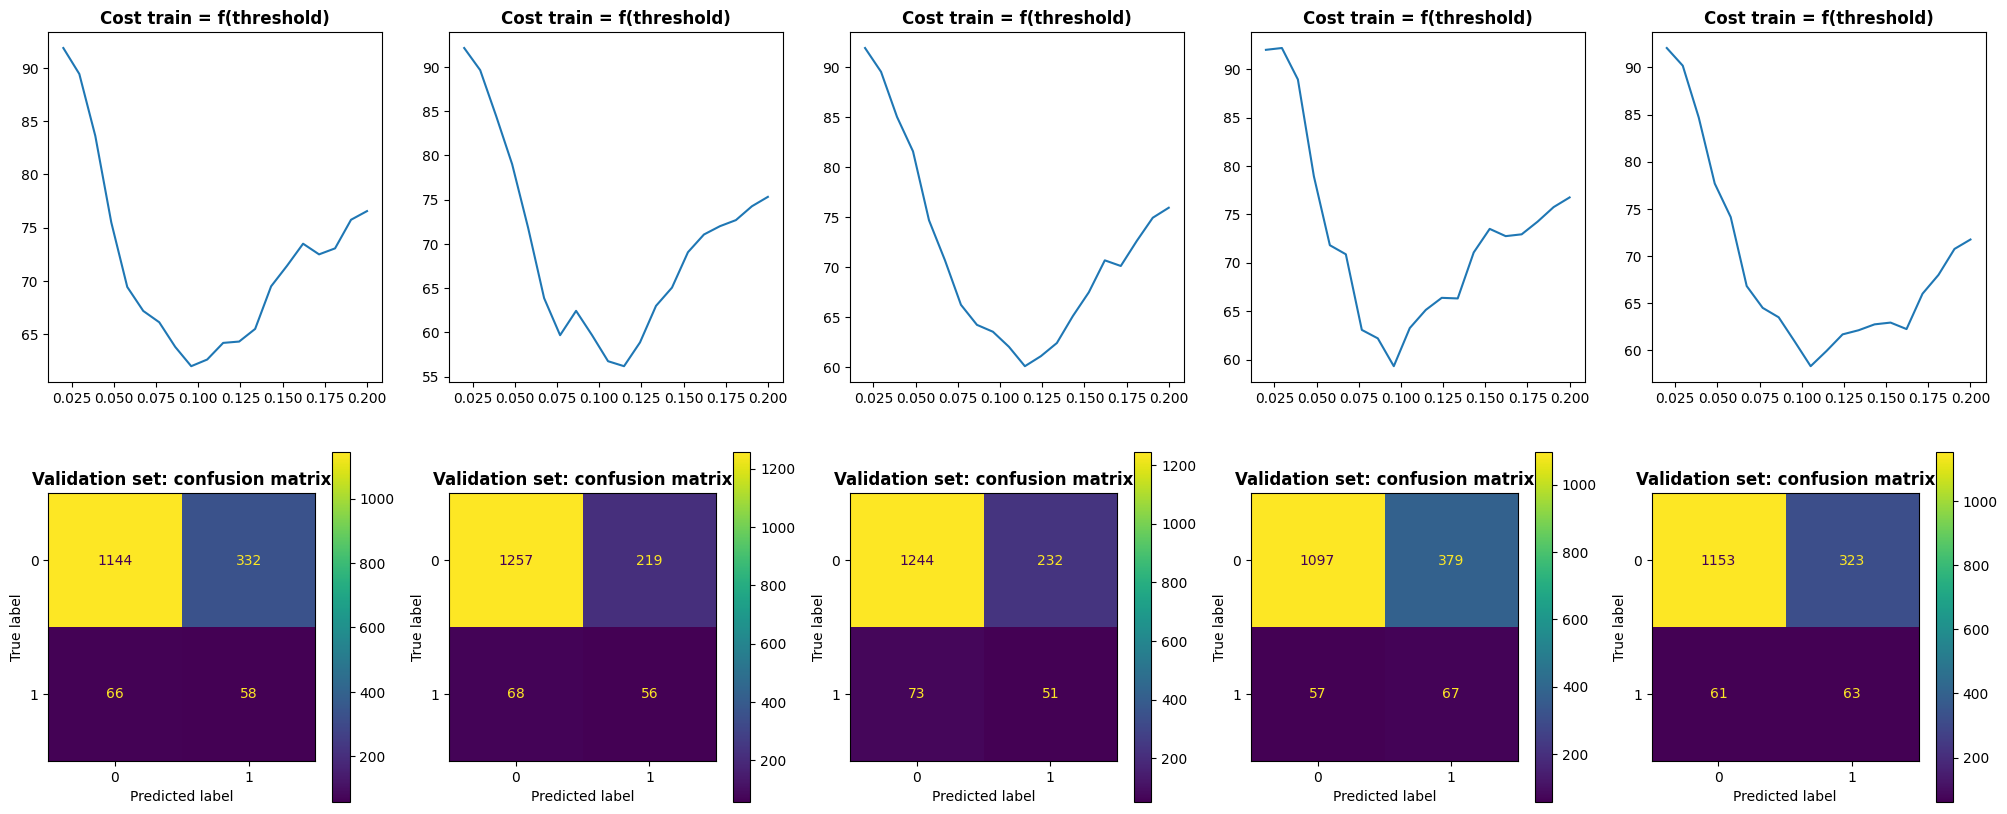

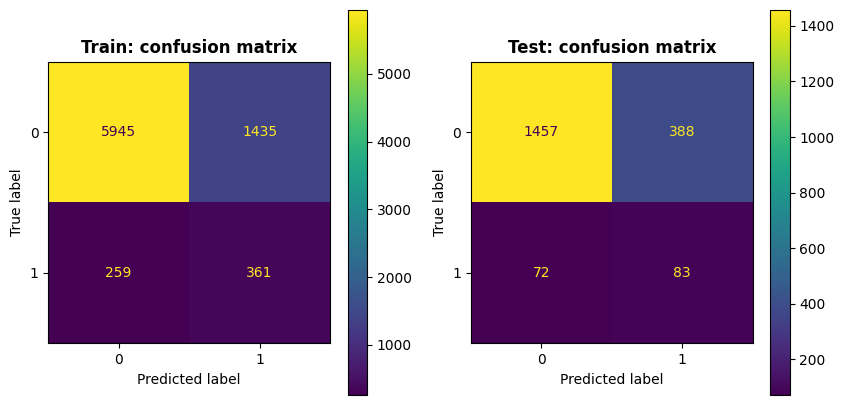

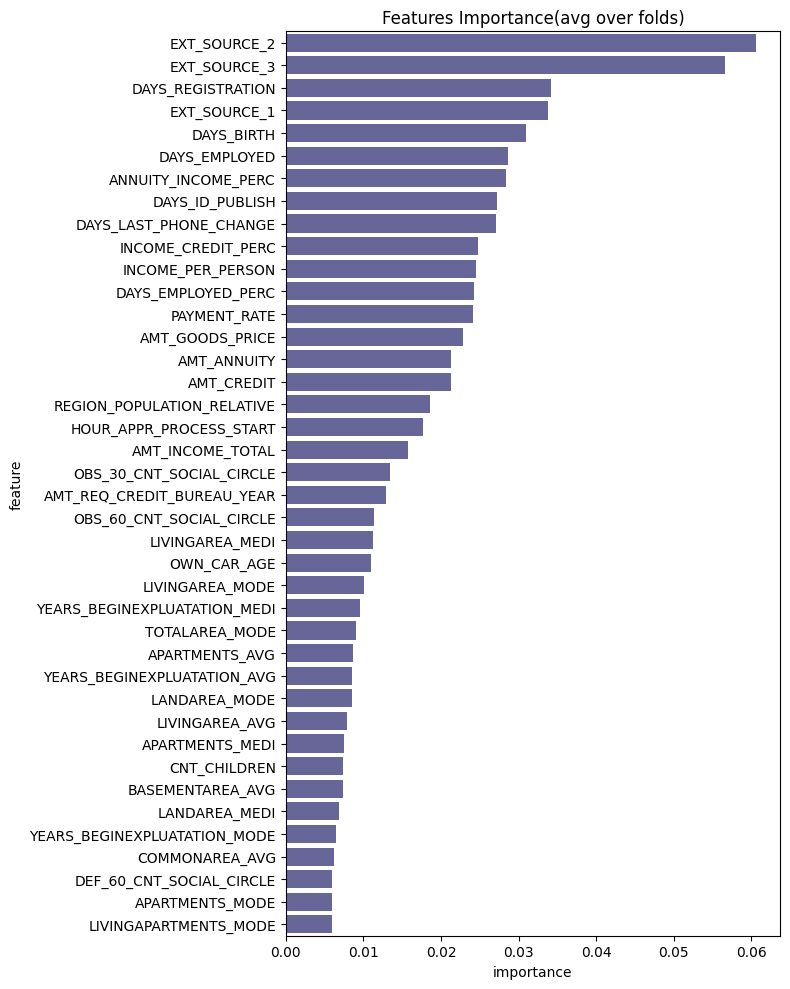

In [196]:
model5(df_10000)

In [197]:
saved_Random_Forest_model= joblib.load('Random_Forest_model.joblib')

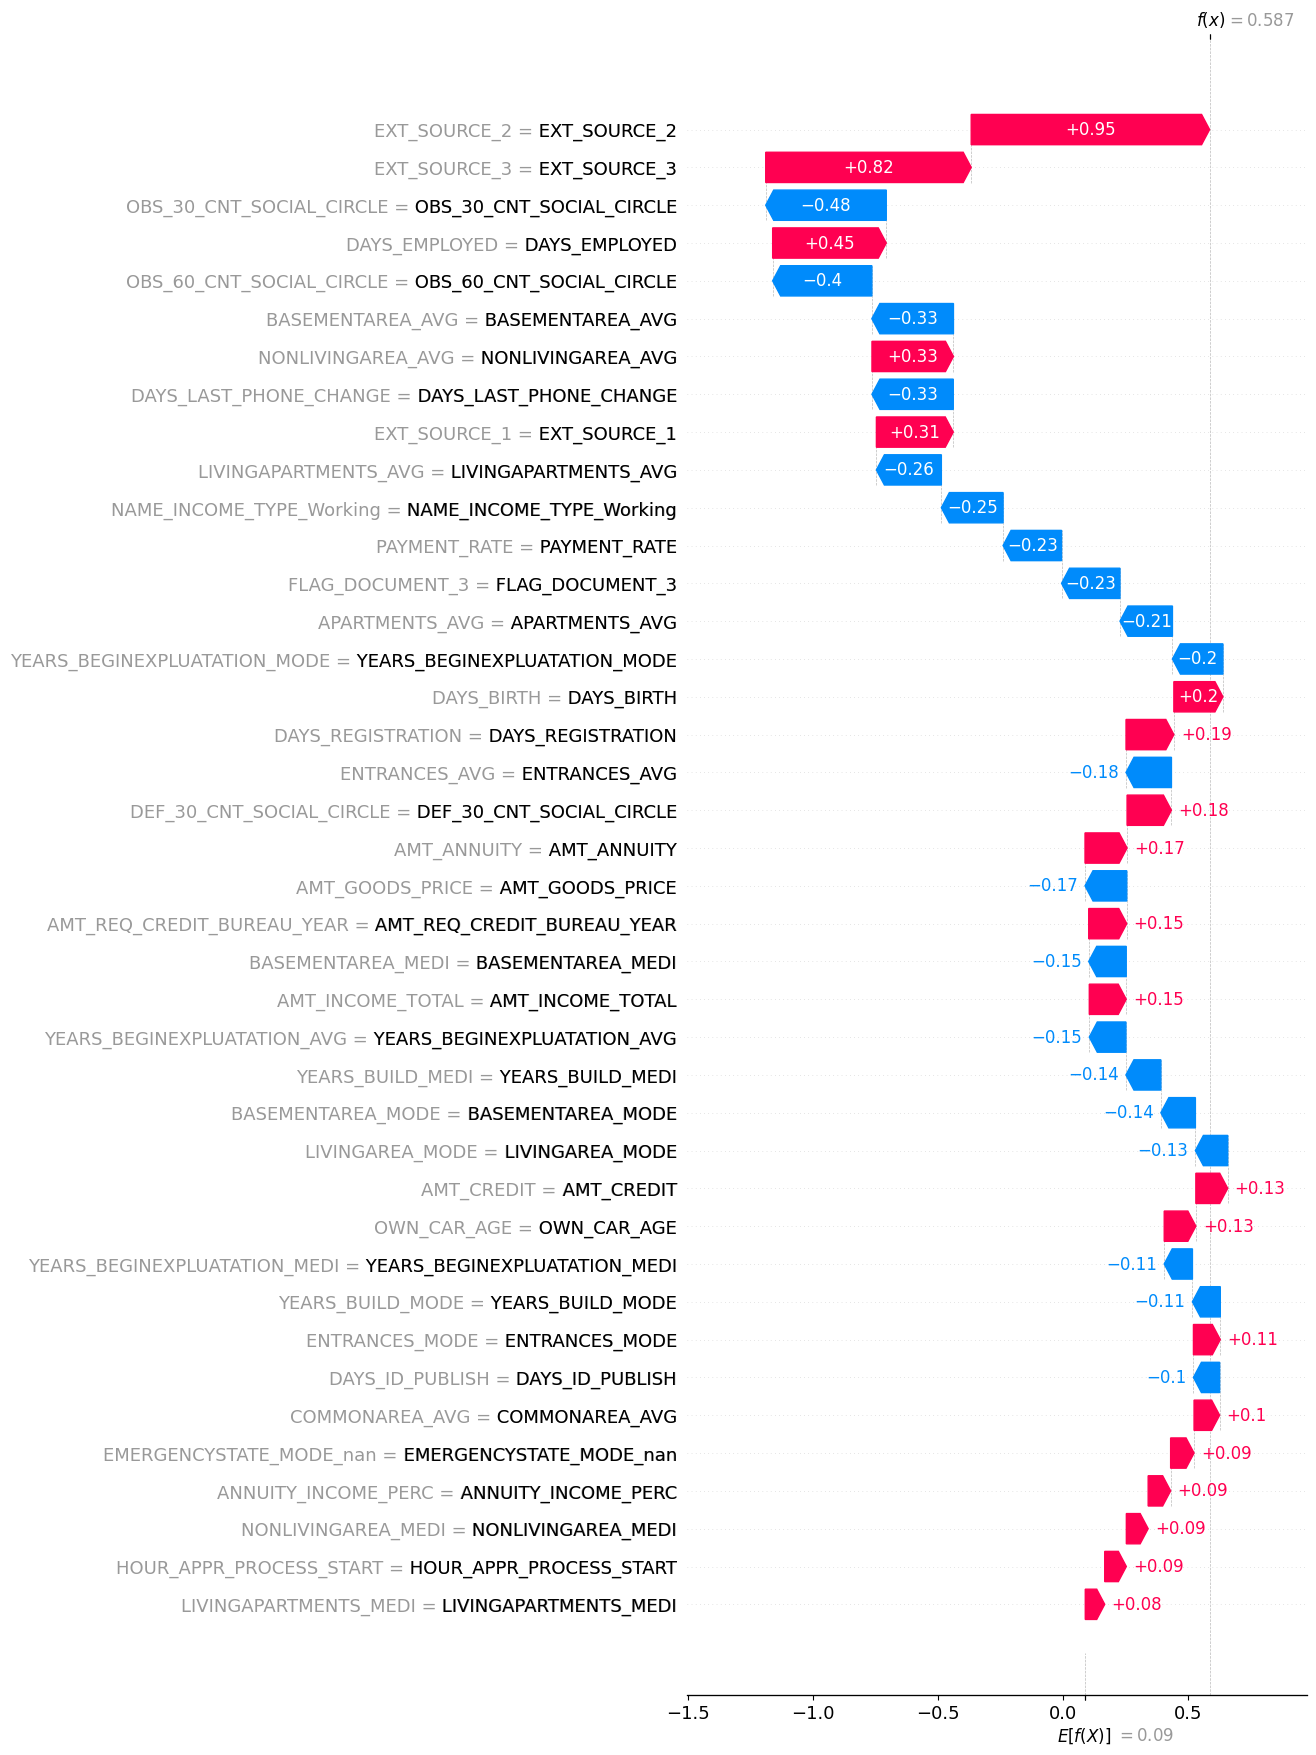

In [198]:
# Plot valeur de shapley pour l'individu i
X_train1 = saved_Random_Forest_model['imp'].transform(X_train)
X_train2 = saved_Random_Forest_model['scl'].transform(X_train1)
X_train_transformed = pd.DataFrame(columns=X_train.columns, data=X_train2)
sample = shap.utils.sample(X_train_transformed, nsamples=100)
explainer = shap.KernelExplainer(saved_Random_Forest_model['model'].predict_proba, sample)
X_test1 = saved_Random_Forest_model['imp'].transform(X_test)
X_test2 = saved_Random_Forest_model['scl'].transform(X_test1)
X_test_transformed = pd.DataFrame(columns=X_train.columns, data=X_test2)
i=19
test_example = X_test_transformed.iloc[i,:]
shap_values = explainer.shap_values(test_example)
features_importantes = pd.DataFrame(index= X_train.columns, columns=['shap'], data=100*shap_values[0])
features_importantes['abs'] = features_importantes['shap'].apply(lambda x: abs(x))
features_importantes = features_importantes.sort_values('abs', ascending=False).iloc[:40]
expected_value =  (y_train)[sample.index].mean()
shap.plots.waterfall(WaterfallData(features_importantes, 'shap', expected_value, test_example), max_display=40)  

## Random_Forest_calibrated

In [205]:
def Random_Forest_calibrated(df, num_folds, stratified = False):
    
    X_train, X_test, y_train, y_test  = split(df)
    
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=42)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=42)
   
    features = [f for f in X_train.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    feature_importance_df = pd.DataFrame()
    result = []
    result_validation_set = pd.DataFrame()
    
    fig, ax = plt.subplots(2, num_folds, figsize=(num_folds*5, 10))
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train[features], y_train)):
        train_x, train_y = X_train[features].iloc[train_idx], y_train.iloc[train_idx]
        valid_x, valid_y = X_train[features].iloc[valid_idx], y_train.iloc[valid_idx]
        
        imp = SimpleImputer(strategy='median')
        scl = MinMaxScaler()
        regressor = RandomForestClassifier(n_estimators=100,
                                       criterion='gini', 
                                       max_depth=16, 
                                       min_samples_split=5, 
                                       min_samples_leaf=3, 
                                       min_weight_fraction_leaf=0.0, 
                                       max_features='sqrt', 
                                       max_leaf_nodes=None, 
                                       min_impurity_decrease=0.0, 
                                       bootstrap=True, 
                                       oob_score=False, 
                                       n_jobs=None, 
                                       random_state=42, 
                                       verbose=0, 
                                       warm_start=False, 
                                       class_weight=None, 
                                       max_samples=299,
                                      ccp_alpha=0.001761)
        regressor_calibrated = CalibratedClassifierCV(regressor, method='isotonic', cv=3)
    
        steps = [('imp', imp), ('scl', scl), ('model', regressor_calibrated)]
        pipe = Pipeline(steps)
        pipe.fit(train_x, train_y)
    
    # Calcul des scores roc_auc pour valid et test
        valid_predict = pipe.predict_proba(valid_x)
        valid_predict_proba = [pred[1] for pred in valid_predict]
        valid_predict_proba_df = pd.DataFrame(valid_predict_proba)
        
        param = np.linspace(0.05, 0.6, 20)
        cost = []
        
        for i in param: 
            valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>i else 0)
            cm_valid = confusion_matrix(valid_y, valid_predict_class)
            cost += [(10*cm_valid[1][0] + cm_valid[0][1])/len(valid_y)*100]
        sns.lineplot(ax=ax[0][n_fold], x=param, y=cost)
        ax[0][n_fold].set_title('Cost train = f(threshold)', weight='bold')
    
        # Construction des matrices de confusion avec le meilleur threshold
        best_param = param[cost.index(min(cost))]
        print(f"Threshold optimum: {best_param}")
        result += [best_param]
        valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>best_param else 0)
        cm_valid = confusion_matrix(valid_y, valid_predict_class)
        confusion_valid = ConfusionMatrixDisplay(cm_valid)
        confusion_valid.plot(ax=ax[1][n_fold])
        confusion_valid.ax_.set_title('Validation set: confusion matrix', weight='bold')
        
        results_valid = [accuracy_score(valid_y, valid_predict_class),
                    (10*cm_valid[1][0] + cm_valid[0][1])/len(valid_x)*100,
                    f1_score(valid_y, valid_predict_class),
                    precision_score(valid_y, valid_predict_class),
                    (cm_valid[0][0]-(10*cm_valid[1][0] ))/len(valid_x)*100,
                    recall_score(valid_y, valid_predict_class),
                    roc_auc_score(valid_y, valid_predict_proba)] 
        result_validation_set['n_fold'] = results_valid
    result_validation = list(result_validation_set.mean(axis=1))
        

    best_threshold = np.array(result).mean()
    print(f"Threshold optimum - Mean: {best_threshold}")
    
    imp = SimpleImputer(strategy='median')
    scl = MinMaxScaler()
    regressor = RandomForestClassifier(n_estimators=100,
                                       criterion='gini', 
                                       max_depth=16, 
                                       min_samples_split=5, 
                                       min_samples_leaf=3, 
                                       min_weight_fraction_leaf=0.0, 
                                       max_features='sqrt', 
                                       max_leaf_nodes=None, 
                                       min_impurity_decrease=0.0, 
                                       bootstrap=True, 
                                       oob_score=False, 
                                       n_jobs=None, 
                                       random_state=42, 
                                       verbose=0, 
                                       warm_start=False, 
                                       class_weight=None, 
                                       max_samples=299,
                                      ccp_alpha=0.001761)
    
    regressor_calibrated = CalibratedClassifierCV(regressor, method='isotonic', cv=3)
    steps = [('imp', imp), ('scl', scl), ('model', regressor_calibrated)]
    pipe = Pipeline(steps)
    
    pipe.fit(X_train, y_train)
    
    train_predict = pipe.predict_proba(X_train)
    train_predict_proba = [pred[1] for pred in train_predict]
    train_predict_proba_df = pd.DataFrame(train_predict_proba)
    train_predict_class = train_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    test_predict = pipe.predict_proba(X_test)
    test_predict_proba = [pred[1] for pred in test_predict]
    test_predict_proba_df = pd.DataFrame(test_predict_proba)
    test_predict_class = test_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    
    cm_train = confusion_matrix(y_train, train_predict_class)
    confusion_train = ConfusionMatrixDisplay(cm_train)
    cm_test = confusion_matrix(y_test, test_predict_class)
    confusion_test = ConfusionMatrixDisplay(cm_test)
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    confusion_train.plot(ax=ax[0])
    confusion_train.ax_.set_title('Train: confusion matrix', weight='bold')
    confusion_test.plot(ax=ax[1])
    confusion_test.ax_.set_title('Test: confusion matrix', weight='bold')
    
    results_test = [accuracy_score(y_test, test_predict_class),
                    (10*cm_test[1][0] + cm_test[0][1])/len(X_test)*100,
                    f1_score(y_test, test_predict_class),
                    precision_score(y_test, test_predict_class),
                    (cm_test[0][0]-(10*cm_test[1][0] ))/len(X_test)*100,
                    recall_score(y_test, test_predict_class),
                    roc_auc_score(y_test, test_predict_proba)] 
    results_train = [accuracy_score(y_train, train_predict_class),
                    (10*cm_train[1][0] + cm_train[0][1])/len(X_train)*100,
                    f1_score(y_train, train_predict_class),
                    precision_score(y_train, train_predict_class),
                    (cm_train[0][0]-(10*cm_train[1][0] ))/len(X_train)*100,
                    recall_score(y_train, train_predict_class),
                    roc_auc_score(y_train, train_predict_proba)] 
    print(score_df(results_train, result_validation, results_test))
    

In [206]:
def model_Random_Forest_calibrated(df, num_folds=5, stratified = True):
    with timer("Run Random_Forest Calibrated"):
        Random_Forest_calibrated(df, num_folds, stratified)

Threshold optimum: 0.10789473684210527
Threshold optimum: 0.07894736842105263
Threshold optimum: 0.13684210526315788
Threshold optimum: 0.07894736842105263
Threshold optimum: 0.07894736842105263
Threshold optimum - Mean: 0.09631578947368422
           Validation      Train       Test
Accuracy     0.668125   0.773625   0.743500
Cost        57.375000  47.837500  56.700000
F1_score     0.233766   0.304264   0.251095
Precision    0.142355   0.199697   0.162264
Profit      34.875000  44.412500  35.550000
Recall       0.653226   0.638710   0.554839
roc_auc      0.712830   0.798046   0.731933
Run Random_Forest Calibrated - done in 12s


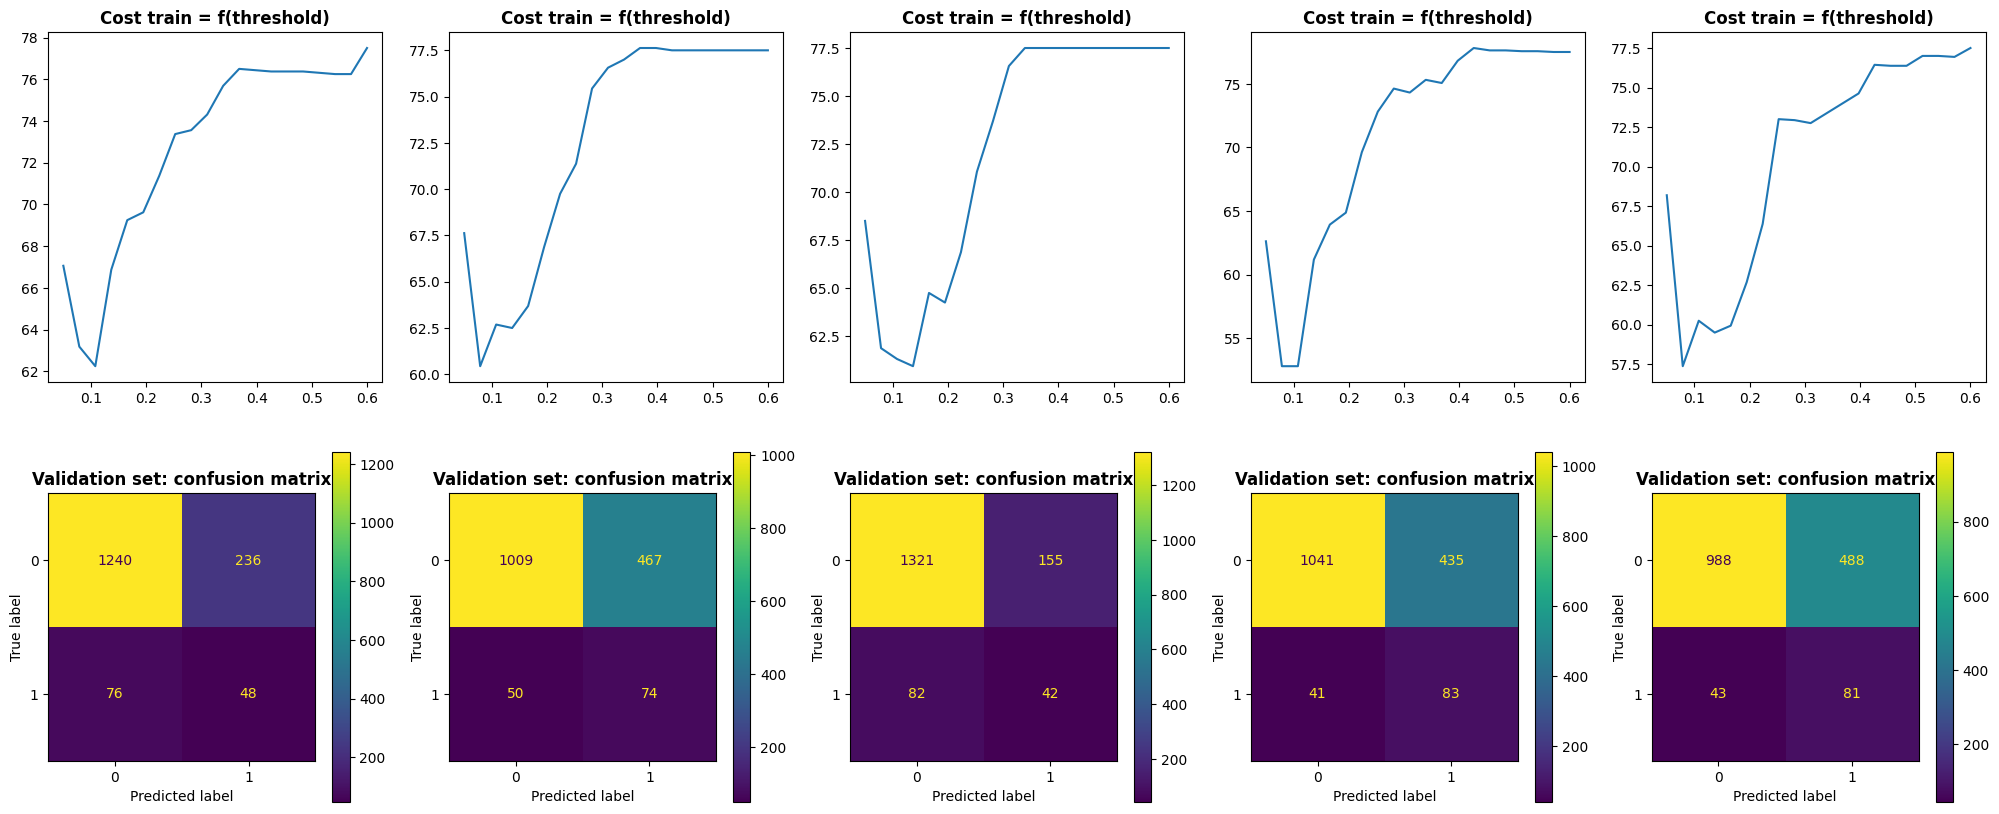

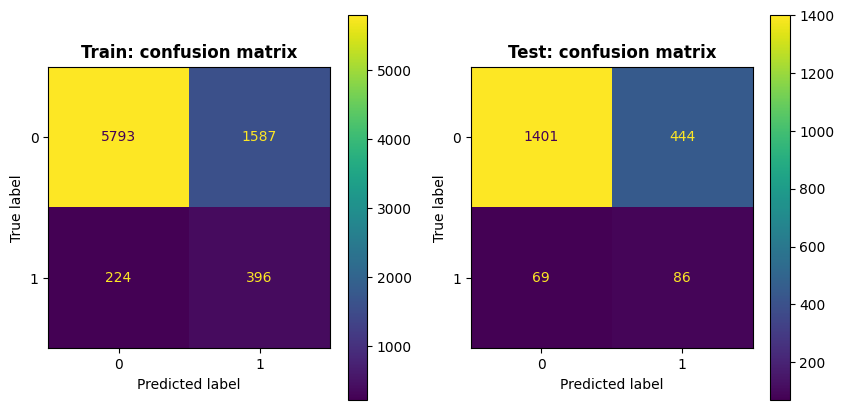

In [207]:
model_Random_Forest_calibrated(df_10000)

# KNN
## KNN calibrated

In [208]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance

def KNN(df, num_folds, stratified = False):
    
    X_train, X_test, y_train, y_test  = split(df)
    
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=42)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=42)
   
    features = [f for f in X_train.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    feature_importance_df = pd.DataFrame()
    result = []
    result_validation_set = pd.DataFrame()
    
    fig, ax = plt.subplots(2, num_folds, figsize=(num_folds*5, 10))
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train[features], y_train)):
        train_x, train_y = X_train[features].iloc[train_idx], y_train.iloc[train_idx]
        valid_x, valid_y = X_train[features].iloc[valid_idx], y_train.iloc[valid_idx]
        
        imp = SimpleImputer(strategy='median')
        scl = MinMaxScaler()
        regressor = KNeighborsClassifier(weights='uniform', 
                                     algorithm='auto',  
                                     p=2, 
                                     metric='minkowski',
                                     leaf_size=30,
                                     metric_params=None, 
                                     n_jobs=None)
        regressor_calibrated = CalibratedClassifierCV(regressor, method='isotonic', cv=3)
    
        steps = [('imp', imp), ('scl', scl), ('model', regressor_calibrated)]
        pipe = Pipeline(steps)
    
        pipe.fit(train_x, train_y)
    
    # Calcul des scores roc_auc pour valid et test
        valid_predict = pipe.predict_proba(valid_x)
        valid_predict_proba = [pred[1] for pred in valid_predict]
        valid_predict_proba_df = pd.DataFrame(valid_predict_proba)
        
        param = np.linspace(0.05, 0.6, 20)
        cost = []
        
        for i in param: 
            valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>i else 0)
            cm_valid = confusion_matrix(valid_y, valid_predict_class)
            cost += [(10*cm_valid[1][0] + cm_valid[0][1])/len(valid_y)*100]
        sns.lineplot(ax=ax[0][n_fold], x=param, y=cost)
        ax[0][n_fold].set_title('Cost train = f(threshold)', weight='bold')
    
        # Construction des matrices de confusion avec le meilleur threshold
        best_param = param[cost.index(min(cost))]
        print(f"Threshold optimum: {best_param}")
        result += [best_param]
        valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>best_param else 0)
        cm_valid = confusion_matrix(valid_y, valid_predict_class)
        confusion_valid = ConfusionMatrixDisplay(cm_valid)
        confusion_valid.plot(ax=ax[1][n_fold])
        confusion_valid.ax_.set_title('Validation set: confusion matrix', weight='bold')
        
        results_valid = [accuracy_score(valid_y, valid_predict_class),
                    (10*cm_valid[1][0] + cm_valid[0][1])/len(valid_x)*100,
                    f1_score(valid_y, valid_predict_class),
                    precision_score(valid_y, valid_predict_class),
                    (cm_valid[0][0]-(10*cm_valid[1][0] ))/len(valid_x)*100,
                    recall_score(valid_y, valid_predict_class),
                    roc_auc_score(valid_y, valid_predict_proba)] 
        result_validation_set['n_fold'] = results_valid
    result_validation = list(result_validation_set.mean(axis=1))
        

    best_threshold = np.array(result).mean()
    print(f"Threshold optimum - Mean: {best_threshold}")
    
    imp = SimpleImputer(strategy='median')
    scl = MinMaxScaler()
    regressor = KNeighborsClassifier(weights='uniform', 
                                     algorithm='auto',  
                                     p=2, 
                                     metric='minkowski',
                                     leaf_size=30,
                                     metric_params=None, 
                                     n_jobs=None)
    
    regressor_calibrated = CalibratedClassifierCV(regressor, method='isotonic', cv=3)
    steps = [('imp', imp), ('scl', scl), ('model', regressor_calibrated)]
    pipe = Pipeline(steps)
    
    pipe.fit(X_train, y_train)
    
    train_predict = pipe.predict_proba(X_train)
    train_predict_proba = [pred[1] for pred in train_predict]
    train_predict_proba_df = pd.DataFrame(train_predict_proba)
    train_predict_class = train_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    test_predict = pipe.predict_proba(X_test)
    test_predict_proba = [pred[1] for pred in test_predict]
    test_predict_proba_df = pd.DataFrame(test_predict_proba)
    test_predict_class = test_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    
    cm_train = confusion_matrix(y_train, train_predict_class)
    confusion_train = ConfusionMatrixDisplay(cm_train)
    cm_test = confusion_matrix(y_test, test_predict_class)
    confusion_test = ConfusionMatrixDisplay(cm_test)
    
    fold_importance_df = pd.DataFrame()
    for calibr in pipe['model'].calibrated_classifiers_:
        fold_importance_df_calibr = pd.DataFrame()
        fold_importance_df_calibr["feature"] = features
        fold_importance_df_calibr["importance"] = permutation_importance(pipe, X_train, y_train, scoring='roc_auc').importances_mean
        fold_importance_df = pd.concat([fold_importance_df, fold_importance_df_calibr], axis=0)
    fold_importance_df = fold_importance_df[["feature", "importance"]].groupby("feature").mean().reset_index()
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    confusion_train.plot(ax=ax[0])
    confusion_train.ax_.set_title('Train: confusion matrix', weight='bold')
    confusion_test.plot(ax=ax[1])
    confusion_test.ax_.set_title('Test: confusion matrix', weight='bold')
    
    results_test = [accuracy_score(y_test, test_predict_class),
                    (10*cm_test[1][0] + cm_test[0][1])/len(X_test)*100,
                    f1_score(y_test, test_predict_class),
                    precision_score(y_test, test_predict_class),
                    (cm_test[0][0]-(10*cm_test[1][0] ))/len(X_test)*100,
                    recall_score(y_test, test_predict_class),
                    roc_auc_score(y_test, test_predict_proba)] 
    results_train = [accuracy_score(y_train, train_predict_class),
                    (10*cm_train[1][0] + cm_train[0][1])/len(X_train)*100,
                    f1_score(y_train, train_predict_class),
                    precision_score(y_train, train_predict_class),
                    (cm_train[0][0]-(10*cm_train[1][0] ))/len(X_train)*100,
                    recall_score(y_train, train_predict_class),
                    roc_auc_score(y_train, train_predict_proba)] 
    print(score_df(results_train, result_validation, results_test))
   
    display_importances(feature_importance_df) 
    

In [209]:
def model6(df, num_folds=5, stratified = True):
    with timer("KNN calibrated"):
        KNN(df, num_folds, stratified)

In [215]:
df_1000 = df_10000.sample(1000, axis=0)

Threshold optimum: 0.10789473684210527
Threshold optimum: 0.10789473684210527
Threshold optimum: 0.33947368421052626


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


Threshold optimum: 0.05
Threshold optimum: 0.10789473684210527
Threshold optimum - Mean: 0.14263157894736841
           Validation      Train       Test
Accuracy     0.787500   0.896040   0.881188
Cost        77.500000  77.227723  83.168317
F1_score     0.190476   0.222222   0.142857
Precision    0.142857   0.333333   0.200000
Profit      13.750000  13.861386   7.920792
Recall       0.285714   0.166667   0.111111
roc_auc      0.424658   0.754604   0.503623
KNN calibrated - done in 135s


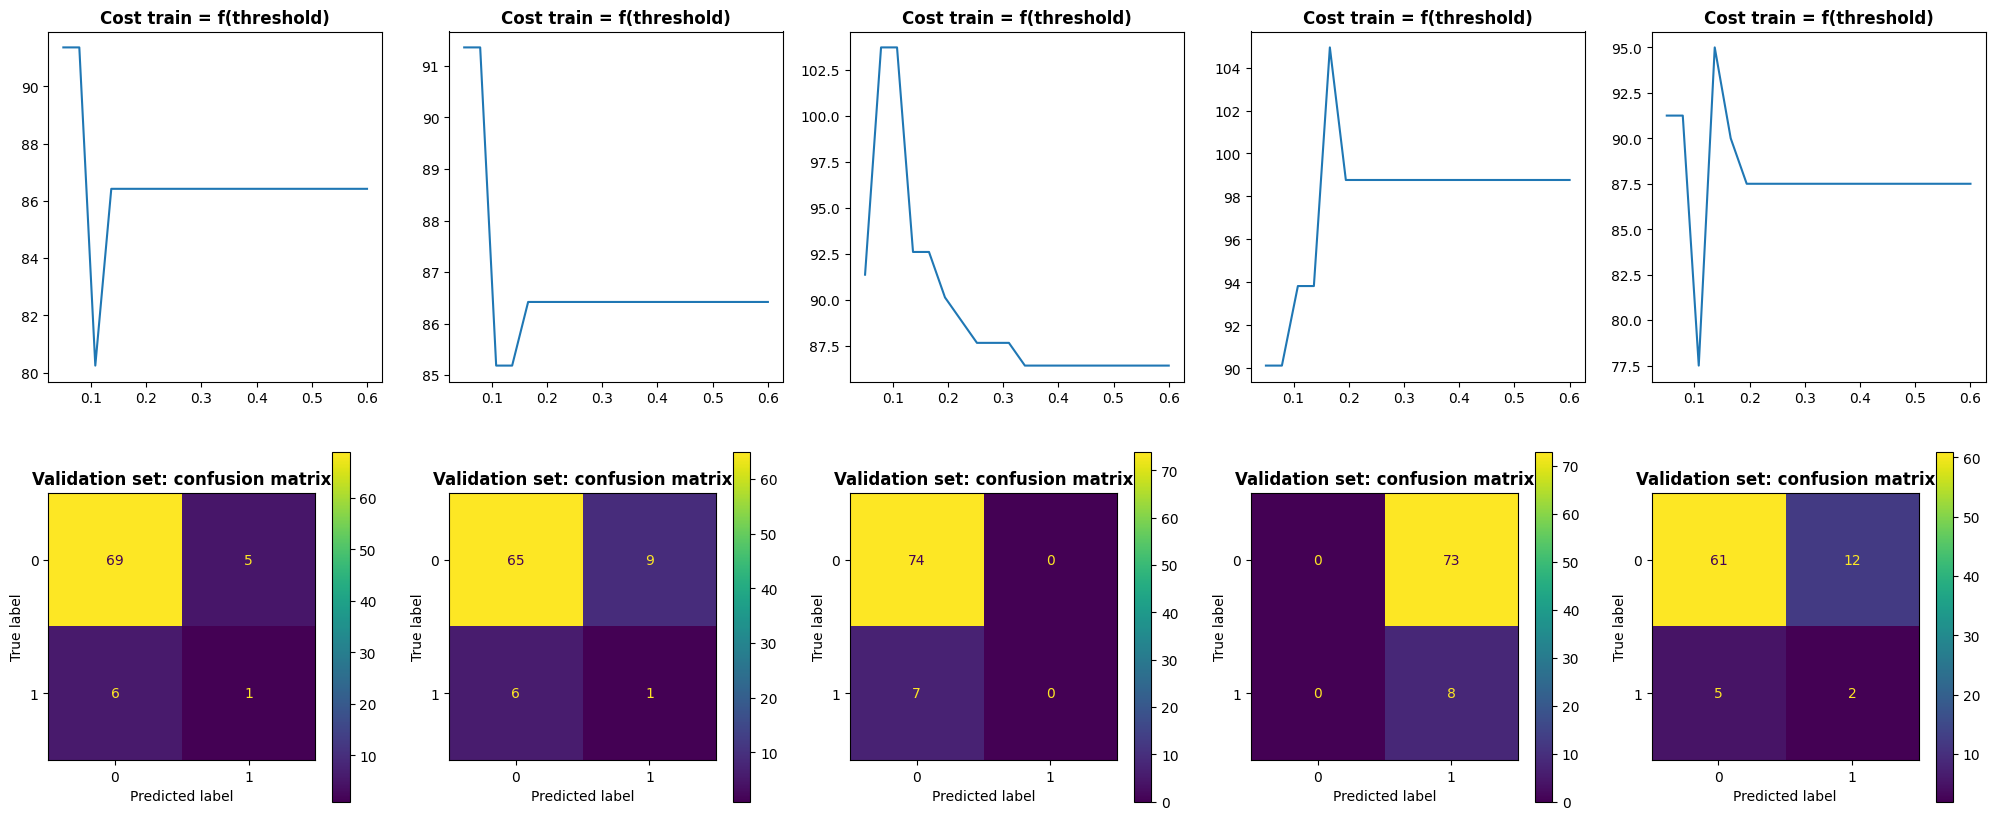

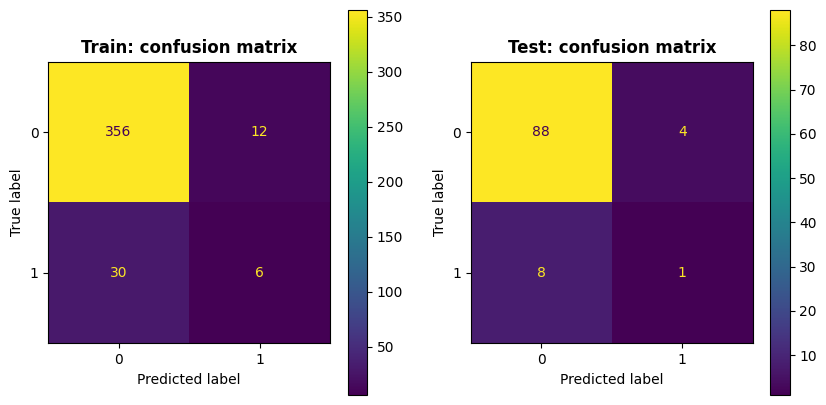

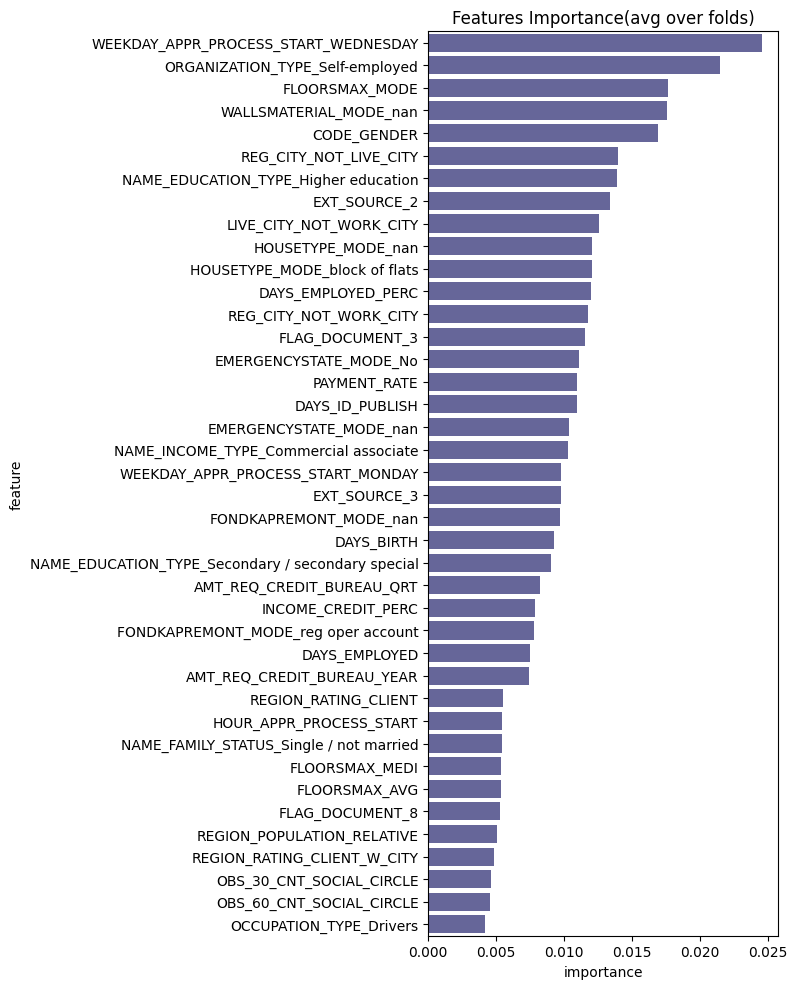

In [216]:
model6(df_1000)

## KNN smote

In [217]:
from imblearn.over_sampling import SMOTE, KMeansSMOTE, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

def KNN_smote(df, num_folds, stratified = False):
    
    from imblearn.pipeline import Pipeline
    
    X_train, X_test, y_train, y_test  = split(df)
    
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=42)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=42)
   
    features = [f for f in X_train.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    feature_importance_df = pd.DataFrame()
    result = []
    result_validation_set = pd.DataFrame()
    
    fig, ax = plt.subplots(2, num_folds, figsize=(num_folds*5, 10))
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train[features], y_train)):
        train_x, train_y = X_train[features].iloc[train_idx], y_train.iloc[train_idx]
        valid_x, valid_y = X_train[features].iloc[valid_idx], y_train.iloc[valid_idx]
        
        imp = SimpleImputer(strategy='median')
        scl = MinMaxScaler()
        over = SMOTE(random_state=42, sampling_strategy=0.4, k_neighbors=3)
        under = RandomUnderSampler(random_state=42, sampling_strategy=0.9)
        regressor = KNeighborsClassifier(weights='uniform', 
                                     algorithm='auto',  
                                     p=2, 
                                     metric='minkowski',
                                     leaf_size=30,
                                     metric_params=None, 
                                     n_jobs=None)
        steps = [('imp', imp), ('scl', scl), ('over', over), ('under', under), ('model', regressor)]
        pipe = Pipeline(steps)
        pipe.fit(train_x, train_y)
    
    
    # Calcul des scores roc_auc pour valid et test
        valid_predict = pipe.predict_proba(valid_x)
        valid_predict_proba = [pred[1] for pred in valid_predict]
        valid_predict_proba_df = pd.DataFrame(valid_predict_proba)
        
        param = np.linspace(0.4, 0.7, 20)
        cost = []
        
        for i in param: 
            valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>i else 0)
            cm_valid = confusion_matrix(valid_y, valid_predict_class)
            cost += [(10*cm_valid[1][0] + cm_valid[0][1])/len(valid_y)*100]
        sns.lineplot(ax=ax[0][n_fold], x=param, y=cost)
        ax[0][n_fold].set_title('Cost train = f(threshold)', weight='bold')
    
        # Construction des matrices de confusion avec le meilleur threshold
        best_param = param[cost.index(min(cost))]
        print(f"Threshold optimum: {best_param}")
        result += [best_param]
        valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>best_param else 0)
        cm_valid = confusion_matrix(valid_y, valid_predict_class)
        confusion_valid = ConfusionMatrixDisplay(cm_valid)
        confusion_valid.plot(ax=ax[1][n_fold])
        confusion_valid.ax_.set_title('Validation set: confusion matrix', weight='bold')
        
        
        
        results_valid = [accuracy_score(valid_y, valid_predict_class),
                    (10*cm_valid[1][0] + cm_valid[0][1])/len(valid_x)*100,
                    f1_score(valid_y, valid_predict_class),
                    precision_score(valid_y, valid_predict_class),
                    (cm_valid[0][0]-(10*cm_valid[1][0] ))/len(valid_x)*100,
                    recall_score(valid_y, valid_predict_class),
                    roc_auc_score(valid_y, valid_predict_proba)] 
        result_validation_set['n_fold'] = results_valid
    result_validation = list(result_validation_set.mean(axis=1))
        
    best_threshold = np.array(result).mean()
    print(f"Threshold optimum - Mean: {best_threshold}")
    
    imp = SimpleImputer(strategy='median')
    scl = MinMaxScaler()
    over = SMOTE(random_state=42, sampling_strategy=0.4, k_neighbors=3)
    under = RandomUnderSampler(random_state=42, sampling_strategy=0.6)
    regressor = KNeighborsClassifier(weights='uniform', 
                                     algorithm='auto',  
                                     p=2, 
                                     metric='minkowski',
                                     leaf_size=30,
                                     metric_params=None, 
                                     n_jobs=None)
    steps = [('imp', imp), ('scl', scl), ('over', over), ('under', under), ('model', regressor)]
    pipe = Pipeline(steps)
    pipe.fit(X_train, y_train)
    
    
    train_predict = pipe.predict_proba(X_train)
    train_predict_proba = [pred[1] for pred in train_predict]
    train_predict_proba_df = pd.DataFrame(train_predict_proba)
    train_predict_class = train_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    test_predict = pipe.predict_proba(X_test)
    test_predict_proba = [pred[1] for pred in test_predict]
    test_predict_proba_df = pd.DataFrame(test_predict_proba)
    test_predict_class = test_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    
    cm_train = confusion_matrix(y_train, train_predict_class)
    confusion_train = ConfusionMatrixDisplay(cm_train)
    cm_test = confusion_matrix(y_test, test_predict_class)
    confusion_test = ConfusionMatrixDisplay(cm_test)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = permutation_importance(pipe, train_x, train_y, scoring='roc_auc').importances_mean
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    feature_importance_df["importance"] = feature_importance_df["importance"].apply(lambda x: abs(x))
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    confusion_train.plot(ax=ax[0])
    confusion_train.ax_.set_title('Train: confusion matrix', weight='bold')
    confusion_test.plot(ax=ax[1])
    confusion_test.ax_.set_title('Test: confusion matrix', weight='bold')
    
    results_test = [accuracy_score(y_test, test_predict_class),
                    (10*cm_test[1][0] + cm_test[0][1])/len(X_test)*100,
                    f1_score(y_test, test_predict_class),
                    precision_score(y_test, test_predict_class),
                    (cm_test[0][0]-(10*cm_test[1][0] ))/len(X_test)*100,
                    recall_score(y_test, test_predict_class),
                    roc_auc_score(y_test, test_predict_proba)] 
    results_train = [accuracy_score(y_train, train_predict_class),
                    (10*cm_train[1][0] + cm_train[0][1])/len(X_train)*100,
                    f1_score(y_train, train_predict_class),
                    precision_score(y_train, train_predict_class),
                    (cm_train[0][0]-(10*cm_train[1][0] ))/len(X_train)*100,
                    recall_score(y_train, train_predict_class),
                    roc_auc_score(y_train, train_predict_proba)] 
    print(score_df(results_train, result_validation, results_test))
   
    display_importances(feature_importance_df) 

In [218]:
def model6_bis(df, num_folds=5, stratified = True):
    with timer("Run KNN smote"):
        KNN_smote(df, num_folds, stratified)

Threshold optimum: 0.6052631578947368
Threshold optimum: 0.6052631578947368
Threshold optimum: 0.6052631578947368
Threshold optimum: 0.6052631578947368
Threshold optimum: 0.6052631578947368
Threshold optimum - Mean: 0.6052631578947368
           Validation      Train       Test
Accuracy     0.475000   0.750000   0.613861
Cost        75.000000  33.910891  74.257426
F1_score     0.192308   0.387879   0.204082
Precision    0.111111   0.248062   0.125000
Profit      16.250000  57.178218  16.831683
Recall       0.714286   0.888889   0.555556
roc_auc      0.602740   0.903344   0.596618
Run KNN smote - done in 30s


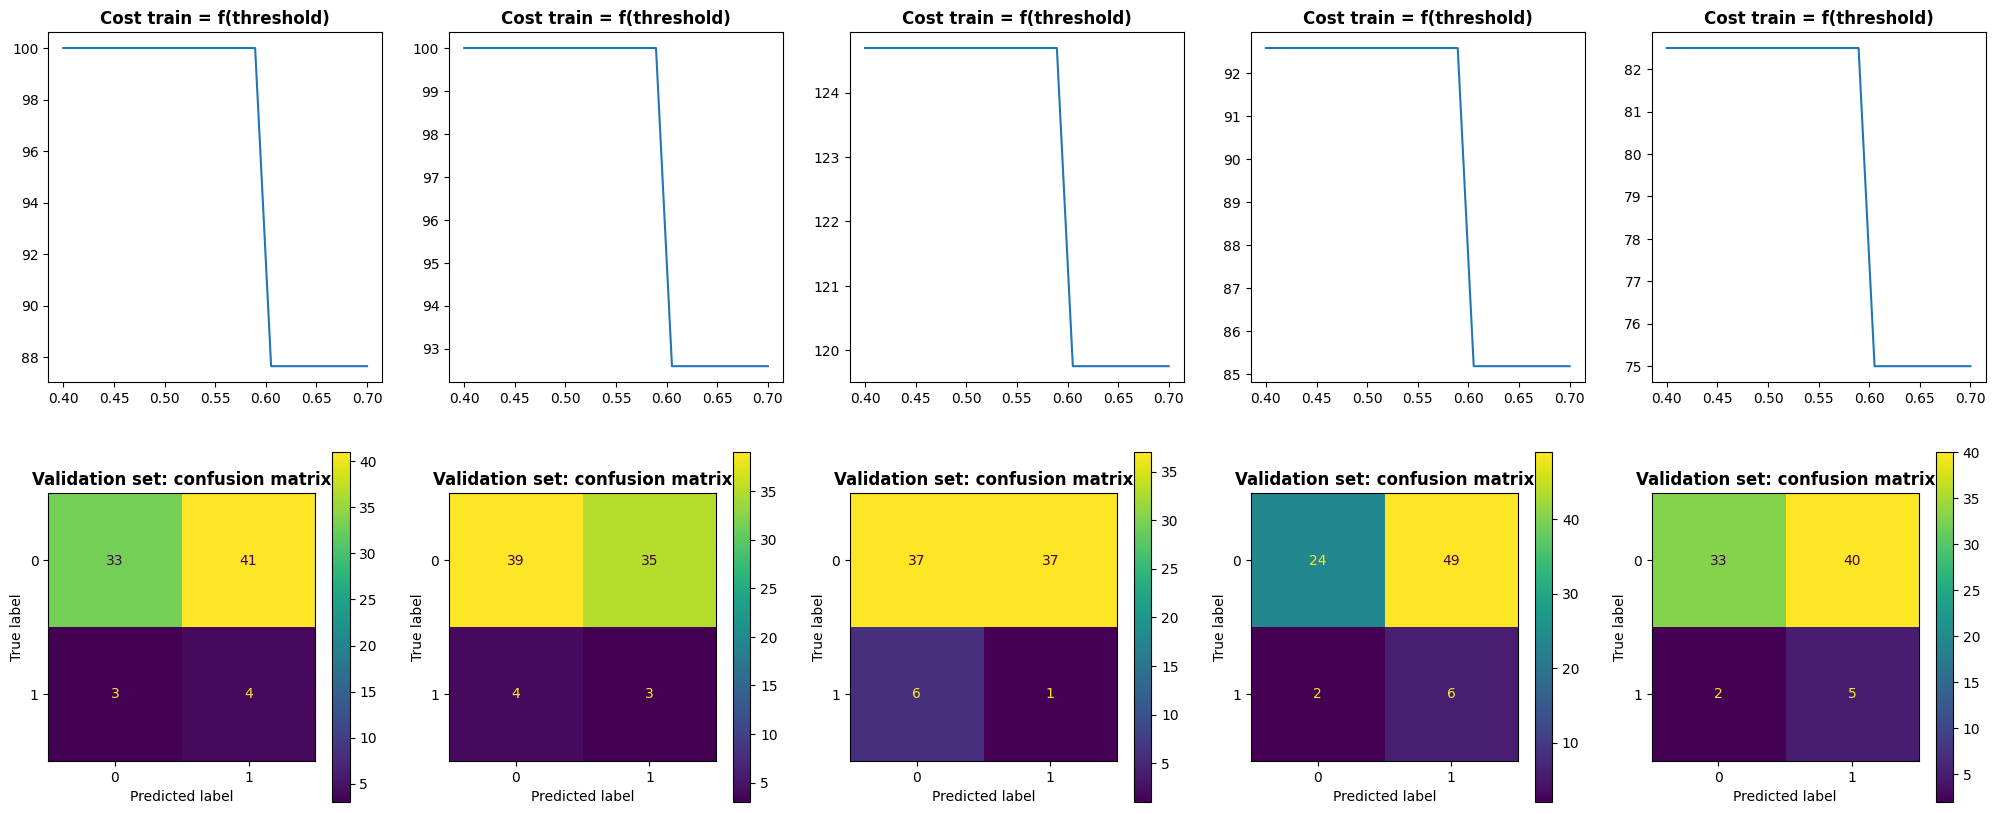

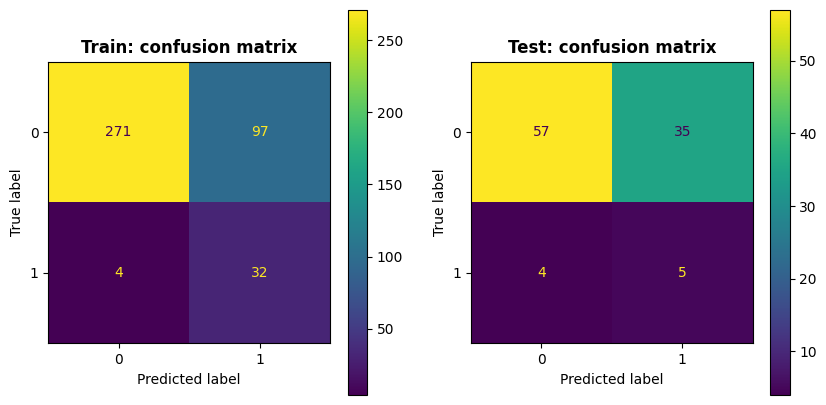

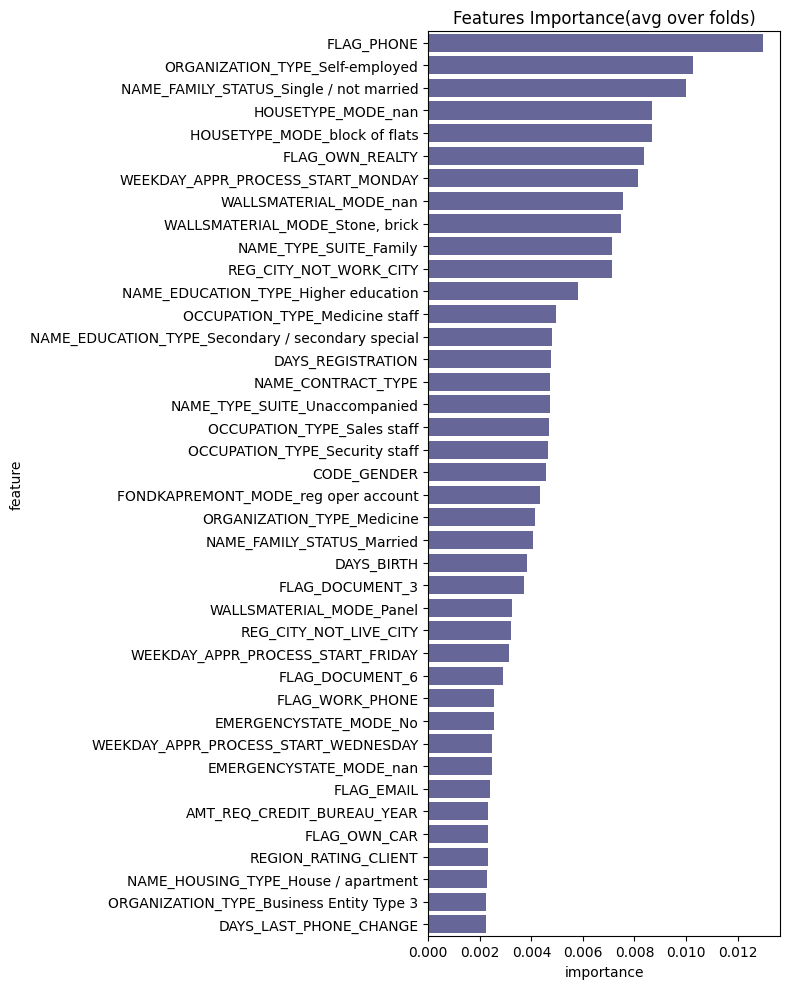

In [220]:
model6_bis(df_1000)